In [1]:
import os
import astropy
import requests
import pandas as pd
import numpy as np
import lightkurve as lk 
from scipy.interpolate import interp1d
from astropy.modeling import models, fitting
import matplotlib.pyplot as plt
import emcee
import sys
import csv
from astropy.timeseries import LombScargle
from os.path import basename, exists

# change these paths to wherever you have the files
# sys.path.insert(1,'/Users/neisner/Documents/code/utils/')
import filters # Suzanne's functions
import norm

# change these paths to wherever you have the files
# sys.path.insert(1,'/Users/neisner/Documents/code/ETV')
import etv_functions # Nora's functions 

%matplotlib inline

In [2]:
from IPython.display import display, HTML, Javascript, clear_output

display(HTML("<style>.container { width:99% !important; }</style>"))  # Jupyter 6
display(HTML("<style>.jp-Notebook { --jp-notebook-max-width: 98%; }</style>"))  # Jupyter 7

# define the paths where the data will be stores - NEED TO CHANGE THIS TO YOUR OWN PATH
outfile_base = './etv_out'  # for ETV
lk_download_dir = 'C:/dev/_juypter/PH_TESS_LightCurveViewer/data'  

# A command from shell that can be run to notify users, e.g., fitting is finished. Use "echo" if you do not have one
NOTIFY_CMD = "win-notify.bat"

if hasattr(lk, "conf"):  # default download dir
    lk.conf.cache_dir = lk_download_dir
if hasattr(lk.search, "sr_cache"):   # PR for persistent query result cache
    lk.search.sr_cache.cache_dir = lk_download_dir  # None
    lk.search.sr_cache.expire_second = 86400

## Looking for ETVs in TIC 273874851


In [3]:
# define the plotting parameters

figsize = (8,4)

In [18]:
# import the data

# choose a TIC ID to analyze
ticid = 273874851

# define the paths where the data will be stores - NEED TO CHANGE THIS TO YOUR OWN PATH
outfile_path = f"{outfile_base}/tic{ticid}_etv_primary.csv"
outfile_path_s = f"{outfile_base}/tic{ticid}_etv_secondary.csv"


# import data using Lightkurve
# sr = lk.search_lightcurve('TIC {}'.format(ticid), author = 'SPOC')  
if not "../.." in sys.path:
    sys.path.append("../..")
import lightkurve_ext as lke  # at ../../
import astropy.units as u


# Note: For this target, inconsistent eclipse depth seen in SPOC PDCSAP_FLUX, (and QLP to a lesser extent).
#       It's likely related to crowding correction 
# Therefore,
# - SPOC SAP_FLUX is used, with more consistent eclipse depth (for the global model), 
#   the eclipse depth seen here is thus shallower than actual. 
#   But for the purpose of identifying ETVs, it is probably less important 
#   than the model inaccuracy due to inconsistent eclipse depth.
# - QLP data from S74,75 not included. Since S76 from SPOC is included, the long-term trend is still covered.
#
sr = lk.search_lightcurve('TIC {}'.format(ticid))  # get long cadence data too
sr = lke.filter_by_priority(sr, author_priority=['SPOC', 'TESS-SPOC'], exptime_priority=['short', 'long', 'fast'])
# sr = sr[sr.exptime != 1800 *u.s]  # exclude 30min cadence data for now (TESS-SPOC, sectors 18, 19, 23 )
sr = sr[np.isin(sr.author, ['SPOC', 'TESS-SPOC'])]  # exclude QLP (in S74, 75) to ensure for uniformity in the data (in terms of eclipse depth)
sr = lke._sort_chronologically(sr)  # workaround lightkurve v2.4.2+ change in sort order
display(sr)
lcc_tess = sr.download_all()
# lc_tess = lcc_tess.stitch()
# lc_tess = lcc_tess.stitch(corrector_func=lambda lc: lc.select_flux("sap_flux").normalize() if lc.author == "SPOC" else lc.select_flux("sap_flux", "det_flux_err").normalize())  
lc_tess = lcc_tess.stitch(corrector_func=lambda lc: lc.select_flux("sap_flux").normalize())
# lc_tess = lc_tess.truncate(3200, None) 


search_result = lc_tess

time = search_result.time.value
flux = search_result.flux.value
fluxerr = search_result.flux_err.value
len(search_result)

SearchResult containing 6 data products.

 #     mission     year author exptime target_name distance proposal_id
                                  s                 arcsec             
--- -------------- ---- ------ ------- ----------- -------- -----------
  0 TESS Sector 14 2019   SPOC     120   273874851      0.0     G022062
  1 TESS Sector 15 2019   SPOC     120   273874851      0.0     G022062
  2 TESS Sector 41 2021   SPOC     120   273874851      0.0      G04171
  3 TESS Sector 54 2022   SPOC     120   273874851      0.0      G04171
  4 TESS Sector 56 2022   SPOC     120   273874851      0.0      G05003
  5 TESS Sector 76 2024   SPOC     120   273874851      0.0      G06057

111031

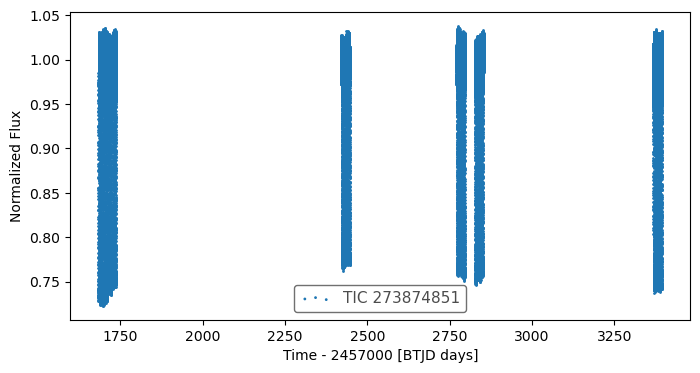

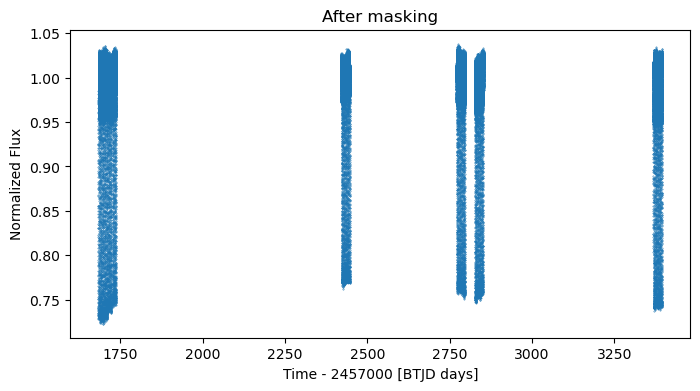

In [19]:
%matplotlib inline
# %matplotlib widget

time = search_result.time.value
flux = search_result.flux.value
fluxerr = search_result.flux_err.value
len(search_result)

# mask out data you don't like...

fig, ax = plt.subplots(figsize=figsize)
search_result.scatter(ax = ax)

mask = time < 0  #( time > 54950) & (time < 54963)  #  truncate weird spikes at the beginning of Kepler data  
# mask = flux < 0.85    # remove occassional outliers

time = time[~mask]
flux = flux[~mask]
fluxerr = fluxerr[~mask]

# make sure that therte are no nans!

finite_mask = np.isfinite(time) * np.isfinite(flux) * np.isfinite(fluxerr)

# make a dictionary of the data 

data = pd.DataFrame({'time': time[finite_mask], 'flux': flux[finite_mask], 'err': fluxerr[finite_mask]})

ax2 = plt.figure(figsize=figsize).gca()
ax2.scatter(data.time, data.flux, s=0.1);
ax2.set_ylabel(ax.get_ylabel())
ax2.set_xlabel(ax.get_xlabel())
ax2.set_title("After masking");

In [6]:
do_bls = False

if do_bls:
    if not "../.." in sys.path:
        sys.path.append("../..")
    import lightkurve_ext_pg_runner as lke_pg_runner  # at ../../

    bls_result = lke_pg_runner.run_bls(
        search_result.remove_nans(),
        pg_kwargs=dict(
            minimum_period=1, maximum_period=20,
            frequency_factor=1,            
            duration=[3.4957 / 24 * f for f in [0.975, 1, 1.025, 1.05, 1.1, 1.15,]],  # based on observed primary eclipse duration for better fit
        ),
    )
    !$NOTIFY_CMD  "BLS Done"

In [7]:
# Visaully compare different candidate period

# ax = search_result.normalize().fold(epoch_time=1471.4196, period=8.418132651611877).truncate(-0.1, 0.1).scatter(label="BLS period, frequency_factor=10");  # HWHM 0.001571020094789155
# ax = search_result.normalize().fold(epoch_time=1471.4196, period=8.418147).truncate(-0.1, 0.1).scatter(label="s0001-s0009:TCE1");

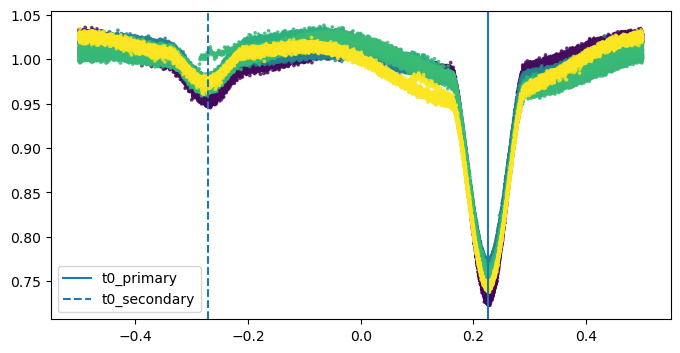

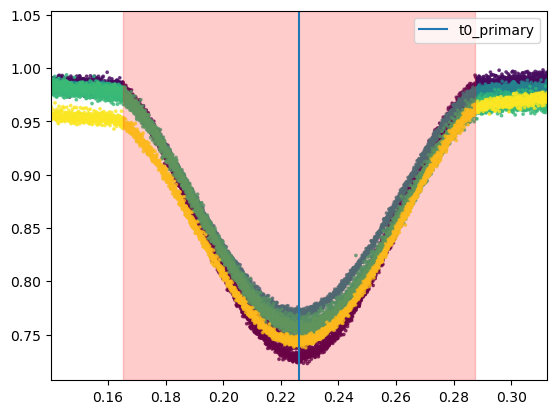

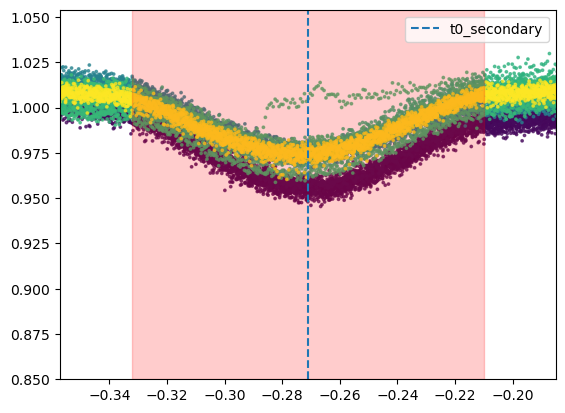

In [30]:
%matplotlib inline
# %matplotlib widget

from astropy.time import Time

# define the orbital period and the t0 

# epoch=1683.4692, duration_hr=3.5000, period=2.045219, label="s0014-s0060:TCE1",
# TCE2 exists, but it matches a bogus dip
# VSX: 2.04516121
# MCMC on df_primary: 2.045206282737052
# Redo with 1) narrow LC, include s76 SPOC data, use sap_flux for more uniform dip depth for modeling
# MCMC: 2.0452014701736863, std_p: 4.006100740200591e-08
#       t0=1683.480869779204, std_t0: 2.2e-05

# FILL-IN THE eclipse epoch / period, 
period = 2.045201  # MCMC

# t0_primary = 1683.4692 + 0.01  # offsets applied after visual inspection
t0_primary = 1683.4809  # MCMC
t0_secondary = t0_primary +  1.028  # offset from TCE1


# convert epoch from BTJD to commonly mjd used here
# t0_primary = Time(t0_primary, format="btjd").to_value("mjd")
# t0_secondary = Time(t0_secondary, format="btjd").to_value("mjd")

# Move t0 to the first dip in the data (some of the subsequent codes, espically fit_each_eclipse(), assumes that)
t0_primary = t0_primary - int((t0_primary - data['time'][0]) / period) * period
if t0_secondary is not None:
    t0_secondary = t0_secondary - int((t0_secondary - data['time'][0]) / period) * period

duration_hr_primary = 6
duration_hr_secondary = 6

# t0_for_plotting = 0  # keep 0 for plotting purposes
t0_for_plotting = t0_primary - np.abs(t0_primary - t0_secondary) * 0.45  # use a custom one so that the eclipses are not near the edge (-0.5 or +0.5)

phase = etv_functions.phase_data(data['time'], t0_for_plotting, period)

fig, ax = plt.subplots(figsize = (8,4))

plt.scatter(phase,data['flux'], s = 3, alpha = 0.7, c = data['time'])

# add the phase to the dataframe
data['phase'] = phase

plt.axvline(etv_functions.phase_data([t0_primary], t0_for_plotting, period)[0], label="t0_primary")
if t0_secondary is not None:
    plt.axvline(etv_functions.phase_data([t0_secondary], t0_for_plotting, period)[0], linestyle="--", label="t0_secondary")
plt.legend()
# plt.ylim(0.535, 0.55)
# plt.xlim(-0.5, 0.1)
plt.show();

plt.scatter(phase,data['flux'], s = 3, alpha = 0.7, c = data['time'])
plt.axvline(etv_functions.phase_data([t0_primary], t0_for_plotting, period)[0], label="t0_primary")
t1_p, t4_p = etv_functions.phase_data([t0_primary], t0_for_plotting, period)[0] - 0.5 * duration_hr_primary / 24/ period, etv_functions.phase_data([t0_primary], t0_for_plotting, period)[0] + 0.5 * duration_hr_primary / 24/ period 
plt.xlim(t1_p - 0.025, t4_p + 0.025);
plt.axvspan(t1_p, t4_p, color="red", alpha=0.2);plt.legend();
# plt.ylim(0.75, 0.85);
plt.show()

plt.scatter(phase,data['flux'], s = 3, alpha = 0.7, c = data['time'])
plt.axvline(etv_functions.phase_data([t0_secondary], t0_for_plotting, period)[0], linestyle="--", label="t0_secondary")
t1_s, t4_s = etv_functions.phase_data([t0_secondary], t0_for_plotting, period)[0] - 0.5 * duration_hr_secondary / 24/ period, etv_functions.phase_data([t0_secondary], t0_for_plotting, period)[0] + 0.5 * duration_hr_secondary / 24/ period 
plt.xlim(t1_s - 0.025, t4_s + 0.025);
plt.axvspan(t1_s, t4_s, color="red", alpha=0.2);plt.legend();
plt.legend();
plt.ylim(0.85, None);
plt.show()

### Compare folded plots across sectors

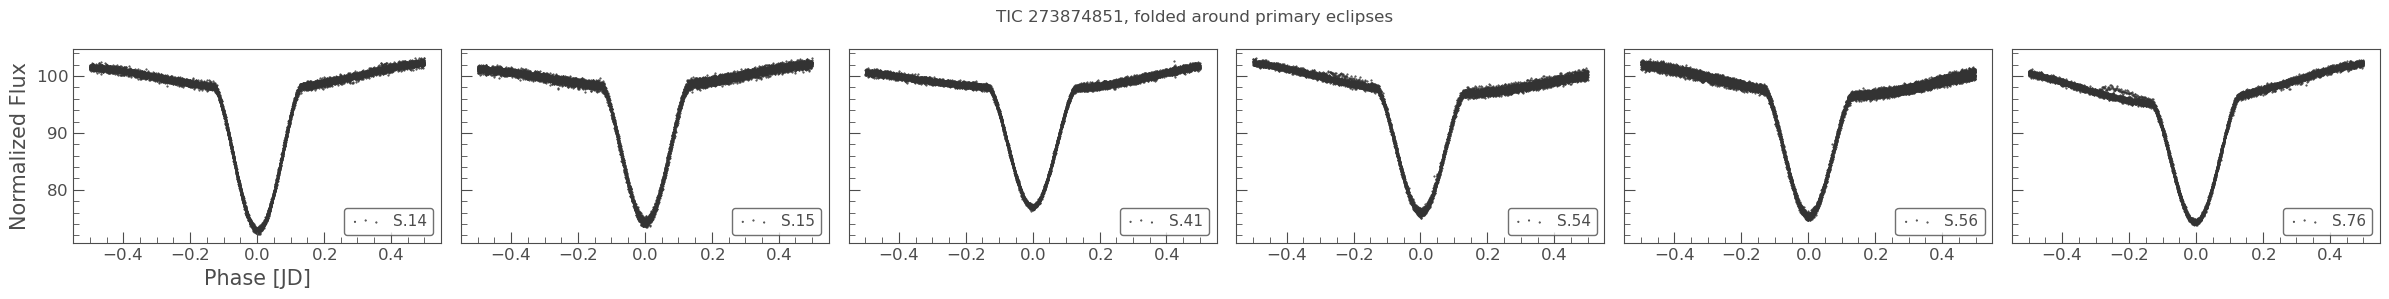

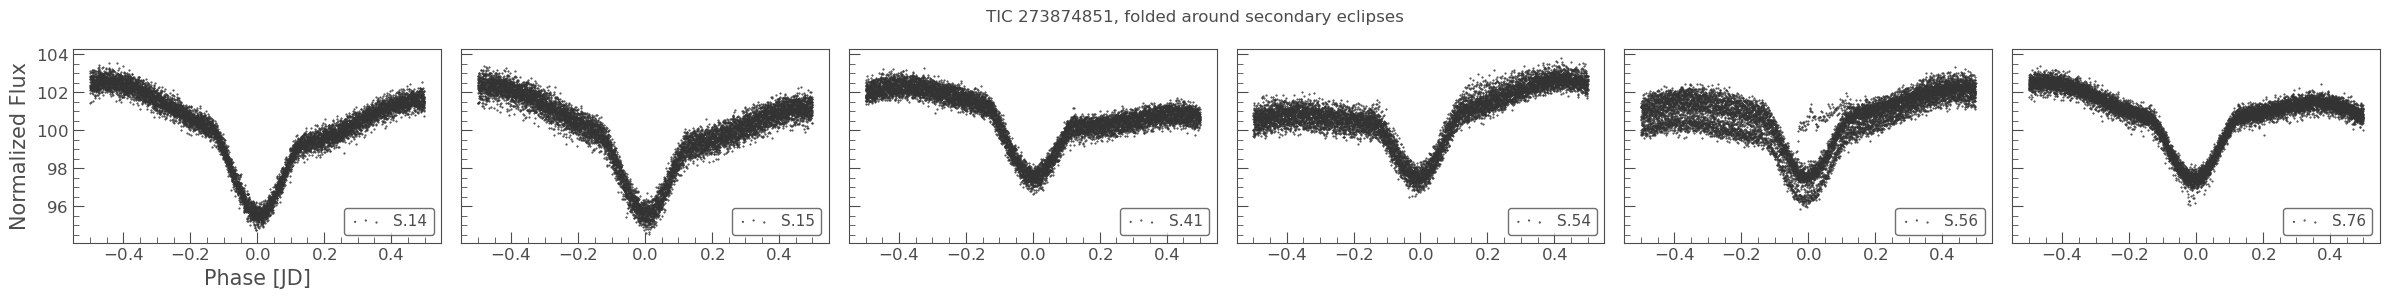

In [22]:
with plt.style.context(lk.MPLSTYLE):
    fig, axs = plt.subplots(1, len(lcc_tess), figsize=(4 * len(lcc_tess), 3), sharey=True);
    if isinstance(axs, plt.Axes):
        axs = [axs]
    for i, lc in enumerate(lcc_tess):
        lc_f = lc.select_flux("sap_flux").normalize(unit="percent").fold(period=period, epoch_time=t0_primary)
        lc_f = lc_f.truncate(-duration_hr_primary * 2 / 24, duration_hr_primary * 2 / 24)
        ax = lc_f.scatter(ax=axs[i], s=1, label=f"S.{lc_f.sector}");
        ax.legend(loc="lower right");
        if i > 0: 
            ax.set_ylabel(None)
            ax.set_xlabel(None)
    fig.suptitle(f"{lc.label}, folded around primary eclipses");
plt.tight_layout();

# ---
with plt.style.context(lk.MPLSTYLE):
    fig, axs = plt.subplots(1, len(lcc_tess), figsize=(4 * len(lcc_tess), 3), sharey=True);
    if isinstance(axs, plt.Axes):
        axs = [axs]
    for i, lc in enumerate(lcc_tess):
        lc_f = lc.select_flux("sap_flux").normalize(unit="percent").fold(period=period, epoch_time=t0_secondary)
        lc_f = lc_f.truncate(-duration_hr_secondary * 2 / 24, duration_hr_secondary * 2 / 24)
        ax = lc_f.scatter(ax=axs[i], s=1, label=f"S.{lc_f.sector}");
        ax.legend(loc="lower right");
        if i > 0: 
            ax.set_ylabel(None)
            ax.set_xlabel(None)
    fig.suptitle(f"{lc.label}, folded around secondary eclipses");
plt.tight_layout();

### Detrend (optional)

- detrended flux is in `flux_detrended`, and won't be used in subsequent work by default

In [ ]:
# show data to visualize what's changed in each step below
data  

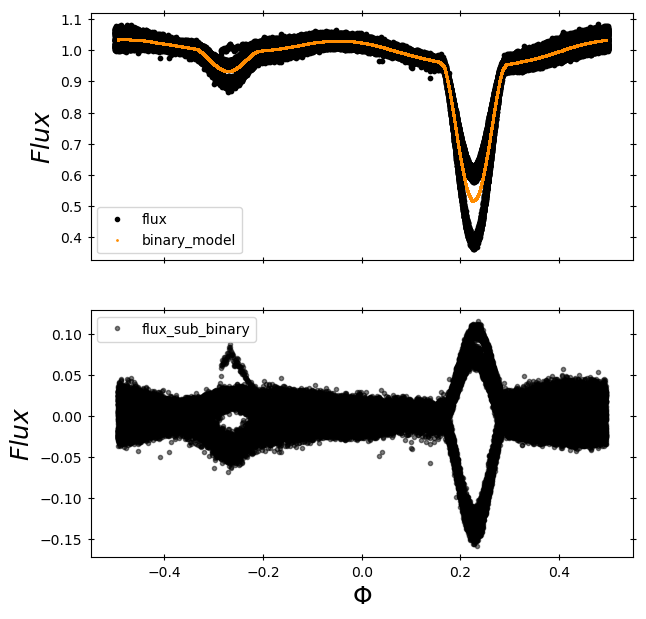

time      flux       err     phase  flux_sub_binary  \
0      1683.356027  0.961519  0.006023  0.165962         0.012214   
1      1683.357416  0.954533  0.006014  0.166642         0.007644   
2      1683.358805  0.945461  0.006006  0.167321         0.001476   
3      1683.360194  0.940828  0.006002  0.168000         0.000186   
4      1683.361583  0.934299  0.006009  0.168679        -0.002610   
...            ...       ...       ...       ...              ...   
90690  2853.134193  0.971119  0.003373  0.127010        -0.002149   
90691  2853.135582  0.965705  0.003374  0.127689        -0.007350   
90692  2853.136971  0.971665  0.003375  0.128368        -0.001181   
90693  2853.138359  0.972272  0.003376  0.129047        -0.000368   
90694  2853.139748  0.966211  0.003370  0.129726        -0.006225   

       binary_model  
0          0.949305  
1          0.946890  
2          0.943985  
3          0.940641  
4          0.936909  
...             ...  
90690      0.973269  
90691      0.973055  
90692      0.972846  
90693      0.972640  
90694      0.972436  

[90695 rows x 6 columns]

In [108]:
# phase fold the data and create an appoximate binary model (top) and subtract it from the data (bottom)
#_, _ , flux_sub_binary, model, _, _ = etv_functions.trend_removal_interact(period, 0, data['time'], data['flux'], data['time'], data['flux'])

data = etv_functions.trend_removal_interact(period, t0_for_plotting, data)
data

10 89750 901
reached the end
10 82627 901
reached the end
10 81194 901
reached the end
10 80892 901
reached the end
10 80825 901
reached the end


time      flux       err     phase  flux_sub_binary  \
0      1683.356027  0.961519  0.006023  0.165962         0.012214   
1      1683.357416  0.954533  0.006014  0.166642         0.007644   
2      1683.358805  0.945461  0.006006  0.167321         0.001476   
3      1683.360194  0.940828  0.006002  0.168000         0.000186   
4      1683.361583  0.934299  0.006009  0.168679        -0.002610   
...            ...       ...       ...       ...              ...   
90690  2853.134193  0.971119  0.003373  0.127010        -0.002149   
90691  2853.135582  0.965705  0.003374  0.127689        -0.007350   
90692  2853.136971  0.971665  0.003375  0.128368        -0.001181   
90693  2853.138359  0.972272  0.003376  0.129047        -0.000368   
90694  2853.139748  0.966211  0.003370  0.129726        -0.006225   

       binary_model  flux_detrended  
0          0.949305        0.959428  
1          0.946890        0.952328  
2          0.943985        0.943138  
3          0.940641        0.938389  
4          0.936909        0.931746  
...             ...             ...  
90690      0.973269        0.972160  
90691      0.973055        0.966759  
90692      0.972846        0.972732  
90693      0.972640        0.973351  
90694      0.972436        0.967302  

[90695 rows x 7 columns]

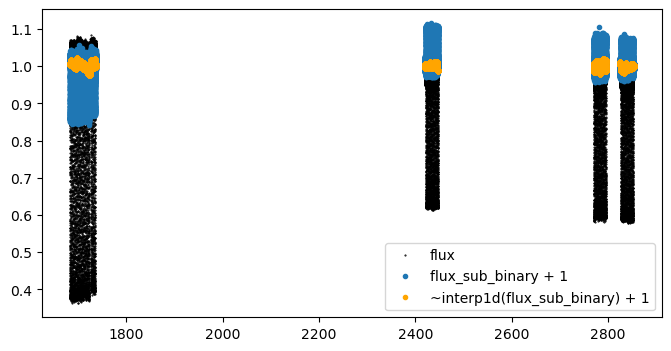

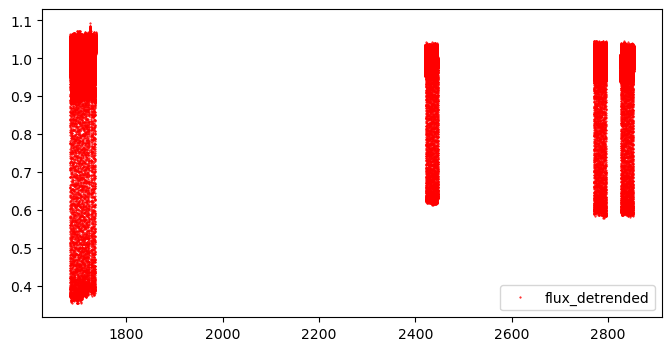

In [109]:
# if you want to detrend the data run this line!

data = etv_functions.detrend_suz(data, T_dur = 10, plot = True)
data

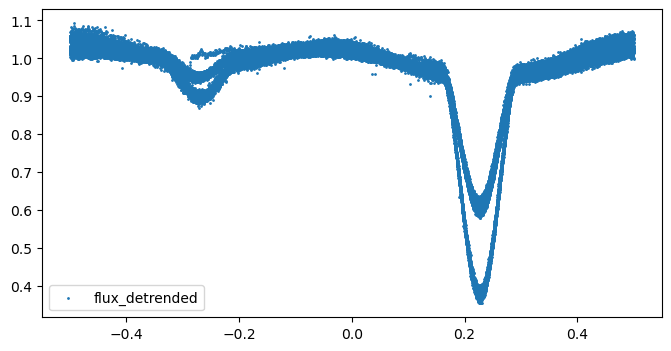

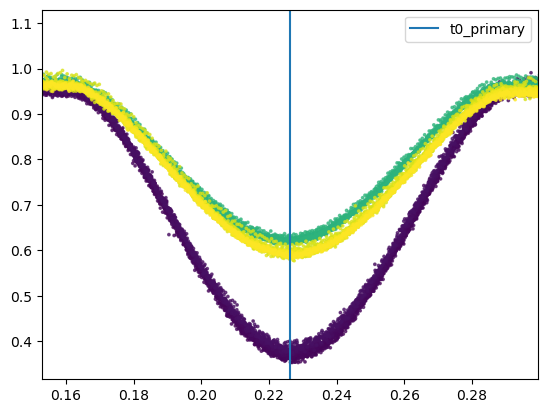

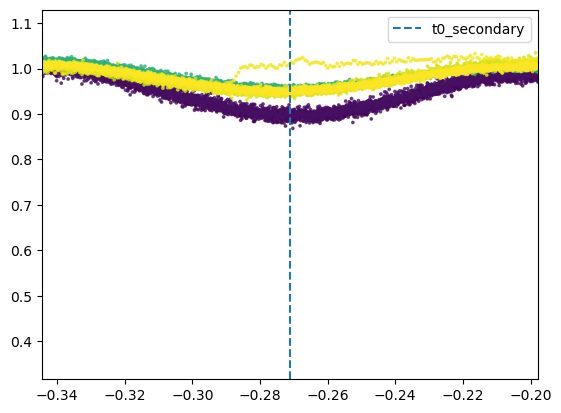

In [110]:
# plot the phase folded data here so that you know at what phase you want to cut the data to model 
fig, ax = plt.subplots(figsize = figsize)
plt.scatter(data.phase, data.flux_detrended, s = 1, label="flux_detrended")
plt.legend()
plt.show()

plt.scatter(phase,data['flux_detrended'], s = 3, alpha = 0.7, c = data['time'])
plt.axvline(etv_functions.phase_data([t0_primary], t0_for_plotting, period)[0], label="t0_primary")
plt.xlim(etv_functions.phase_data([t0_primary], t0_for_plotting, period)[0] - 0.6 * duration_hr_primary / 24/ period, etv_functions.phase_data([t0_primary], t0_for_plotting, period)[0] + 0.6 * duration_hr_primary / 24/ period);
plt.legend();
# plt.ylim(0.75, 0.85);
plt.show()

plt.scatter(phase,data['flux_detrended'], s = 3, alpha = 0.7, c = data['time'])
plt.axvline(etv_functions.phase_data([t0_secondary], t0_for_plotting, period)[0], linestyle="--", label="t0_secondary")
plt.xlim(etv_functions.phase_data([t0_secondary], t0_for_plotting, period)[0] - 0.6 * duration_hr_secondary / 24/ period, etv_functions.phase_data([t0_secondary], t0_for_plotting, period)[0] + 0.6 * duration_hr_secondary / 24/ period);
plt.legend();
# plt.ylim(0.75, 0.85);
plt.show()

<span style="background-color: rgba(255, 0, 0, 0.6);"> NOTE: </span> The zoom windows below for the eclipses are made **smaller**, an attempt to reduce the complications of EW variability outside the minima (and some assymetery)

### Now that the data is ready we can start 

In [32]:
# define the midpoints of the primary and secondary eclipses and the window width

# if these don't look central - change them!! the eclipses should be central
midpoint_p =  etv_functions.phase_data([t0_primary], t0_for_plotting, period)[0]  # convet to time in phase
# midpoint_p -= 0.004  # the offset is added back to t0_primary (& secondary above
print('Primary:  ', t0_primary, midpoint_p)

# change depending on the width of the eclipses, default to be slightly larger than the primary eclipse
window_width_p = 0.8 * duration_hr_primary / 24 / period   # it seems to be difficult to bit model the flat bottom and the curves outside, focus on the overall shape for now
# use a shoter duration to avoid fitting the out-of-eclipse LC, which has its own variability that the model is not equipped to hanlde
# window_width_p = 0.095
print("window_width_p (phase):", window_width_p)

data_primary = data[(data['phase'] > midpoint_p - window_width_p / 2) & (data['phase'] < midpoint_p + window_width_p / 2) ]
ph_binned,flux_binned,err_binned = etv_functions.run_binning_phased(data_primary.phase, data_primary.flux, yerr=data_primary.err,nbins=1000)


if t0_secondary is not None:
    midpoint_s =  etv_functions.phase_data([t0_secondary], t0_for_plotting, period)[0]
    print('Secondary:', t0_secondary, midpoint_s)

    # the coshgauss model seems problematic, try to use a larger width to give it more shape to fit
    window_width_s = 0.8 * duration_hr_secondary / 24 / period  
    # window_width_s = 0.22
    print("window_width_s (phase):", window_width_s)
    
    data_secondary = data[(data['phase'] > midpoint_s - window_width_s / 2) & (data['phase'] < midpoint_s + window_width_s / 2) ]
    ph_binned_s,flux_binned_s,err_binned_s = etv_functions.run_binning_phased(data_secondary.phase, data_secondary.flux, yerr=data_secondary.err,nbins=1000)


### # you need initial guesses!! The order is :
# alpha0, alpha1, t0, d, Tau - CHANGE THESE TO YOUR OWN INITIAL GUESSES
# median flux, -eclipse depth, t0, related to duration, related to shape (U or V) 
# t0 in normalixed phase
start_vals = [1.009, -0.2565, midpoint_p, 0.0350, 0.9778]
start_vals_s = [1.012, -0.044, midpoint_s, 0.04, 0.9]
    
# -- -- -- -- -- -- -- -- -- 
# -- -- -- -- -- -- -- -- --
# etv_functions.plot_initial_guess(data_primary, ph_binned, flux_binned, err_binned, *start_vals)
etv_functions.plot_initial_guess_interactive(data_primary, ph_binned, flux_binned, err_binned, "midpoint_p", *start_vals)
if t0_secondary is not None:
    # etv_functions.plot_initial_guess(data_secondary, ph_binned_s, flux_binned_s, err_binned_s, *start_vals_s)
    etv_functions.plot_initial_guess_interactive(data_secondary, ph_binned_s, flux_binned_s, err_binned_s, "midpoint_s", *start_vals_s)

print("Start params for  fitting period with MCMC on df_primary:")
print(f"[{start_vals[0]}, {start_vals[1]}, {t0_primary}, {start_vals[3]}, {start_vals[4]}, {period}],");

Primary:   1683.4809 0.22618803726385128
window_width_p (phase): 0.09778989937908306
Secondary: 1684.5089 -0.2711718799276522
window_width_s (phase): 0.09778989937908306


Output(layout=Layout(padding='1em 0px'))

Output(layout=Layout(padding='1em'))

Output(layout=Layout(padding='1em 0px'))

Output(layout=Layout(padding='1em'))

Start params for  fitting period with MCMC on df_primary:
[1.009, -0.2565, 1683.4809, 0.035, 0.9778, 2.045201],


In [ ]:
if False: 
    # Export the data around primary eclipses, for period analysis outside of notebook
    data_primary[["time", "flux", "err"]].to_csv(f"tmp/data_primary_{ticid}.csv", index=False)

emcee parallel enabled, use 4 CPUs.


100%|██████████████████████████████████████████████████████████| 1000/1000 [05:13<00:00,  3.19it/s]


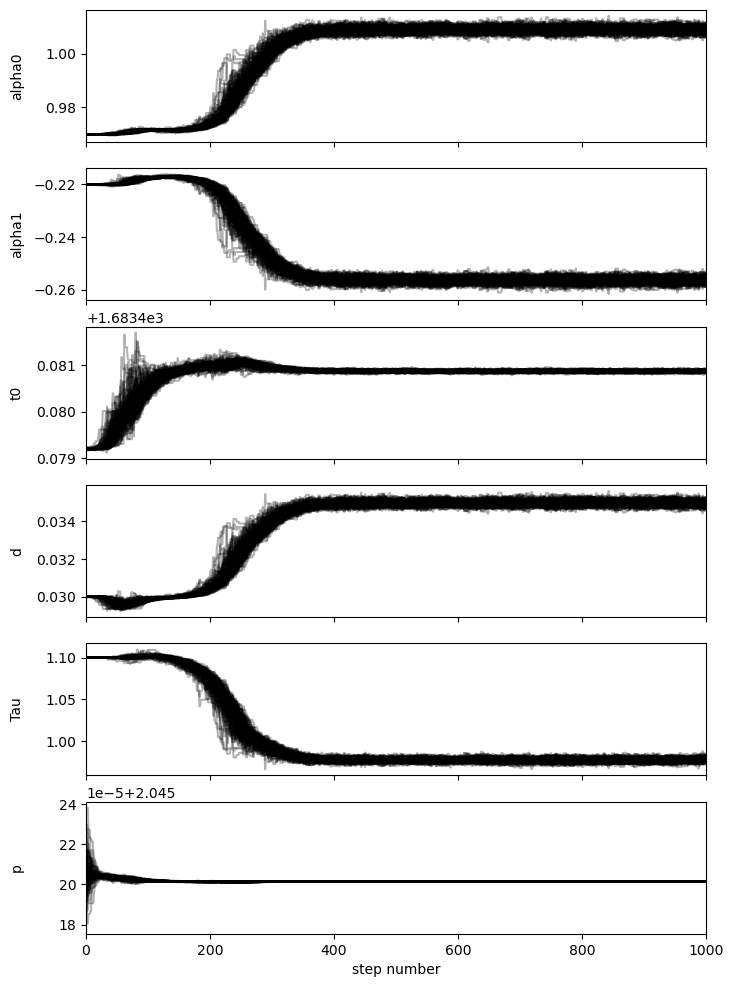

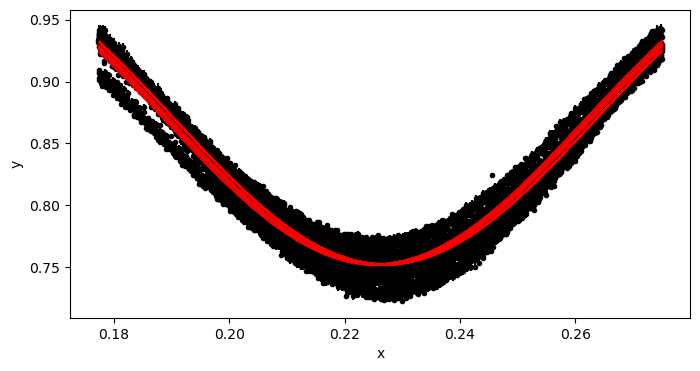

mean_alpha0, mean_alpha1, mean_t0_time, mean_d, mean_Tau, mean_p = 1.0089583109028974, -0.2564593467620162, 1683.480869779204, 0.034955648746538795, 0.9778000444808395, 2.0452014701736863
std_p: 4.006100740200591e-08


In [28]:
# use MCMC to refine the period

use_mcmc_to_fit_period = True


if use_mcmc_to_fit_period:
    import etv_functions_with_period as etvp

    etv_functions.enable_info_log_for_jupyter()
        
    # MCMC result
    # mean_alpha0, mean_alpha1, mean_t0_time, mean_d, mean_Tau, mean_p = 0.97069735960858, -0.39440622544749016, 1683.4795921732793, 0.030462333707786608, 1.1118006681028716, 2.045206282737052
    # std_p: 5.7281188616104385e-08    
    mean_alpha0, mean_alpha1, mean_t0_time, mean_d, mean_Tau, mean_p, fit_params_p_stats = etvp.run_mcmc_initial_fit_p(
        data_primary[:],
        [0.97, -0.22, 1683.4792, 0.03, 1.1, 2.045206],
        nruns=1000, discard=600, 
        # nruns=20, discard=1, 
        pool=-2,
        plot_chains=True,
        plot=True,
        also_return_stats=True,
    )
    print("mean_alpha0, mean_alpha1, mean_t0_time, mean_d, mean_Tau, mean_p = " + ", ".join([str(v) for v in [mean_alpha0, mean_alpha1, mean_t0_time, mean_d, mean_Tau, mean_p]]))
    print("std_p:", fit_params_p_stats["std_p"])
    !$NOTIFY_CMD "Fitting period done."

emcee parallel enabled, use 4 CPUs.


100%|██████████████████████████████████████████████████████████| 1000/1000 [01:23<00:00, 11.91it/s]


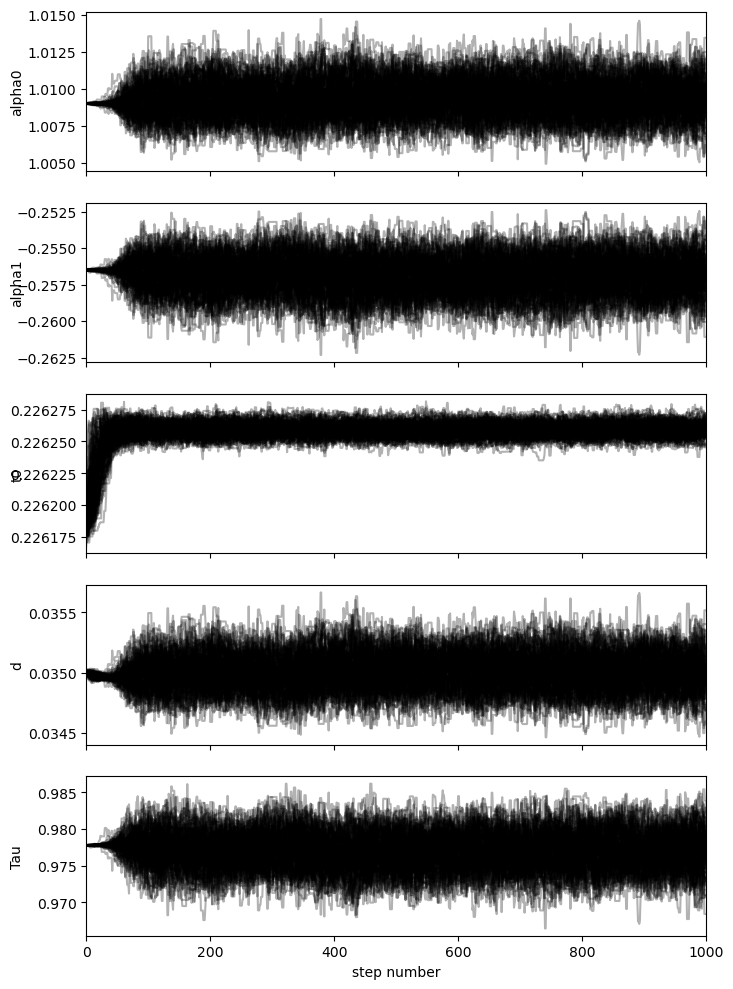

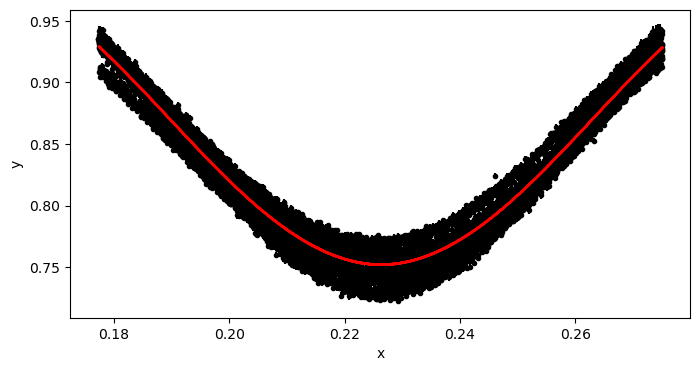

emcee parallel enabled, use 4 CPUs.


100%|██████████████████████████████████████████████████████████| 1000/1000 [01:29<00:00, 11.21it/s]


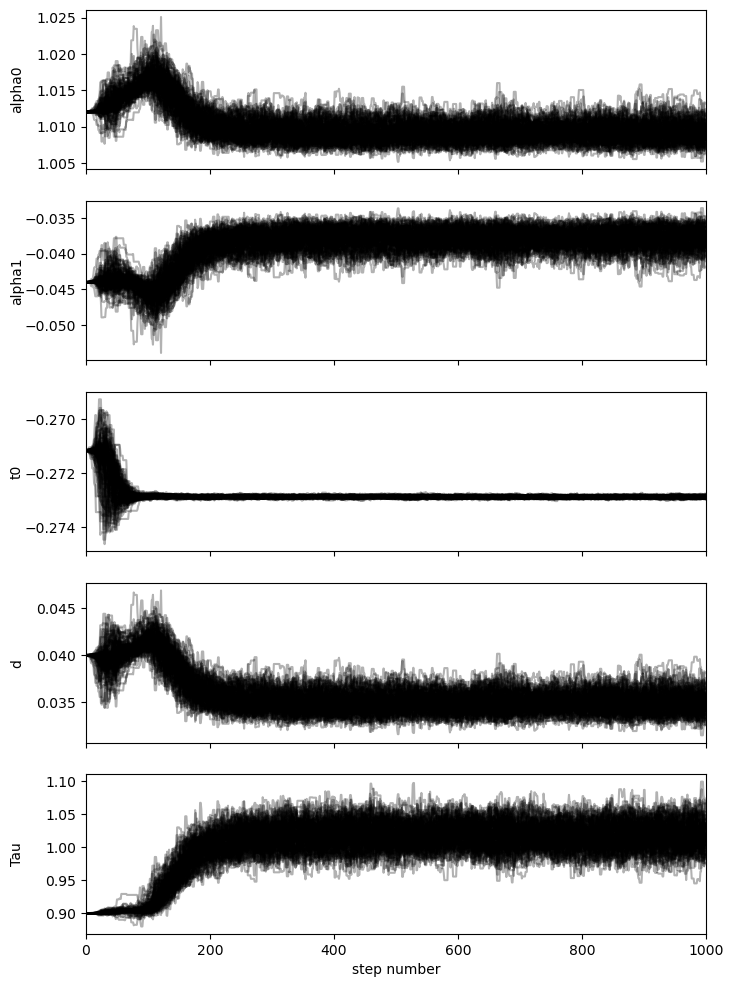

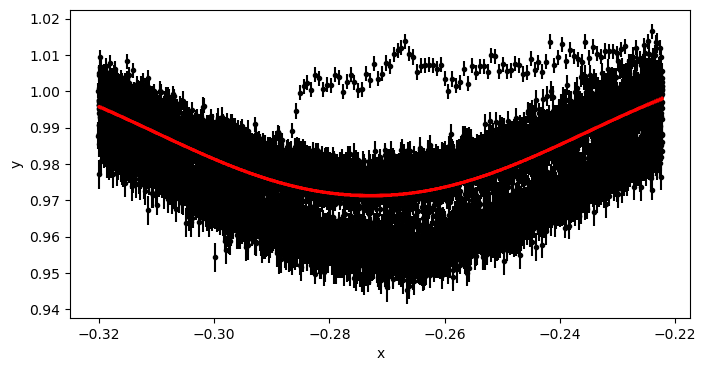

In [33]:
# run the initial model fit using MCMC for the primary and secondary eclipses
run_init_fit = True

if run_init_fit:
    etv_functions.enable_info_log_for_jupyter()
    mean_alpha0, mean_alpha1, mean_t0, mean_d, mean_Tau = etv_functions.run_mcmc_initial_fit(data_primary, start_vals, nruns=1000, discard=600, pool=-2, plot_chains = True, plot = True)
    if t0_secondary is not None:
        mean_alpha0_s, mean_alpha1_s, mean_t0_s, mean_d_s, mean_Tau_s = etv_functions.run_mcmc_initial_fit(data_secondary, start_vals_s, nruns=1000, discard=600, pool=-2, plot_chains = True, plot = True)
    !$NOTIFY_CMD "Initial fit done"

In [ ]:
if not run_init_fit:  # case init fit has been previously saved and to be reussed
    print("Use pre-defined inital model params:")
    # initial fit params from TESS data
    # mean_alpha0_p1, mean_alpha1_p1, mean_t0_p1, mean_d_p1, mean_Tau_p1 = 0.9833005865410819, -0.5991347579558142, 0.22684753496425836, 0.030705075190488623, 1.0997973133463397
    # mean_alpha0_s_p1, mean_alpha1_s_p1, mean_t0_s_p1, mean_d_s_p1, mean_Tau_s_p1 = 1.0033610288814825, -0.107331315327335, -0.2685880551421833, 0.03600403505989863, 0.9427094250355323
    # mean_alpha0_p2, mean_alpha1_p2, mean_t0_p2, mean_d_p2, mean_Tau_p2 = 0.972219078422855, -0.3674102100064864, 0.22631094478539177, 0.03079642595140196, 1.0938956900670778
    # mean_alpha0_s_p2, mean_alpha1_s_p2, mean_t0_s_p2, mean_d_s_p2, mean_Tau_s_p2 = 1.01116069933887, -0.05374889050040259, -0.2733870719767836, 0.030698723245334028, 1.1812832297871605
    # Redo, with S76 data, use SPOC's SAP_FLUX for more uniform dip dpeth (so I dont have to split the data into 2 parts to model separately)
    mean_alpha0, mean_alpha1, mean_t0, mean_d, mean_Tau = 1.0093344572022414, -0.2568461113627834, 0.22625935740406627, 0.03500524193214259, 0.9770631859154246
    mean_alpha0_s, mean_alpha1_s, mean_t0_s, mean_d_s, mean_Tau_s = 1.0091451011936945, -0.03773387812646225, -0.27288391095499587, 0.03491356205866214, 1.0170069966048578

    etv_functions.plot_initial_guess(data_primary, ph_binned, flux_binned, err_binned, *[mean_alpha0, mean_alpha1, mean_t0, mean_d, mean_Tau])
    etv_functions.plot_initial_guess(data_secondary, ph_binned_s, flux_binned_s, err_binned_s, *[mean_alpha0_s, mean_alpha1_s, mean_t0_s, mean_d_s, mean_Tau_s])

In [34]:
print("Initial model params:")  # For information, and they can be copied to the cell above for future reuse

print("mean_alpha0, mean_alpha1, mean_t0, mean_d, mean_Tau = " + ", ".join([str(v) for v in [mean_alpha0, mean_alpha1, mean_t0, mean_d, mean_Tau]]))
if t0_secondary is not None:
    print("mean_alpha0_s, mean_alpha1_s, mean_t0_s, mean_d_s, mean_Tau_s = " + ", ".join([str(v) for v in [mean_alpha0_s, mean_alpha1_s, mean_t0_s, mean_d_s, mean_Tau_s]]))

Initial model params:
mean_alpha0, mean_alpha1, mean_t0, mean_d, mean_Tau = 1.0093344572022414, -0.2568461113627834, 0.22625935740406627, 0.03500524193214259, 0.9770631859154246
mean_alpha0_s, mean_alpha1_s, mean_t0_s, mean_d_s, mean_Tau_s = 1.0091451011936945, -0.03773387812646225, -0.27288391095499587, 0.03491356205866214, 1.0170069966048578


836

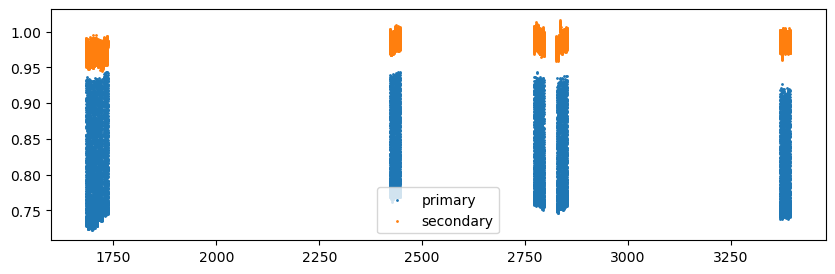

In [35]:
fig = plt.subplots(figsize=(10, 3), sharex=True)
plt.scatter(data_primary.time,data_primary.flux , s = 1, label = 'primary')
if t0_secondary is not None:
    plt.scatter(data_secondary.time,data_secondary.flux , s = 1, label = 'secondary')
plt.legend()

# calculate the number of transits there are within the data 
n_transits = int((max(data_primary.time) - min(data_primary.time)) / period)
n_transits

1683.4809 2.045201 1683.4809


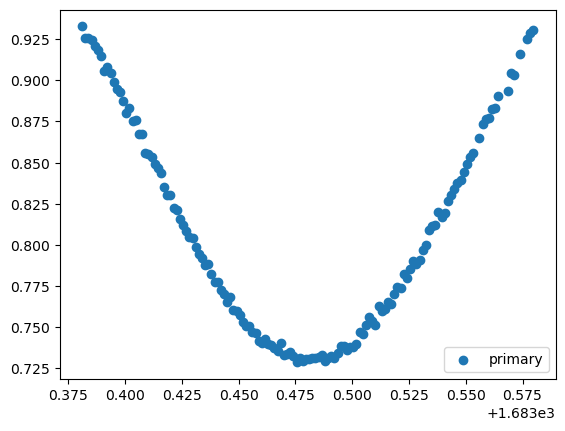

1683.4809 2.045201 1685.526101


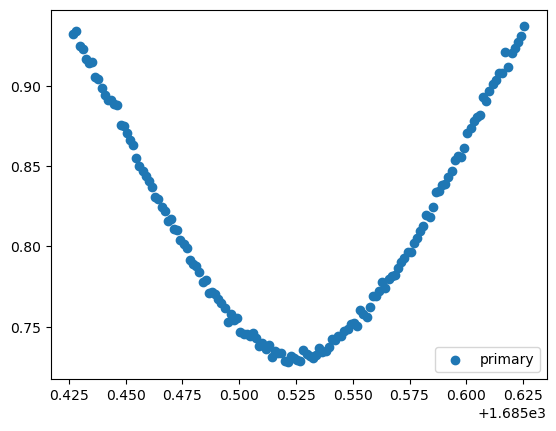

1683.4809 2.045201 1687.571302


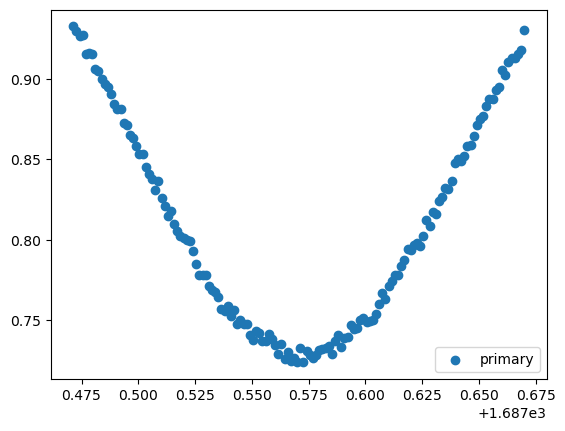

1684.5089 2.045201 1684.5089


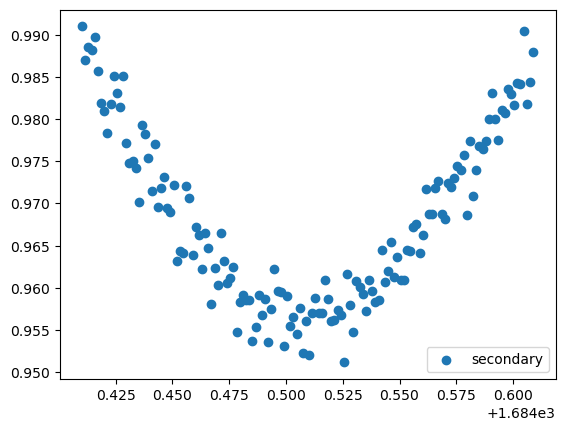

1684.5089 2.045201 1686.554101


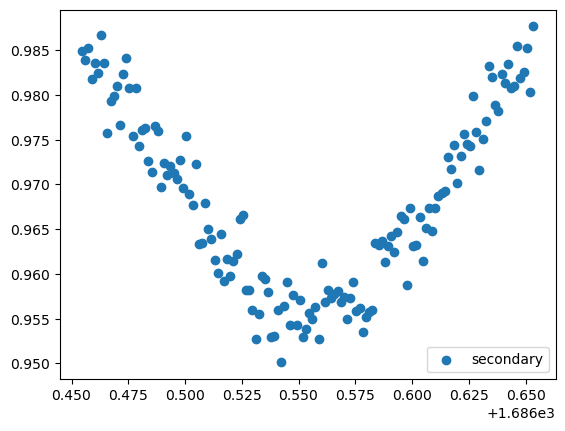

1684.5089 2.045201 1688.599302


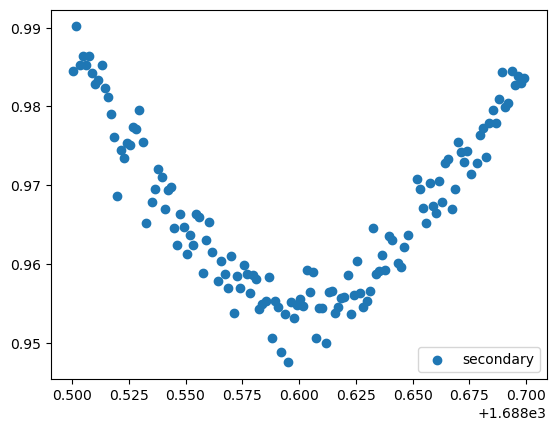

In [36]:
tr_index = range(0,n_transits)

for i in tr_index[0:3]:        
    transit_time = t0_primary+(period*i)
    x = np.array(data_primary.time)
    y = np.array(data_primary.flux) 
    yerr = np.array(data_primary.err)
    
    print (t0_primary, period, transit_time)
    
    mask = (x > (transit_time - (0.2*period))) & (x < (transit_time + (0.2*period))) 
    
    x = np.array(x[mask])
    y = np.array(y[mask]) 
    yerr = np.array(yerr[mask])
    fig, ax = plt.subplots()
    plt.scatter(x,y, label="primary")
    plt.legend(loc="lower right")
    plt.show()
    

if t0_secondary is not None:
    for i in tr_index[0:3]:        
        transit_time = t0_secondary+(period*i)
        x = np.array(data_secondary.time)
        y = np.array(data_secondary.flux) 
        yerr = np.array(data_secondary.err)
        
        print (t0_secondary, period, transit_time)
        
        mask = (x > (transit_time - (0.2*period))) & (x < (transit_time + (0.2*period))) 
        
        x = np.array(x[mask])
        y = np.array(y[mask]) 
        yerr = np.array(yerr[mask])
        fig, ax = plt.subplots()
        plt.scatter(x,y, label="secondary")
        plt.legend(loc="lower right")
        plt.show()

### Fit indiviudla eclipses


In [37]:
# Provide a warning if the expected number of data points per clipped LC is smaller than the default minimum `min_number_data` (20)
longest_cadence = np.max(sr.exptime)
est_number_data_primary   = int(duration_hr_primary / longest_cadence.to(u.hr).value)
est_number_data_secondary = int(duration_hr_secondary / longest_cadence.to(u.hr).value)
print(f"Expected num of data points of a clipped LC in longest cadence ({longest_cadence}): {est_number_data_primary} / {est_number_data_secondary}")
if est_number_data_primary < 20:
    display(HTML("<span style='background-color: rgba(255, 0, 0, 0.7); padding-left: 1ch; padding-right: 1ch;'>WARN:</span> num of data points for a clipped LC (primary) < 20"))
if est_number_data_secondary < 20:
    display(HTML("<span style='background-color: rgba(255, 0, 0, 0.7); padding-left: 1ch; padding-right: 1ch;'>WARN:</span> num of data points for a clipped LC (secondary) < 20"))

Expected num of data points of a clipped LC in longest cadence (120.0 s): 180 / 180


Fitting individual primary eclipses...
Existing manifest file found, will skip previously processed LCs and append to end of manifest file
Number 0 has already been completed -- skip
1685.526101 1.0093344572022414 -0.2568461113627834 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:29<00:00, 341.82it/s]


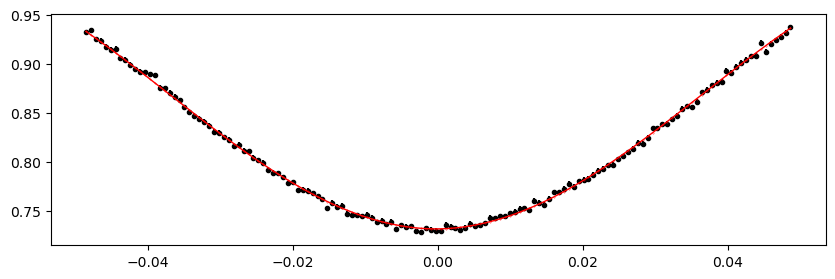

1687.571302 1.0093344572022414 -0.2568461113627834 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:31<00:00, 319.73it/s]


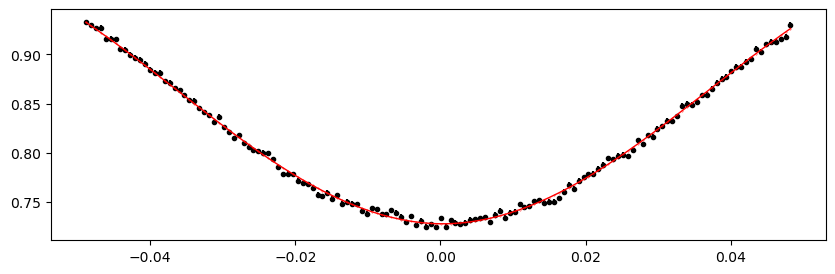

1689.616503 1.0093344572022414 -0.2568461113627834 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:29<00:00, 335.30it/s]


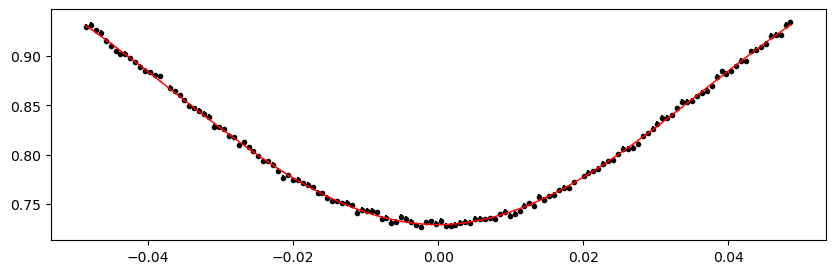

1691.661704 1.0093344572022414 -0.2568461113627834 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:32<00:00, 312.16it/s]


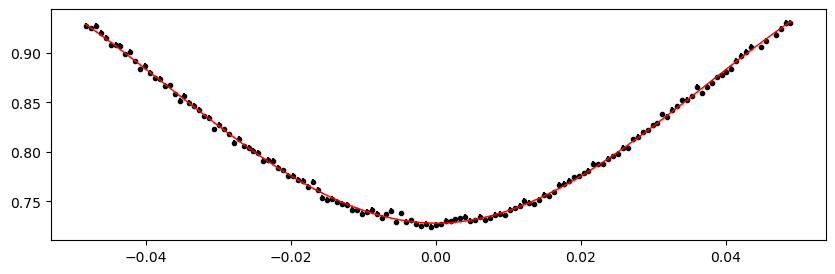

1693.706905 1.0093344572022414 -0.2568461113627834 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:29<00:00, 338.39it/s]


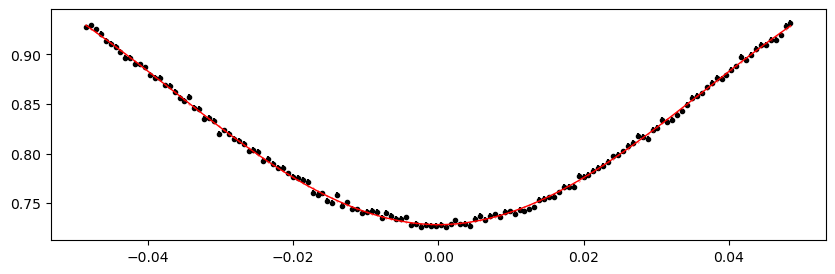

1695.752106 1.0093344572022414 -0.2568461113627834 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:29<00:00, 340.03it/s]


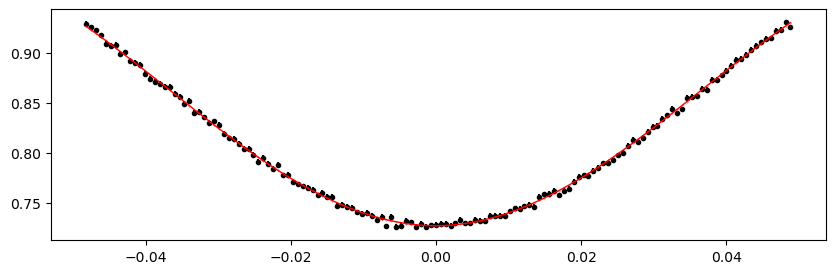

1697.797307 1.0093344572022414 -0.2568461113627834 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:30<00:00, 332.23it/s]


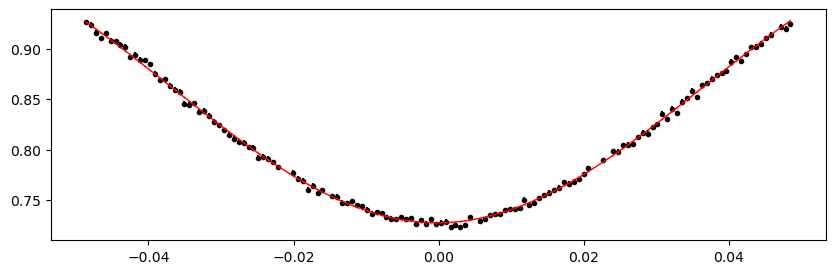

1699.842508 1.0093344572022414 -0.2568461113627834 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:30<00:00, 330.72it/s]


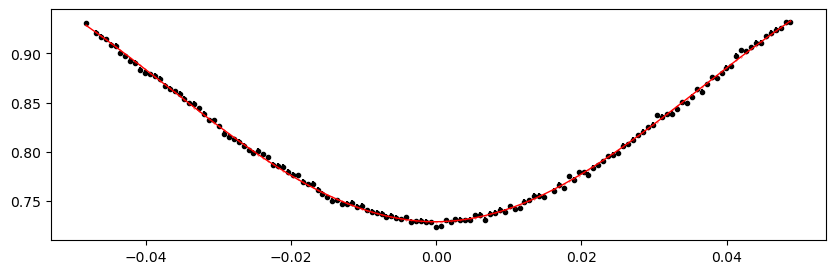

1701.887709 1.0093344572022414 -0.2568461113627834 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:29<00:00, 338.77it/s]


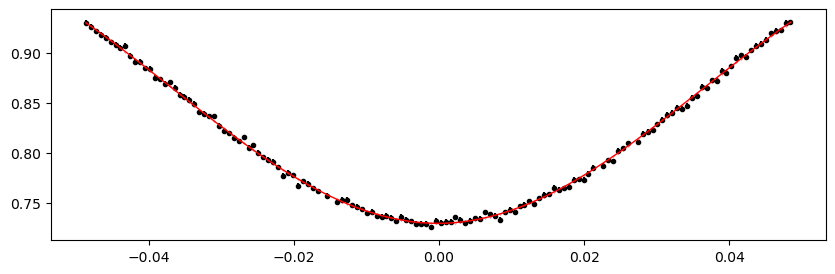

1703.93291 1.0093344572022414 -0.2568461113627834 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:29<00:00, 339.88it/s]


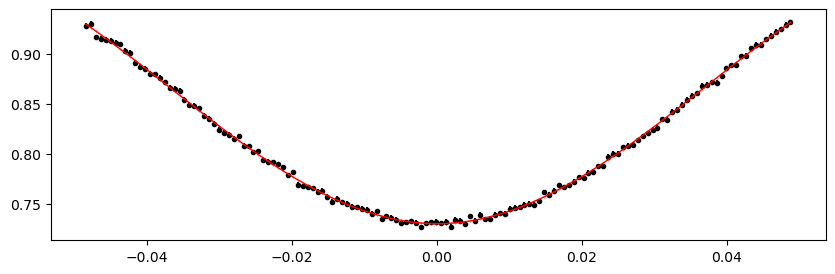

1705.9781110000001 1.0093344572022414 -0.2568461113627834 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:29<00:00, 339.73it/s]


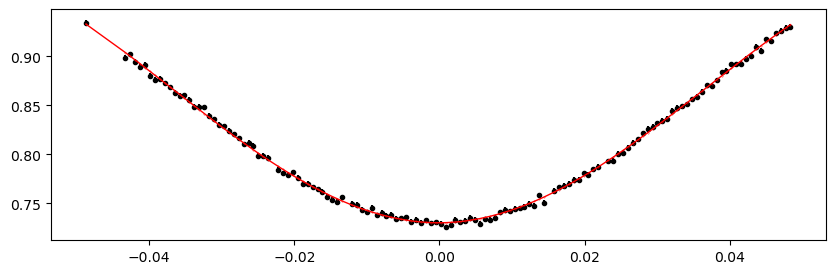

1708.023312 1.0093344572022414 -0.2568461113627834 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:29<00:00, 342.14it/s]


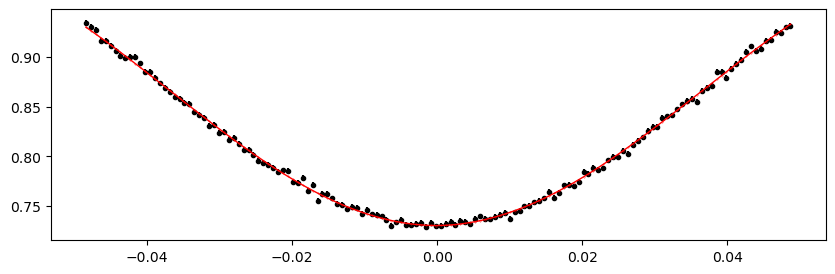

1710.068513 1.0093344572022414 -0.2568461113627834 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:29<00:00, 337.19it/s]


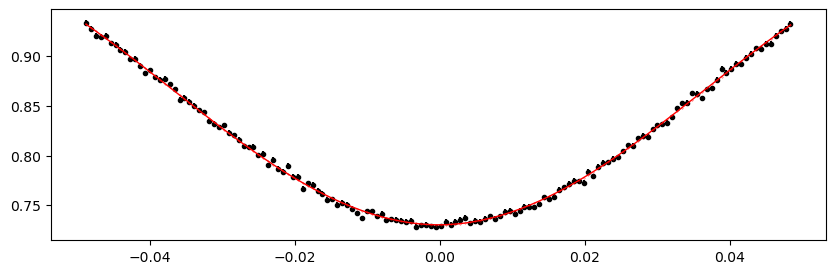

1712.113714 1.0093344572022414 -0.2568461113627834 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:31<00:00, 317.94it/s]


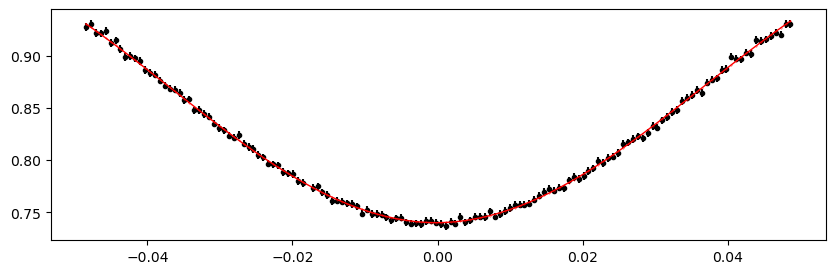

1714.158915 1.0093344572022414 -0.2568461113627834 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:29<00:00, 333.39it/s]


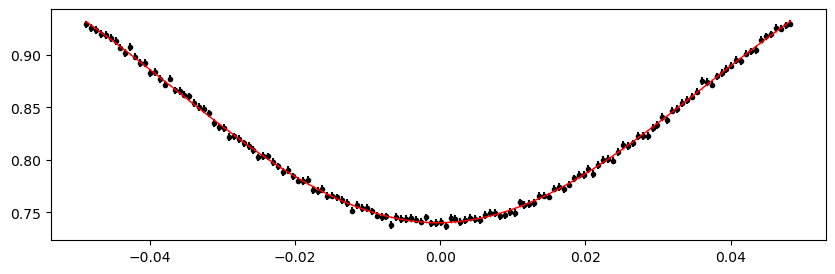

1716.204116 1.0093344572022414 -0.2568461113627834 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:29<00:00, 338.57it/s]


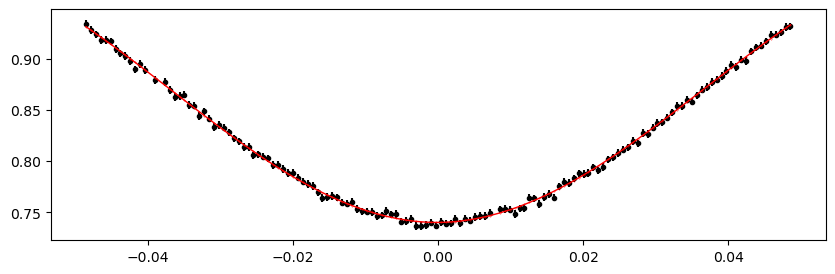

1718.249317 1.0093344572022414 -0.2568461113627834 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:29<00:00, 337.66it/s]


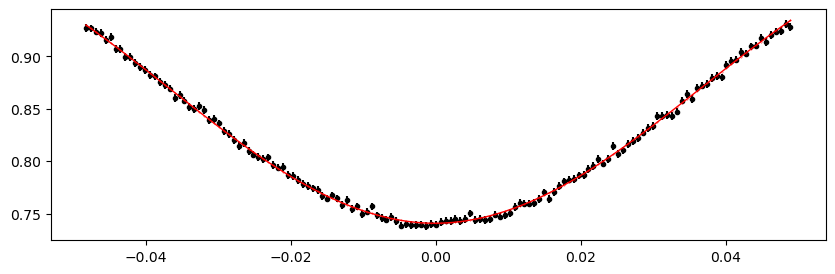

1720.294518 1.0093344572022414 -0.2568461113627834 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:29<00:00, 335.43it/s]


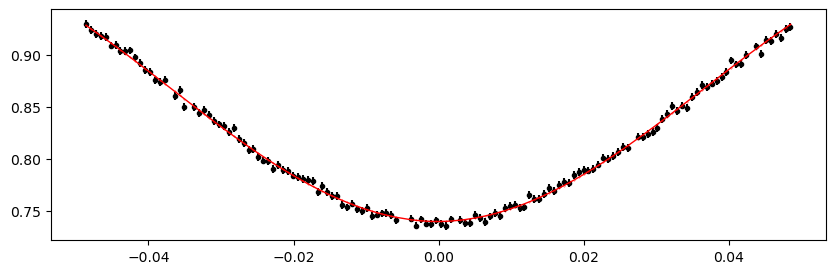

1722.339719 1.0093344572022414 -0.2568461113627834 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:30<00:00, 330.78it/s]


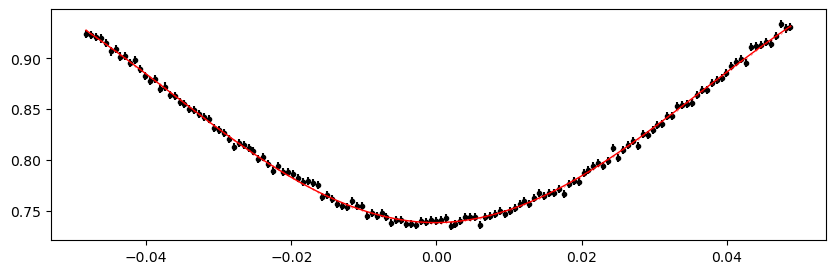

1726.430121 1.0093344572022414 -0.2568461113627834 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:30<00:00, 328.02it/s]


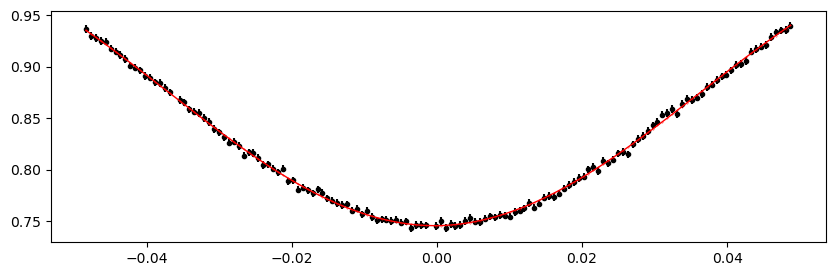

1728.475322 1.0093344572022414 -0.2568461113627834 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:30<00:00, 331.87it/s]


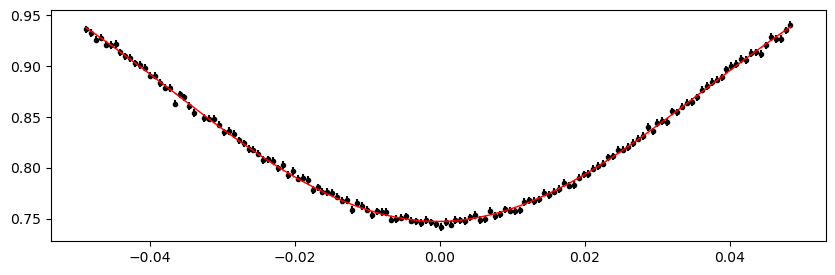

1730.520523 1.0093344572022414 -0.2568461113627834 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:29<00:00, 342.69it/s]


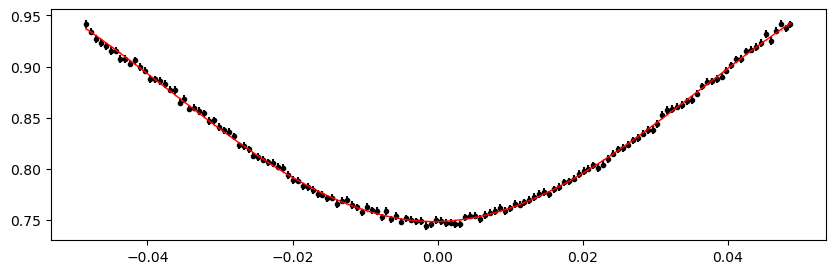

1732.565724 1.0093344572022414 -0.2568461113627834 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:30<00:00, 332.71it/s]


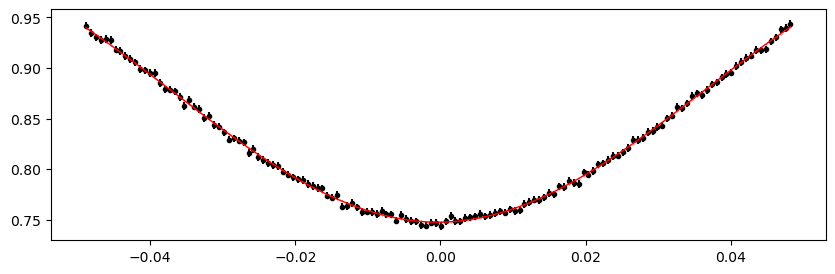

1734.610925 1.0093344572022414 -0.2568461113627834 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:29<00:00, 335.68it/s]


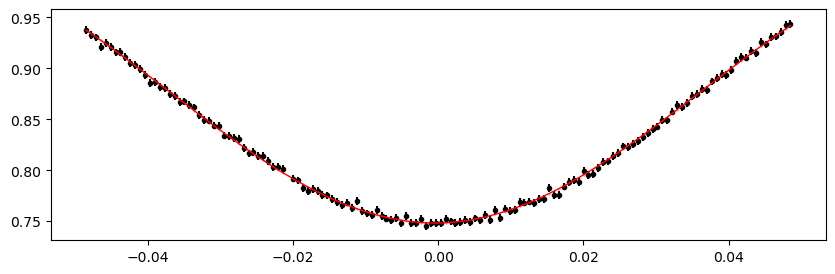

1736.656126 1.0093344572022414 -0.2568461113627834 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:29<00:00, 339.59it/s]


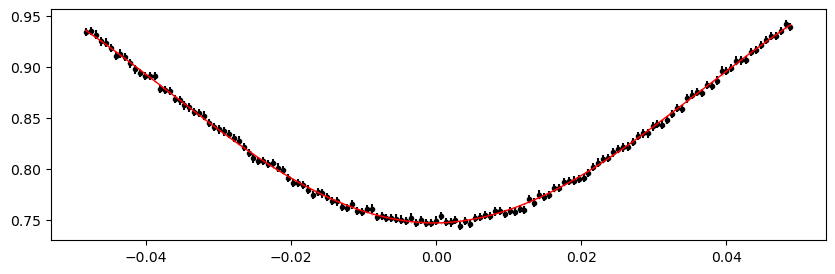

2421.7984610000003 1.0093344572022414 -0.2568461113627834 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:29<00:00, 341.54it/s]


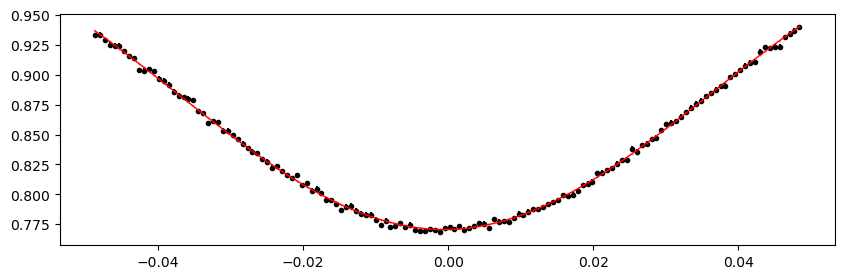

2423.843662 1.0093344572022414 -0.2568461113627834 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:29<00:00, 340.86it/s]


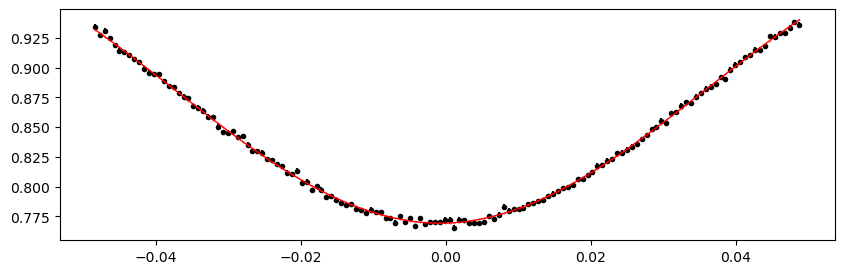

2425.888863 1.0093344572022414 -0.2568461113627834 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:29<00:00, 343.33it/s]


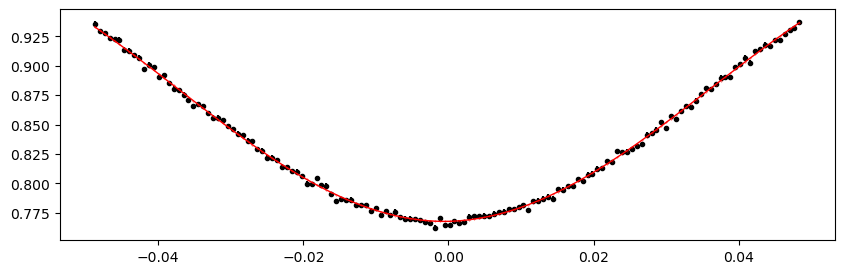

2427.934064 1.0093344572022414 -0.2568461113627834 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:29<00:00, 343.00it/s]


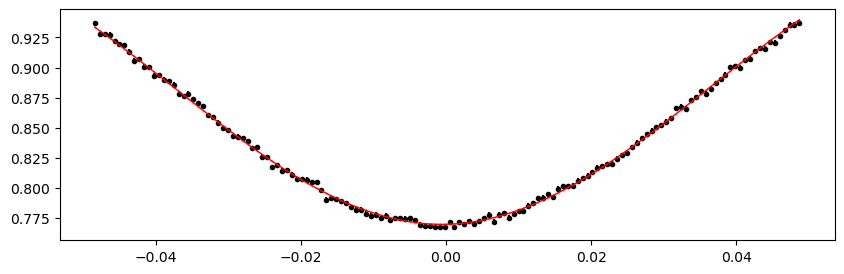

2429.979265 1.0093344572022414 -0.2568461113627834 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:29<00:00, 339.56it/s]


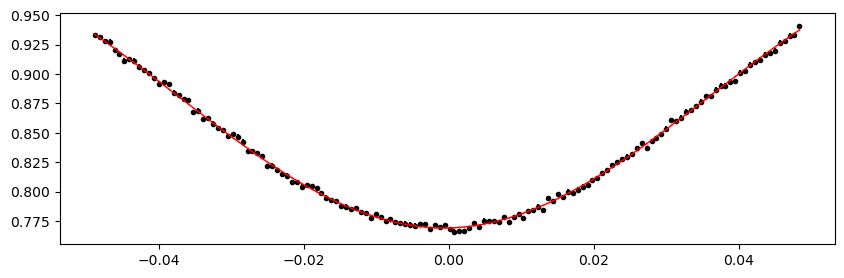

2432.024466 1.0093344572022414 -0.2568461113627834 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:29<00:00, 341.56it/s]


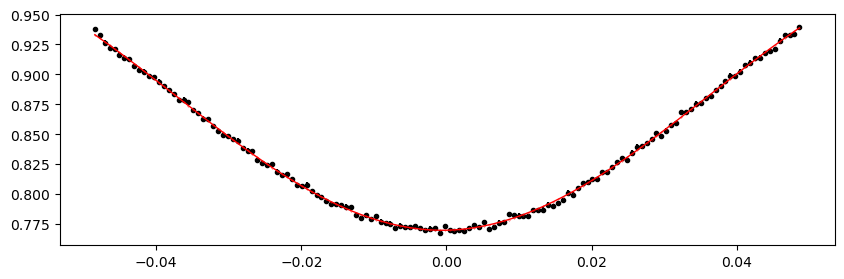

2434.0696669999998 1.0093344572022414 -0.2568461113627834 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:30<00:00, 331.88it/s]


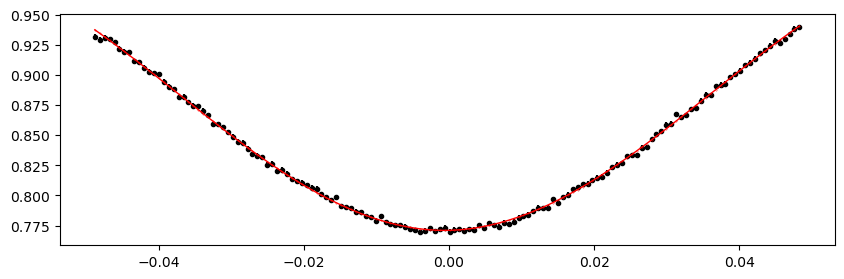

2436.114868 1.0093344572022414 -0.2568461113627834 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:29<00:00, 335.30it/s]


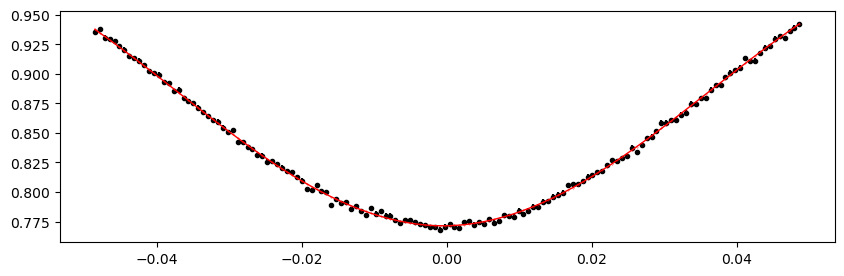

2438.160069 1.0093344572022414 -0.2568461113627834 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:31<00:00, 316.25it/s]


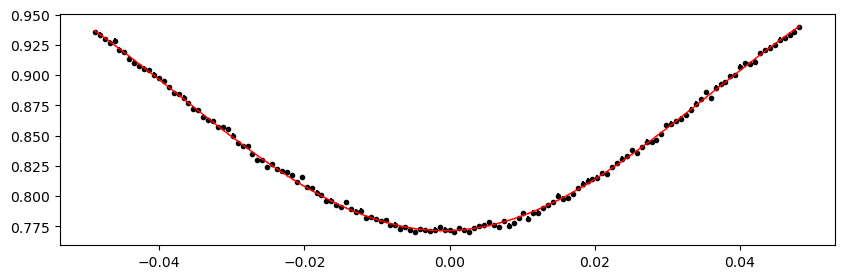

2440.20527 1.0093344572022414 -0.2568461113627834 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:29<00:00, 344.25it/s]


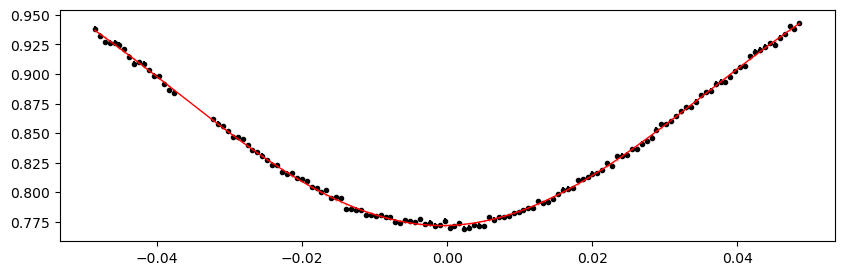

2442.2504710000003 1.0093344572022414 -0.2568461113627834 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:29<00:00, 336.10it/s]


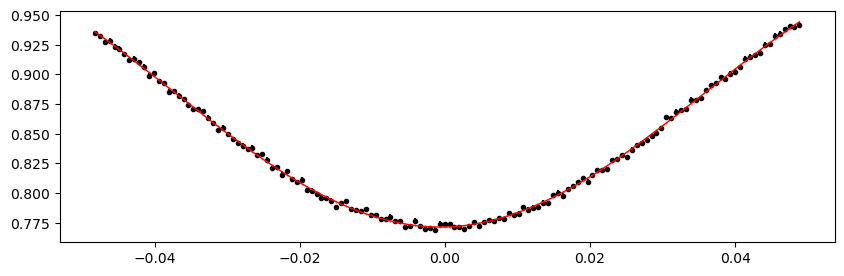

2444.295672 1.0093344572022414 -0.2568461113627834 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:29<00:00, 338.31it/s]


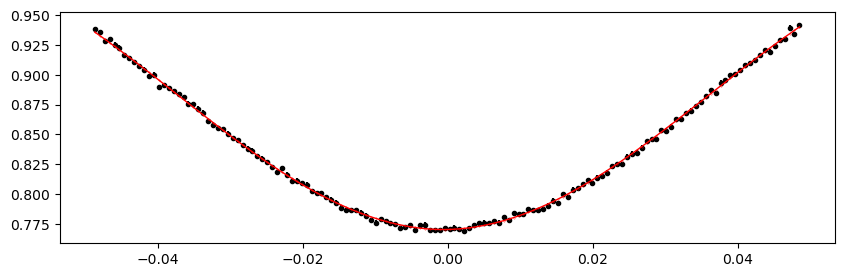

2446.340873 1.0093344572022414 -0.2568461113627834 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:29<00:00, 334.29it/s]


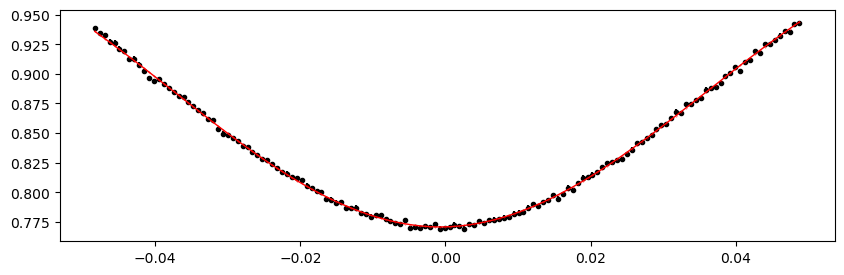

2771.5278319999998 1.0093344572022414 -0.2568461113627834 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:29<00:00, 337.01it/s]


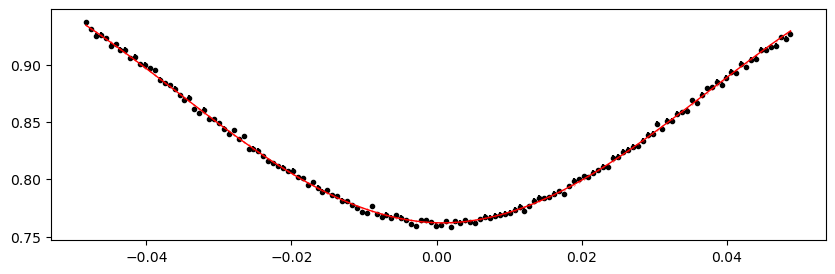

2773.573033 1.0093344572022414 -0.2568461113627834 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:30<00:00, 332.97it/s]


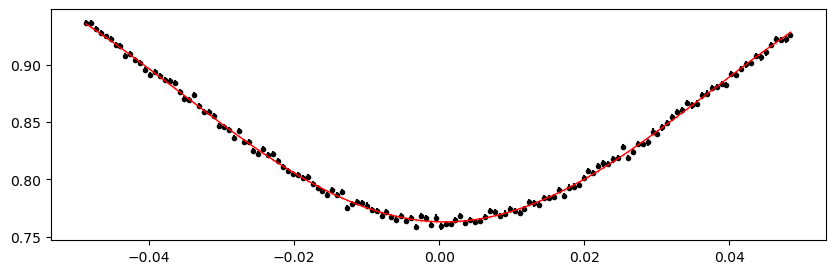

2775.618234 1.0093344572022414 -0.2568461113627834 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:30<00:00, 328.57it/s]


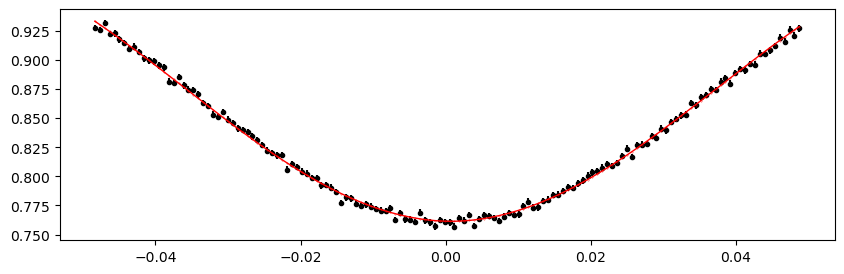

2777.663435 1.0093344572022414 -0.2568461113627834 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:33<00:00, 299.08it/s]


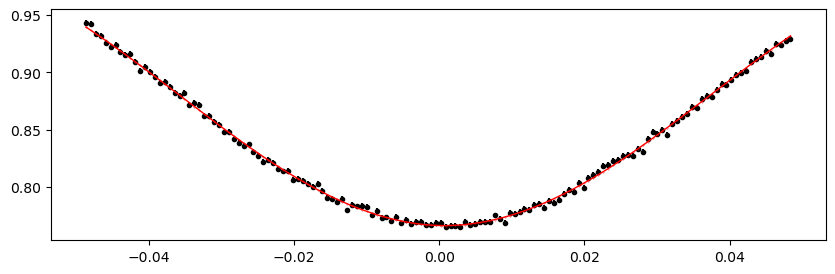

2779.7086360000003 1.0093344572022414 -0.2568461113627834 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:29<00:00, 343.12it/s]


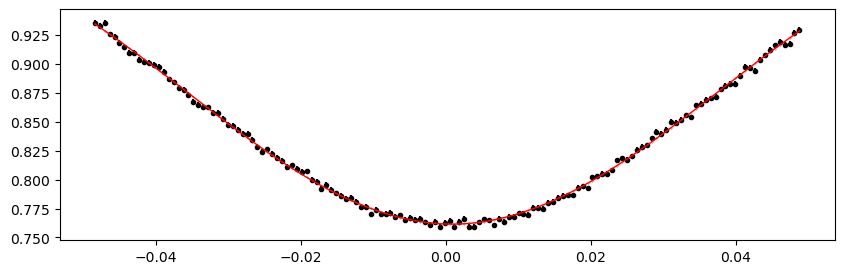

2781.753837 1.0093344572022414 -0.2568461113627834 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:29<00:00, 340.90it/s]


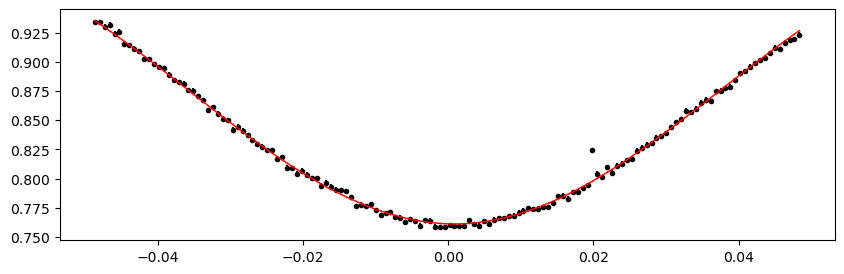

2783.799038 1.0093344572022414 -0.2568461113627834 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:29<00:00, 336.16it/s]


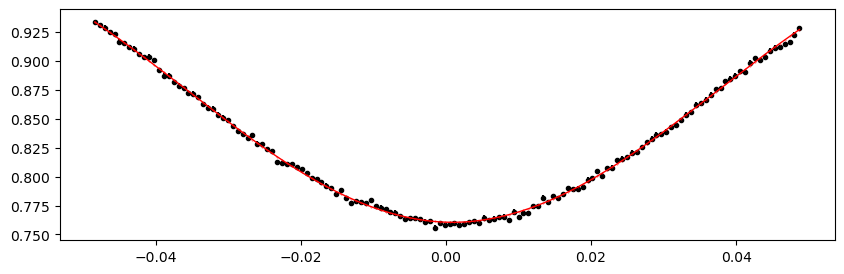

2785.844239 1.0093344572022414 -0.2568461113627834 0


100%|██████████████████████████████████████████████████████| 10000/10000 [2:21:57<00:00,  1.17it/s]


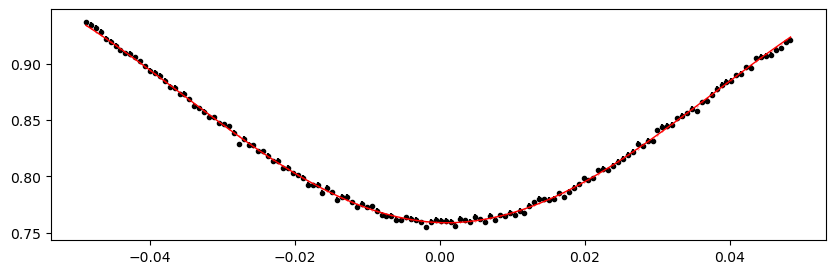

2787.88944 1.0093344572022414 -0.2568461113627834 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:30<00:00, 325.16it/s]


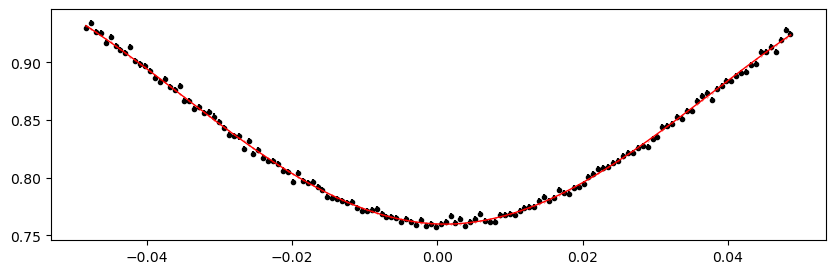

2789.934641 1.0093344572022414 -0.2568461113627834 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:29<00:00, 333.96it/s]


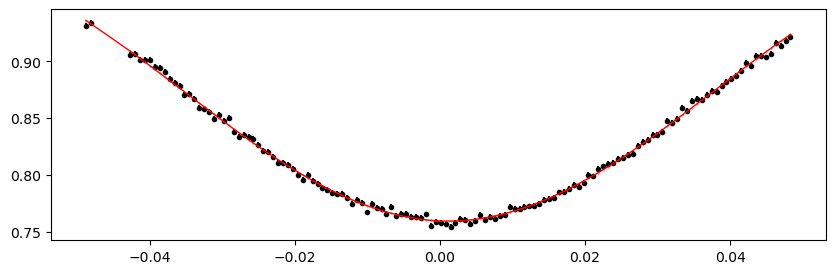

2791.9798419999997 1.0093344572022414 -0.2568461113627834 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:30<00:00, 332.57it/s]


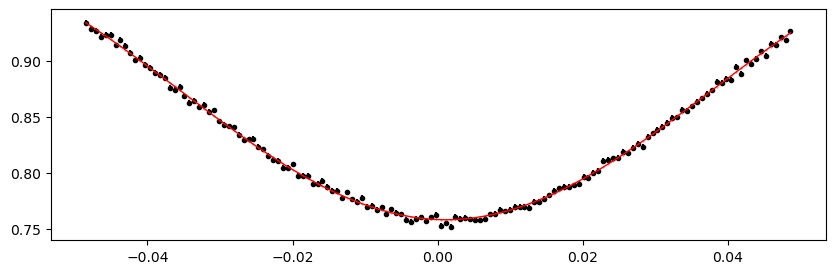

2794.025043 1.0093344572022414 -0.2568461113627834 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:29<00:00, 341.73it/s]


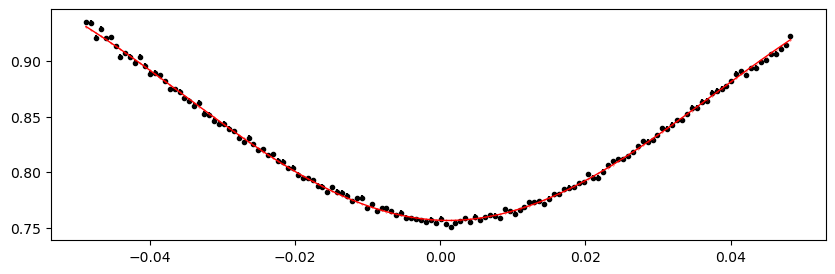

2796.070244 1.0093344572022414 -0.2568461113627834 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:27<00:00, 364.76it/s]


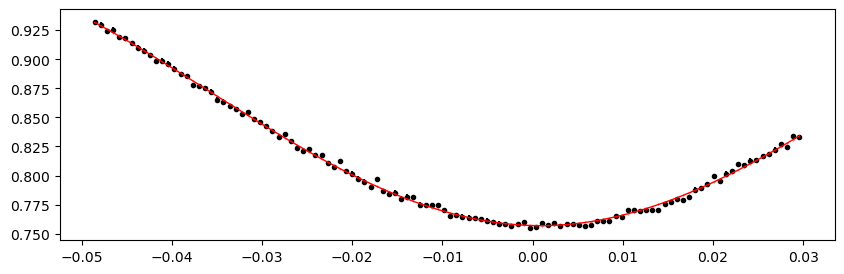

2826.748259 1.0093344572022414 -0.2568461113627834 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:34<00:00, 290.99it/s]


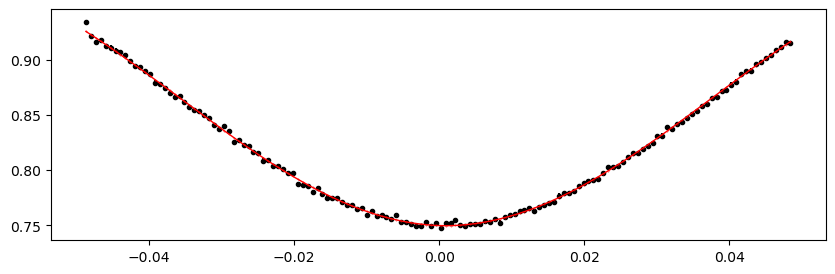

2828.79346 1.0093344572022414 -0.2568461113627834 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:29<00:00, 338.27it/s]


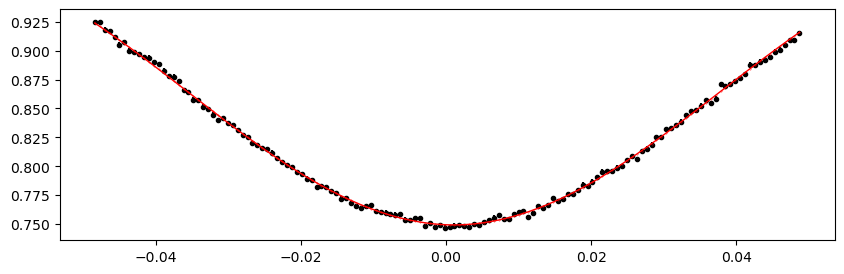

2830.838661 1.0093344572022414 -0.2568461113627834 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:29<00:00, 338.37it/s]


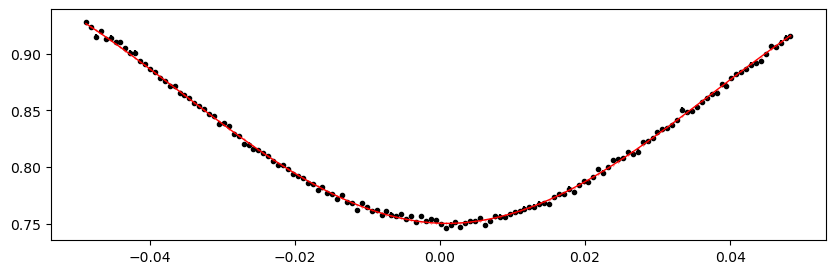

2832.883862 1.0093344572022414 -0.2568461113627834 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:29<00:00, 338.73it/s]


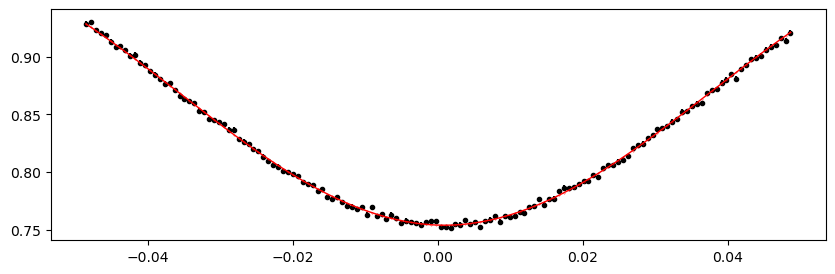

2834.929063 1.0093344572022414 -0.2568461113627834 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:29<00:00, 335.60it/s]


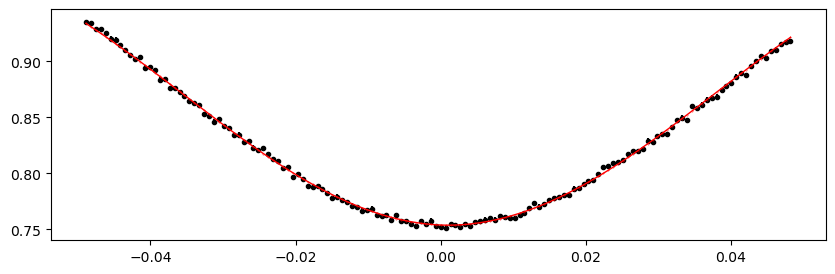

2836.974264 1.0093344572022414 -0.2568461113627834 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:30<00:00, 330.56it/s]


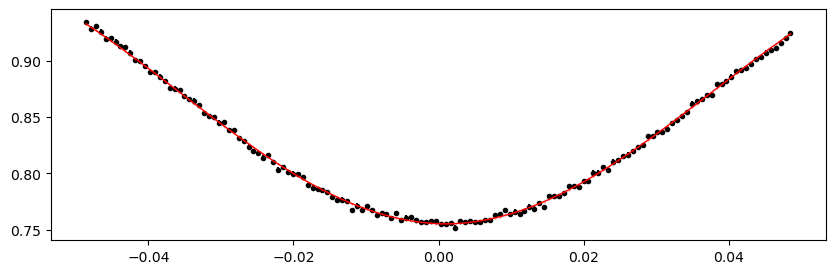

2839.0194650000003 1.0093344572022414 -0.2568461113627834 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:30<00:00, 327.30it/s]


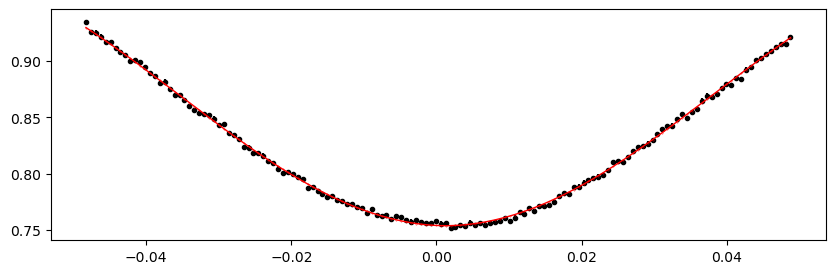

2841.064666 1.0093344572022414 -0.2568461113627834 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:29<00:00, 335.35it/s]


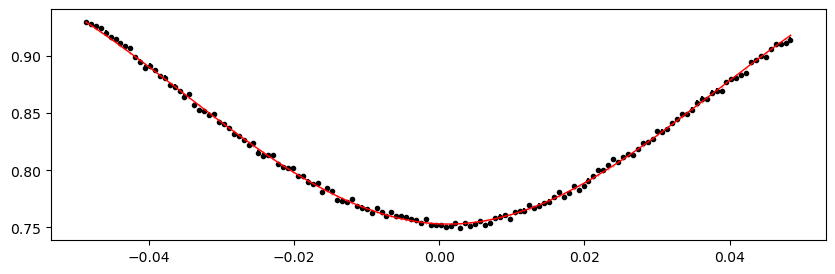

2843.109867 1.0093344572022414 -0.2568461113627834 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:29<00:00, 337.63it/s]


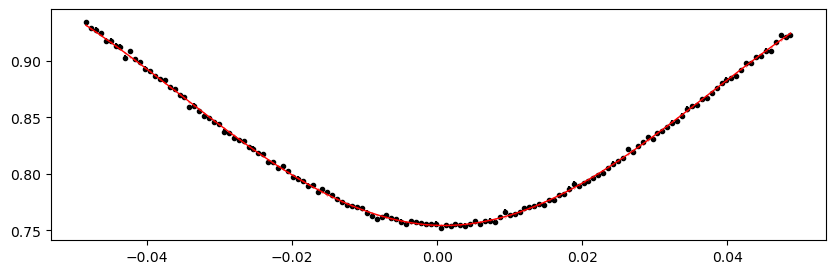

2845.155068 1.0093344572022414 -0.2568461113627834 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:29<00:00, 337.14it/s]


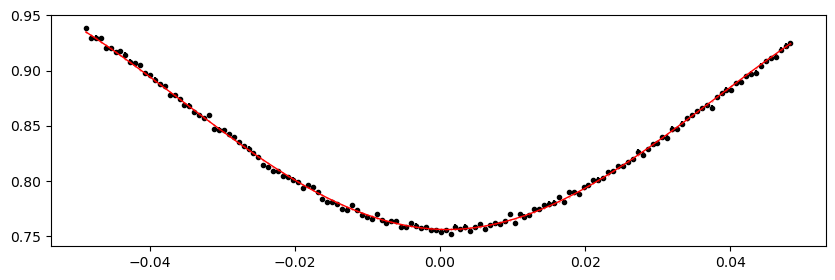

2847.200269 1.0093344572022414 -0.2568461113627834 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:30<00:00, 328.92it/s]


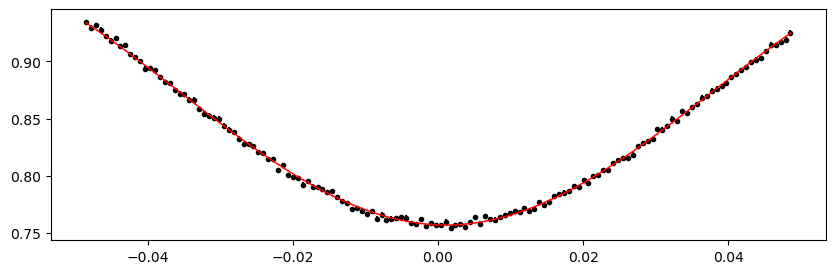

2849.24547 1.0093344572022414 -0.2568461113627834 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:30<00:00, 327.51it/s]


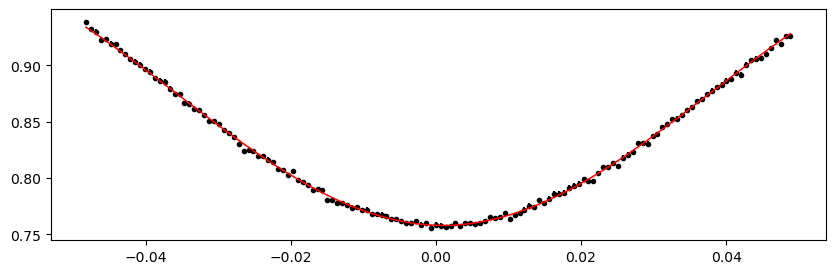

2851.2906709999997 1.0093344572022414 -0.2568461113627834 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:30<00:00, 323.88it/s]


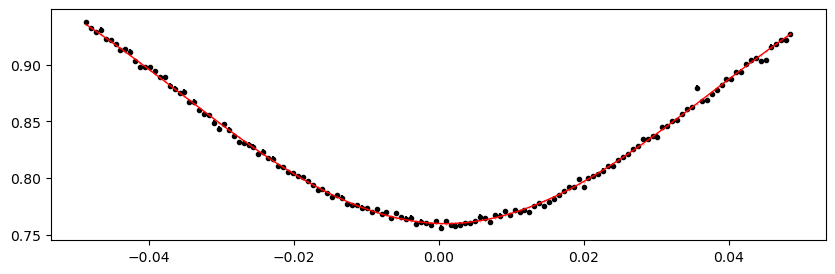

3368.726524 1.0093344572022414 -0.2568461113627834 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:29<00:00, 333.64it/s]


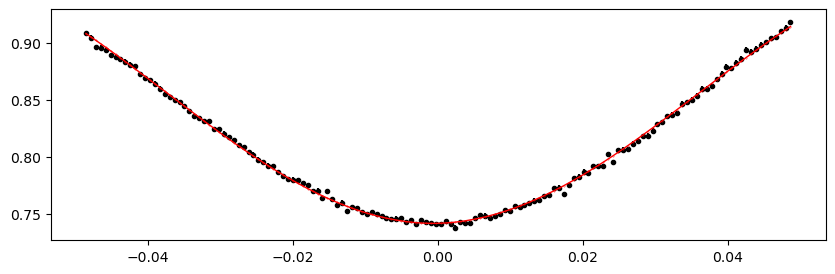

3370.771725 1.0093344572022414 -0.2568461113627834 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:30<00:00, 328.16it/s]


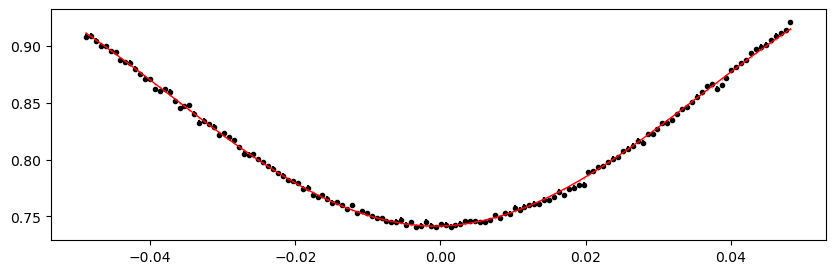

3372.816926 1.0093344572022414 -0.2568461113627834 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:30<00:00, 333.24it/s]


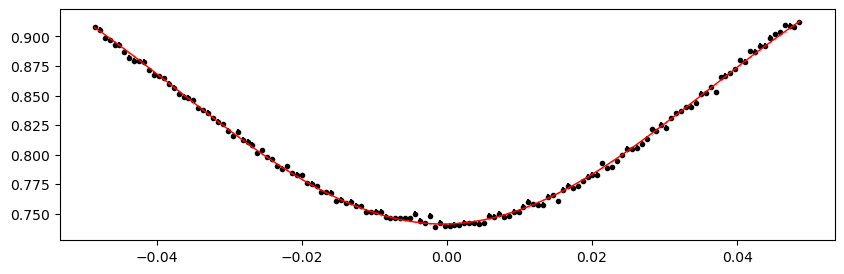

3374.8621270000003 1.0093344572022414 -0.2568461113627834 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:30<00:00, 327.59it/s]


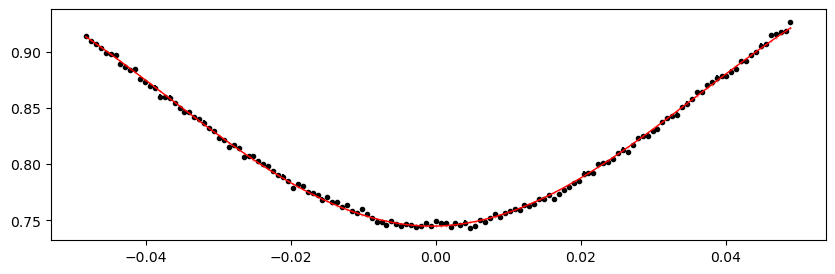

3376.9073280000002 1.0093344572022414 -0.2568461113627834 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:30<00:00, 329.78it/s]


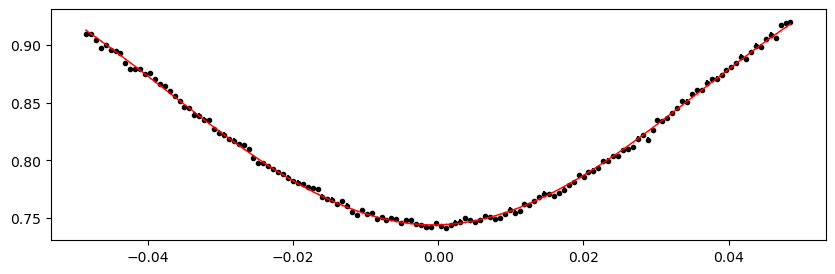

3378.952529 1.0093344572022414 -0.2568461113627834 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:30<00:00, 329.58it/s]


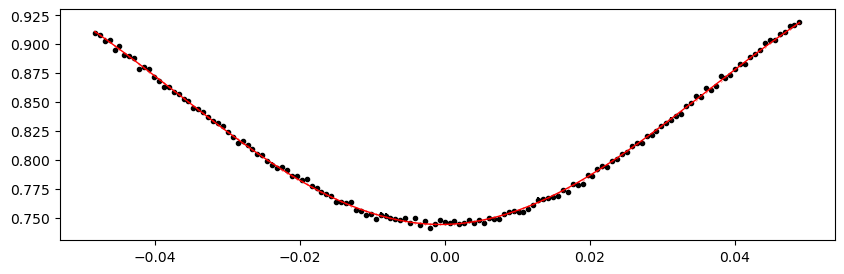

3380.99773 1.0093344572022414 -0.2568461113627834 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:29<00:00, 337.01it/s]


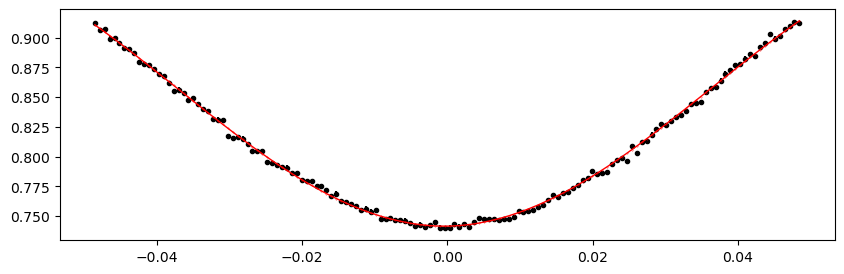

3383.042931 1.0093344572022414 -0.2568461113627834 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:30<00:00, 331.73it/s]


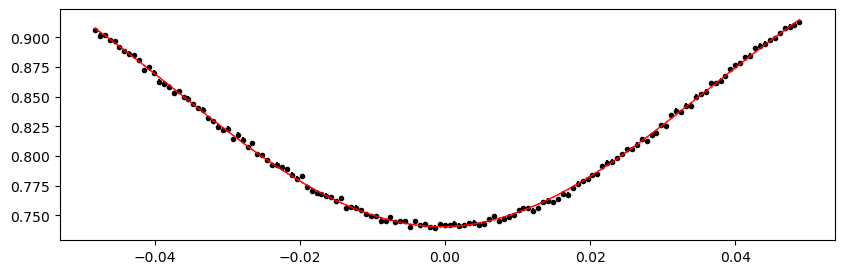

3385.088132 1.0093344572022414 -0.2568461113627834 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:30<00:00, 332.39it/s]


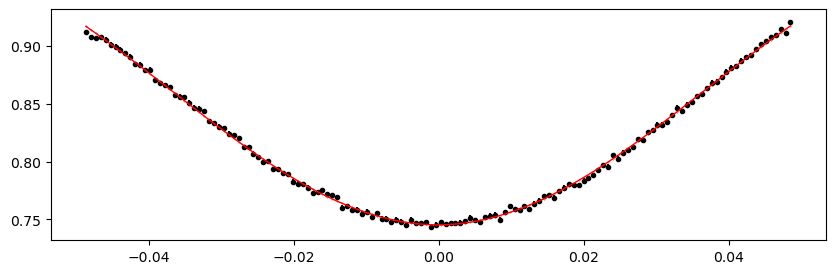

3387.1333329999998 1.0093344572022414 -0.2568461113627834 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:30<00:00, 330.46it/s]


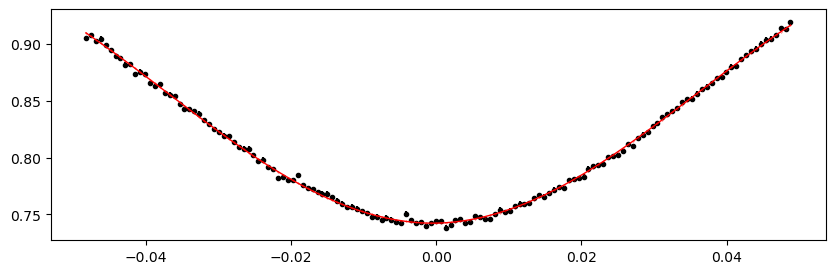

3389.178534 1.0093344572022414 -0.2568461113627834 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:32<00:00, 309.77it/s]


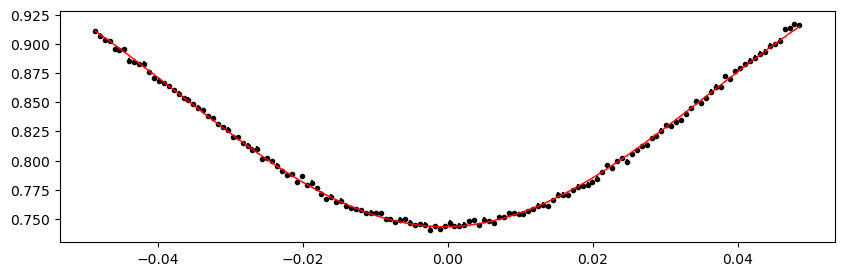

3391.223735 1.0093344572022414 -0.2568461113627834 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:30<00:00, 329.03it/s]


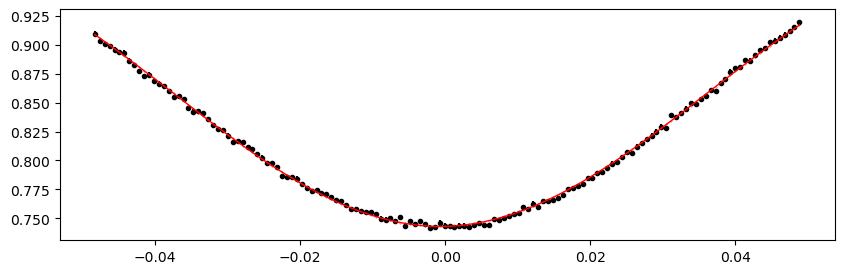

In [40]:
%matplotlib inline

# from importlib import reload
# reload(etv_functions)

print("Fitting individual primary eclipses...")
etv_functions.fit_each_eclipse(data_primary, n_transits, t0_primary, period, mean_alpha0, mean_alpha1, mean_t0, mean_d, mean_Tau, outfile_path,
                               min_number_data=20,
                              )
!$NOTIFY_CMD "Individual primary eclipses fit done"


Fitting individual secondary eclipses...
Existing manifest file found, will skip previously processed LCs and append to end of manifest file
Number 0 has already been completed -- skip
1686.554101 1.0091451011936945 -0.03773387812646225 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:30<00:00, 330.58it/s]


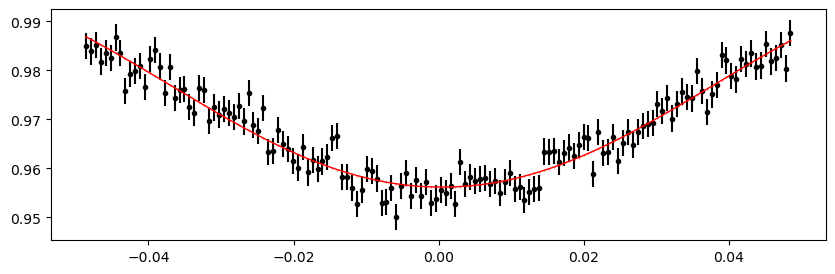

1688.599302 1.0091451011936945 -0.03773387812646225 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:30<00:00, 328.74it/s]


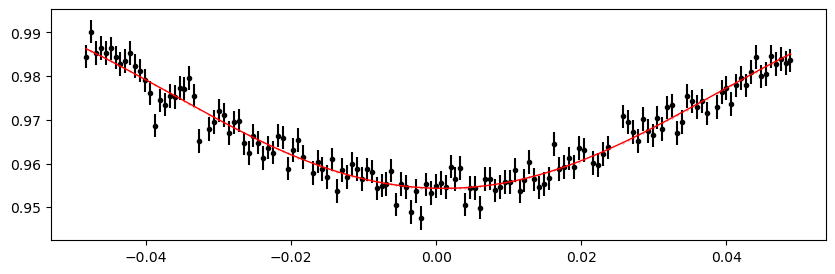

1690.644503 1.0091451011936945 -0.03773387812646225 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:29<00:00, 333.62it/s]


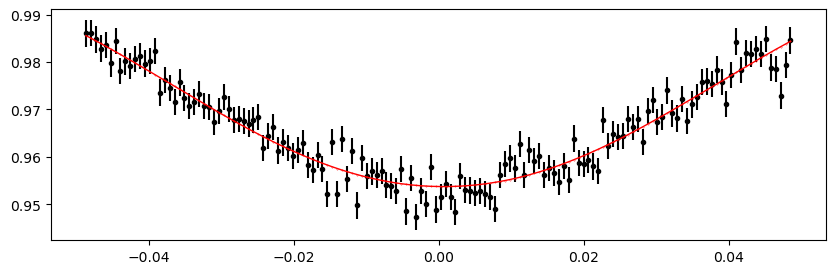

1692.6897040000001 1.0091451011936945 -0.03773387812646225 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:29<00:00, 338.82it/s]


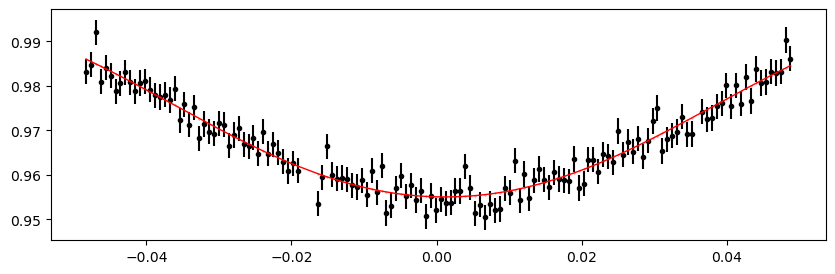

1694.734905 1.0091451011936945 -0.03773387812646225 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:29<00:00, 336.94it/s]


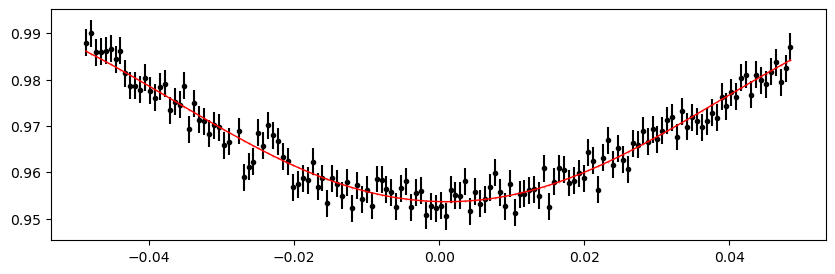

1698.825307 1.0091451011936945 -0.03773387812646225 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:29<00:00, 333.81it/s]


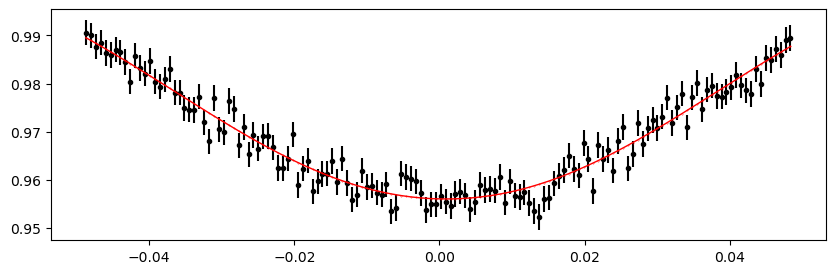

1700.870508 1.0091451011936945 -0.03773387812646225 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:30<00:00, 330.73it/s]


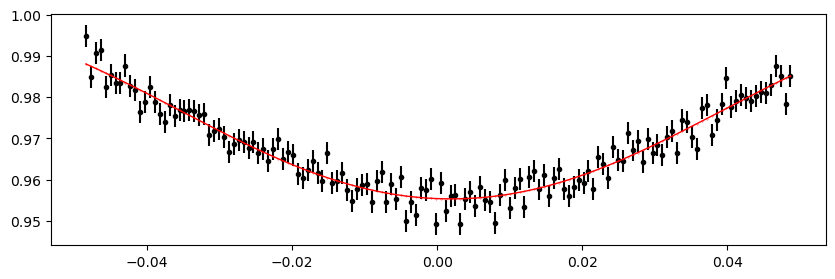

1702.915709 1.0091451011936945 -0.03773387812646225 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:30<00:00, 329.27it/s]


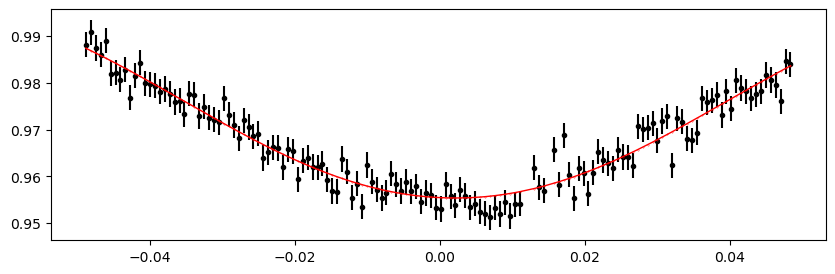

1704.96091 1.0091451011936945 -0.03773387812646225 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:30<00:00, 332.43it/s]


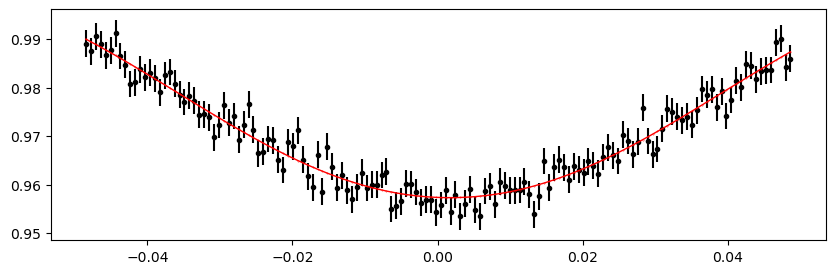

1707.0061110000001 1.0091451011936945 -0.03773387812646225 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:29<00:00, 335.56it/s]


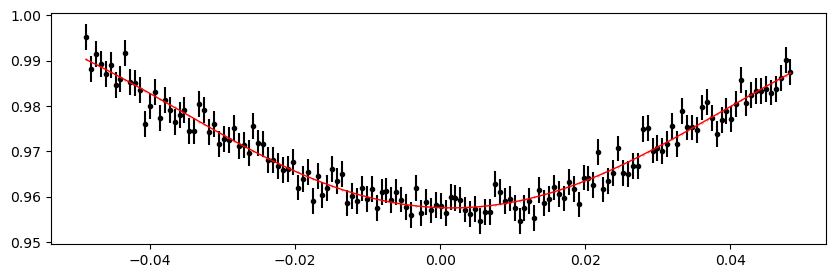

1709.051312 1.0091451011936945 -0.03773387812646225 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:30<00:00, 330.24it/s]


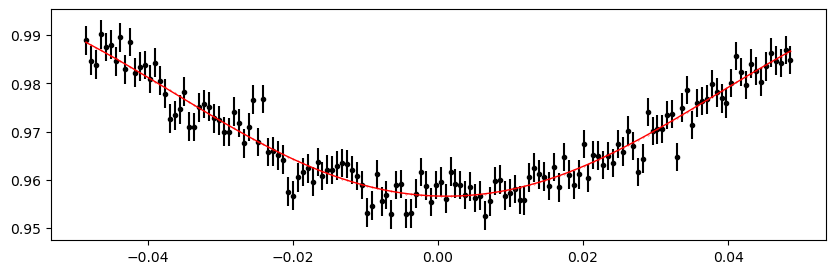

1713.141714 1.0091451011936945 -0.03773387812646225 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:29<00:00, 338.07it/s]


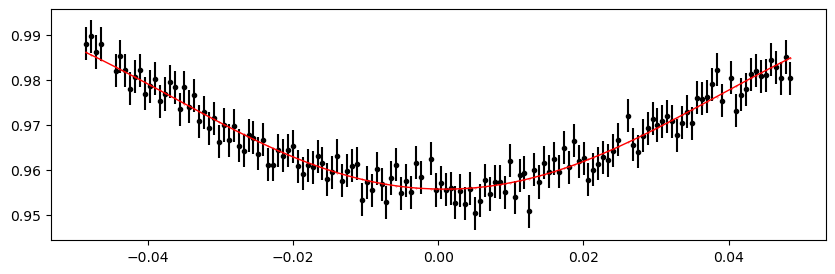

1715.186915 1.0091451011936945 -0.03773387812646225 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:29<00:00, 336.43it/s]


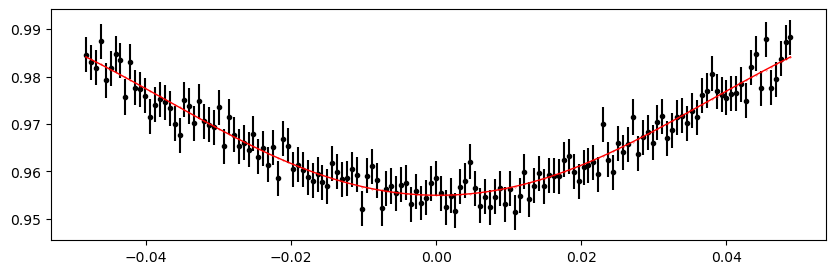

1717.2321160000001 1.0091451011936945 -0.03773387812646225 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:29<00:00, 336.47it/s]


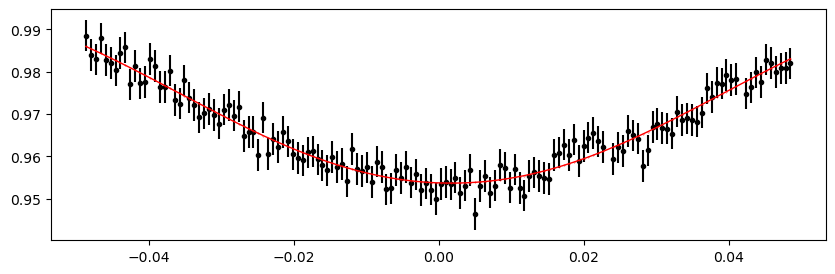

1719.277317 1.0091451011936945 -0.03773387812646225 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:29<00:00, 334.13it/s]


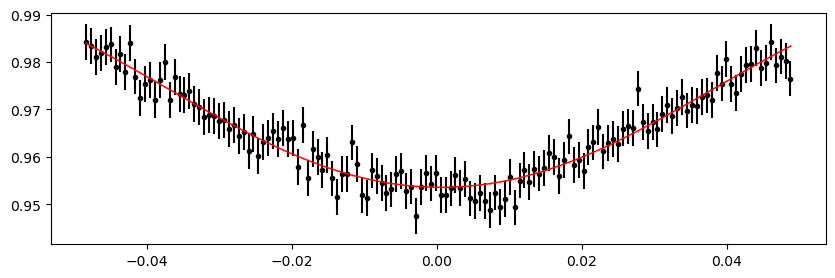

1721.322518 1.0091451011936945 -0.03773387812646225 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:29<00:00, 336.48it/s]


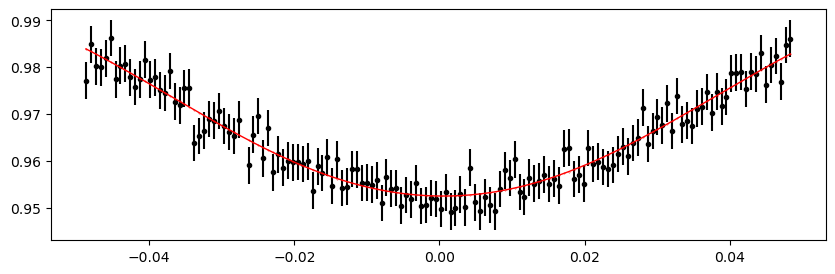

1723.367719 1.0091451011936945 -0.03773387812646225 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:30<00:00, 332.67it/s]


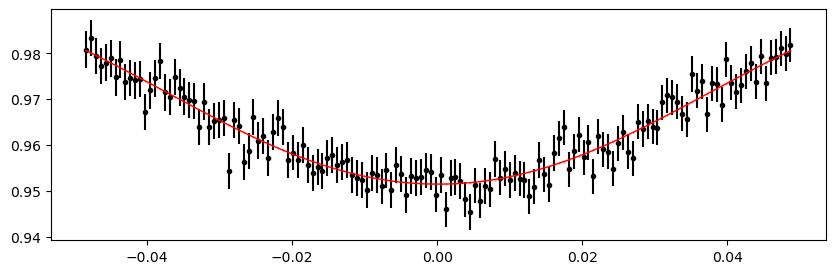

1725.41292 1.0091451011936945 -0.03773387812646225 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:29<00:00, 337.02it/s]


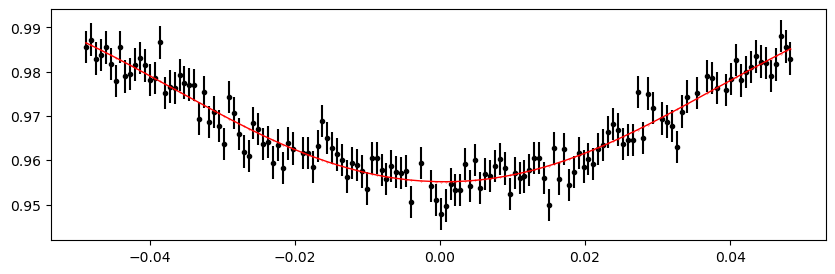

1727.4581210000001 1.0091451011936945 -0.03773387812646225 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:29<00:00, 336.00it/s]


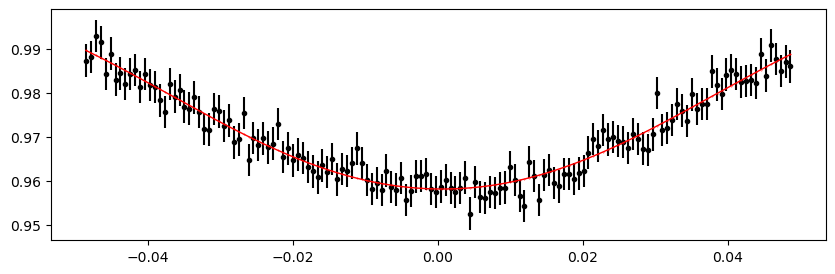

1729.503322 1.0091451011936945 -0.03773387812646225 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:29<00:00, 337.88it/s]


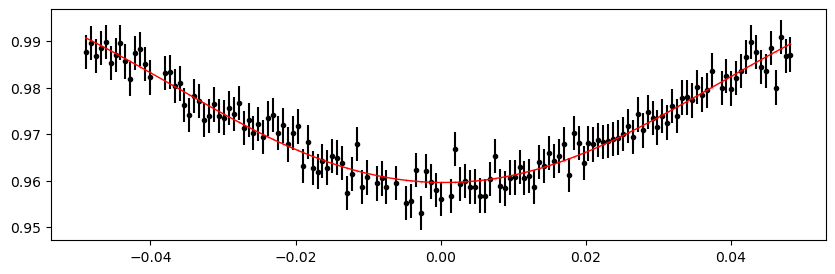

1731.548523 1.0091451011936945 -0.03773387812646225 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:29<00:00, 335.00it/s]


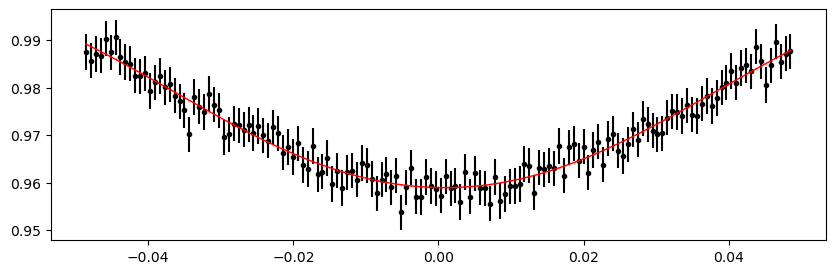

1733.593724 1.0091451011936945 -0.03773387812646225 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:29<00:00, 335.87it/s]


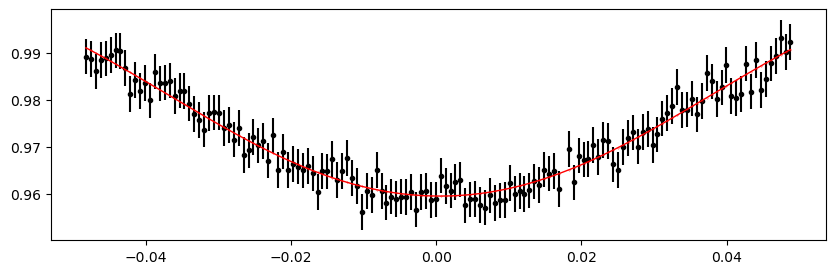

1735.638925 1.0091451011936945 -0.03773387812646225 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:29<00:00, 336.47it/s]


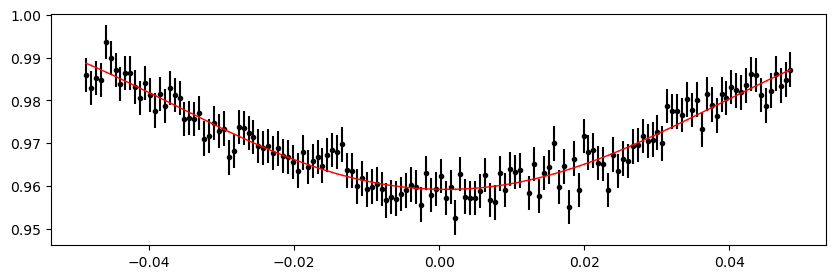

2420.78126 1.0091451011936945 -0.03773387812646225 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:29<00:00, 338.53it/s]


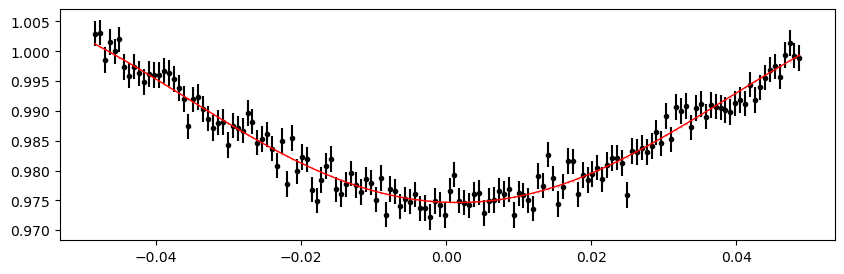

2422.826461 1.0091451011936945 -0.03773387812646225 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:29<00:00, 336.95it/s]


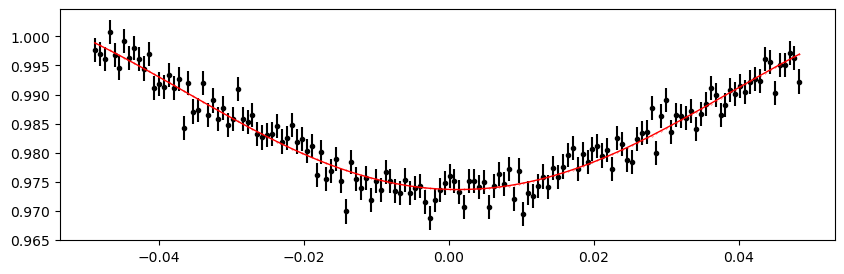

2424.871662 1.0091451011936945 -0.03773387812646225 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:29<00:00, 337.24it/s]


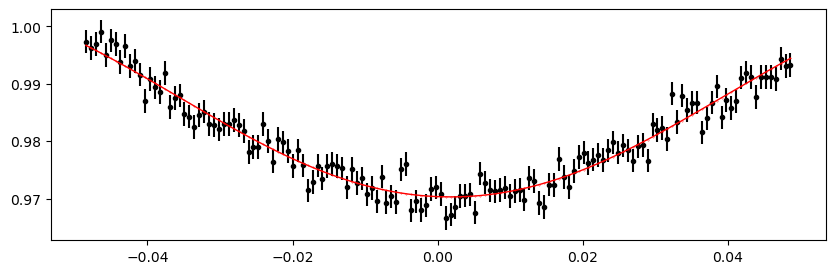

2426.916863 1.0091451011936945 -0.03773387812646225 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:29<00:00, 338.45it/s]


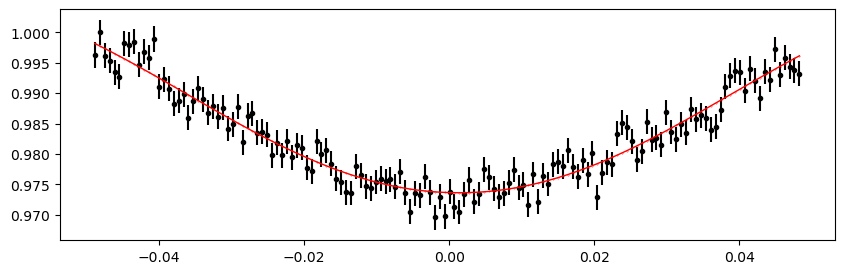

2428.9620640000003 1.0091451011936945 -0.03773387812646225 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:30<00:00, 333.12it/s]


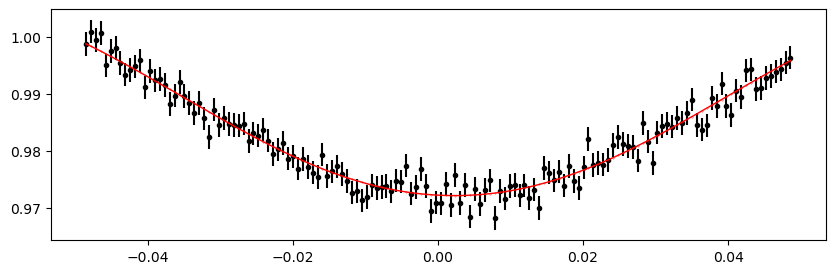

2431.007265 1.0091451011936945 -0.03773387812646225 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:29<00:00, 335.62it/s]


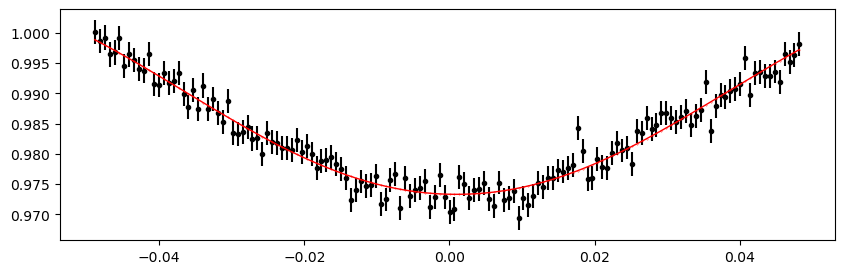

2435.097667 1.0091451011936945 -0.03773387812646225 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:29<00:00, 335.62it/s]


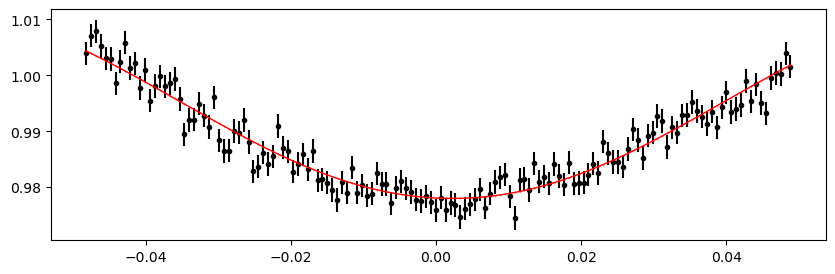

2437.142868 1.0091451011936945 -0.03773387812646225 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:30<00:00, 324.46it/s]


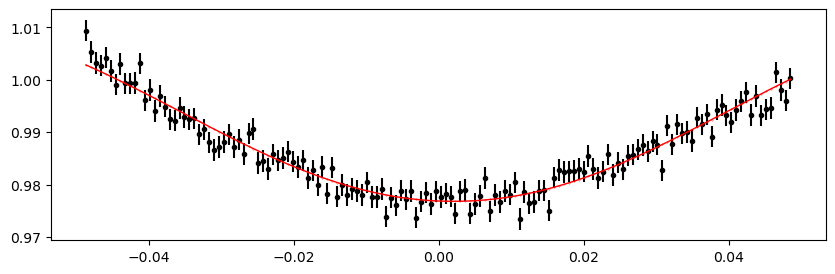

2439.188069 1.0091451011936945 -0.03773387812646225 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:30<00:00, 332.81it/s]


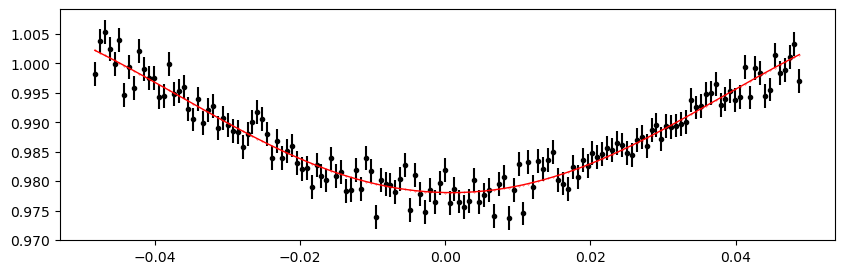

2441.23327 1.0091451011936945 -0.03773387812646225 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:30<00:00, 329.50it/s]


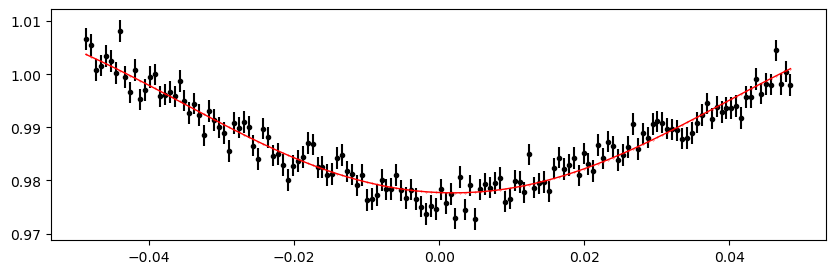

2443.278471 1.0091451011936945 -0.03773387812646225 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:29<00:00, 335.13it/s]


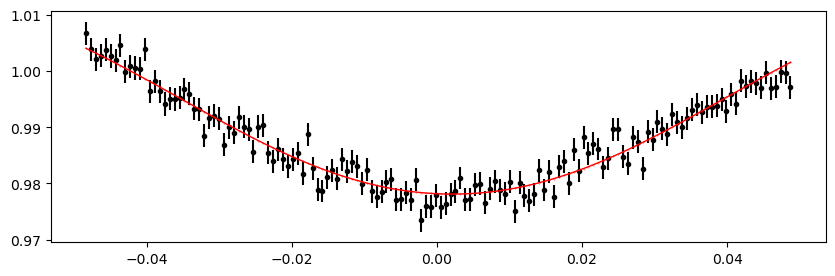

2445.323672 1.0091451011936945 -0.03773387812646225 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:30<00:00, 327.65it/s]


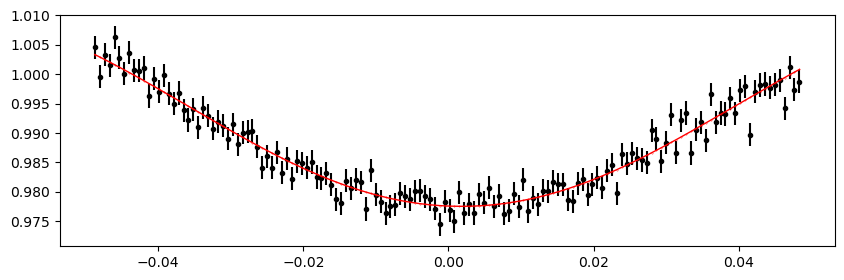

2770.510631 1.0091451011936945 -0.03773387812646225 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:30<00:00, 329.14it/s]


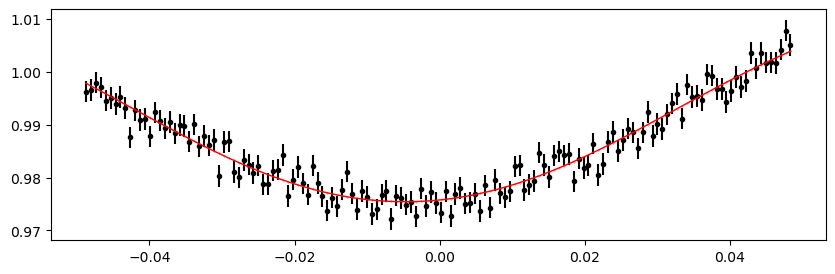

2772.555832 1.0091451011936945 -0.03773387812646225 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:29<00:00, 336.64it/s]


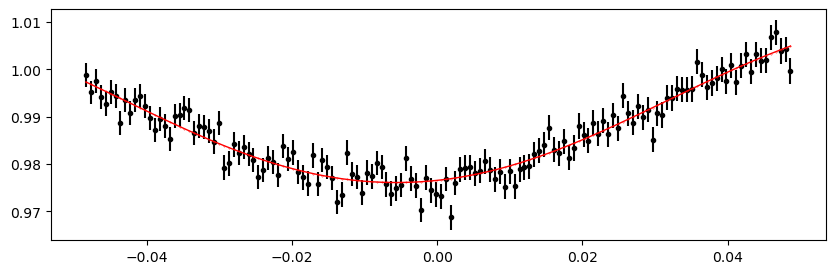

2774.601033 1.0091451011936945 -0.03773387812646225 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:29<00:00, 333.45it/s]


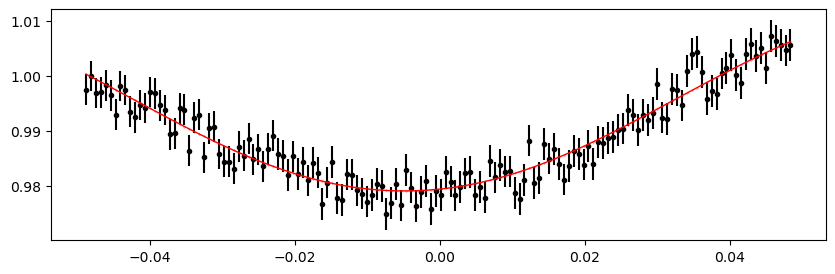

2776.646234 1.0091451011936945 -0.03773387812646225 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:29<00:00, 334.85it/s]


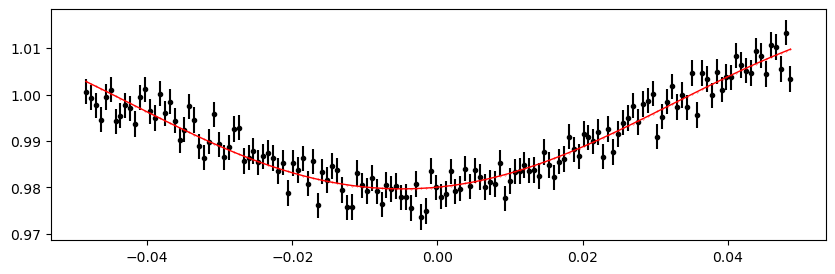

2778.6914349999997 1.0091451011936945 -0.03773387812646225 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:29<00:00, 334.25it/s]


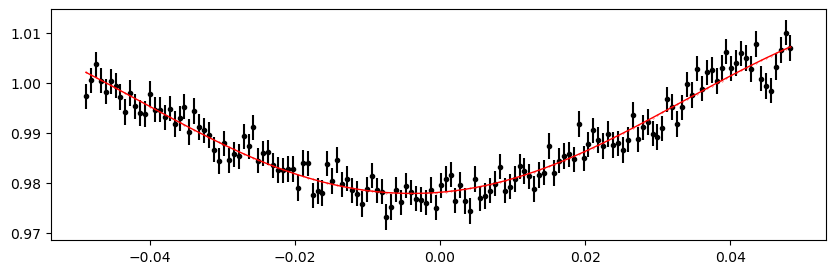

2780.736636 1.0091451011936945 -0.03773387812646225 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:29<00:00, 333.86it/s]


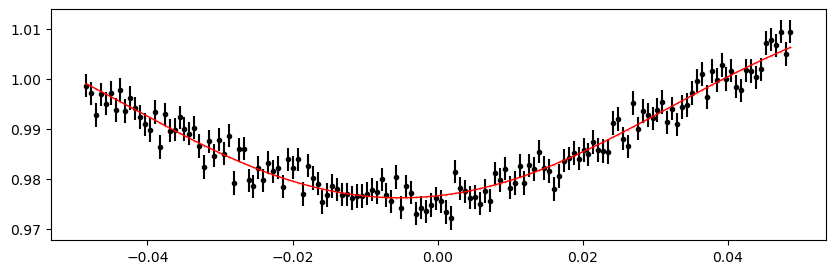

2784.8270380000004 1.0091451011936945 -0.03773387812646225 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:29<00:00, 342.63it/s]


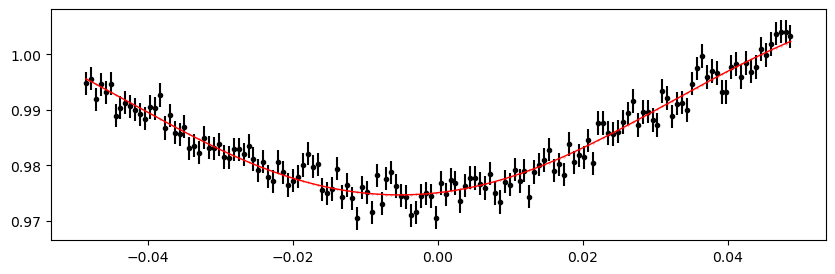

2786.8722390000003 1.0091451011936945 -0.03773387812646225 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:29<00:00, 335.16it/s]


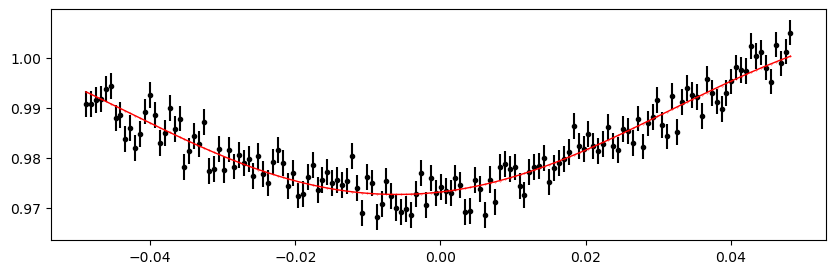

2788.91744 1.0091451011936945 -0.03773387812646225 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:31<00:00, 318.38it/s]


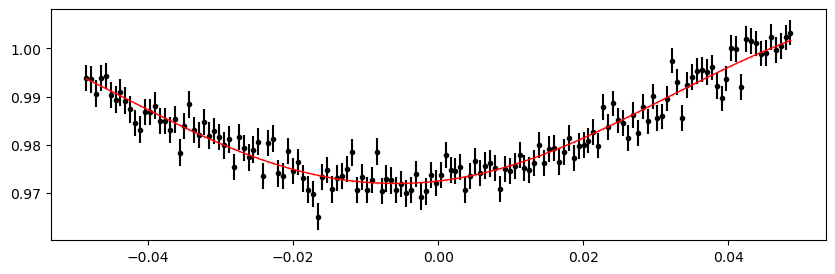

2790.962641 1.0091451011936945 -0.03773387812646225 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:30<00:00, 329.91it/s]


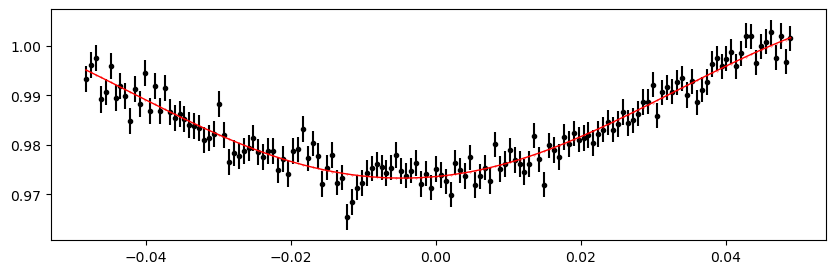

2793.007842 1.0091451011936945 -0.03773387812646225 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:30<00:00, 324.27it/s]


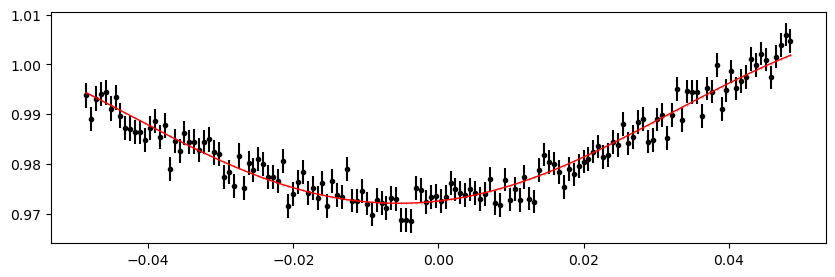

2795.053043 1.0091451011936945 -0.03773387812646225 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:30<00:00, 330.25it/s]


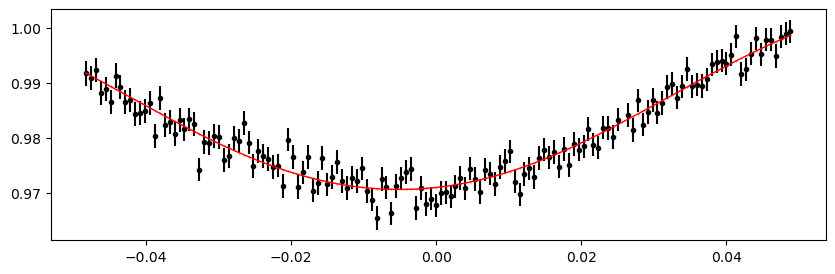

2825.7310580000003 1.0091451011936945 -0.03773387812646225 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:29<00:00, 336.48it/s]


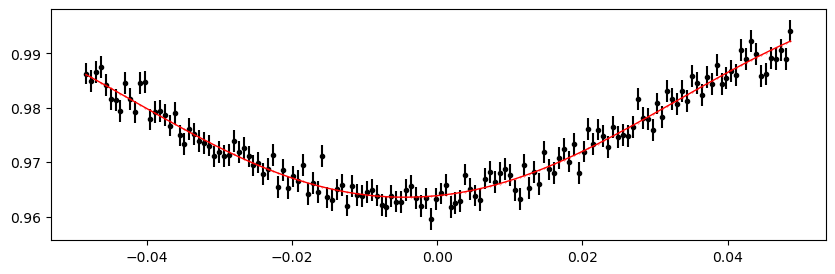

2827.776259 1.0091451011936945 -0.03773387812646225 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:31<00:00, 319.36it/s]


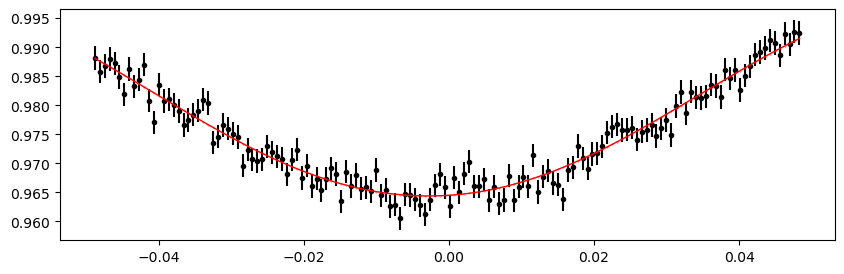

2829.82146 1.0091451011936945 -0.03773387812646225 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:30<00:00, 332.60it/s]


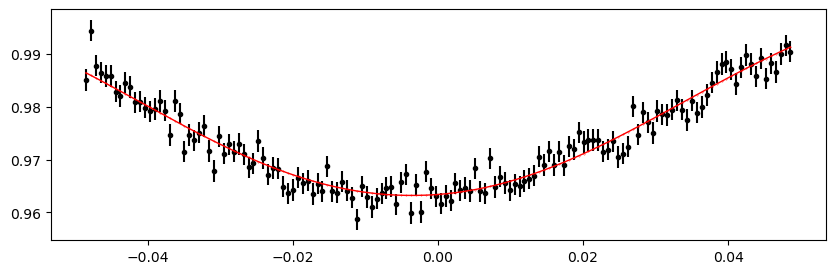

Time 2831.866661 does not have enough data points: 18
2833.911862 1.0091451011936945 -0.03773387812646225 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:31<00:00, 322.48it/s]


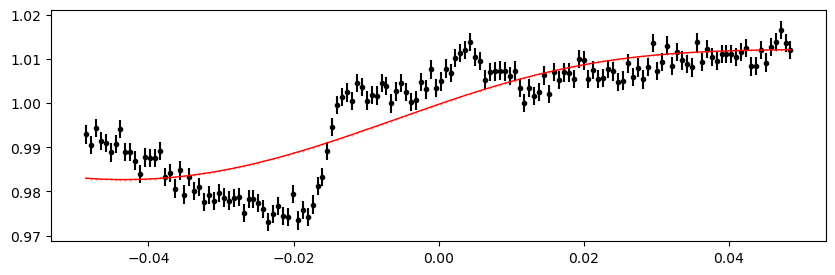

2835.957063 1.0091451011936945 -0.03773387812646225 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:30<00:00, 326.12it/s]


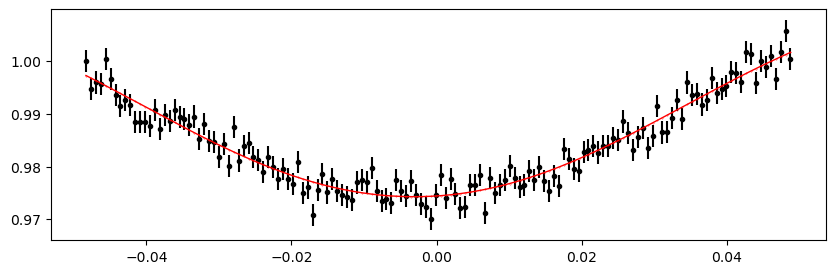

2838.0022639999997 1.0091451011936945 -0.03773387812646225 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:29<00:00, 339.72it/s]


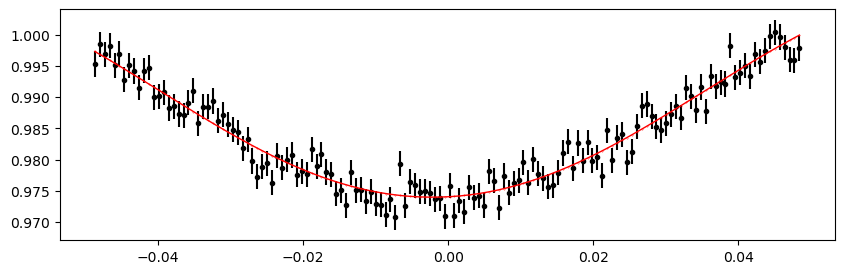

2840.047465 1.0091451011936945 -0.03773387812646225 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:29<00:00, 333.79it/s]


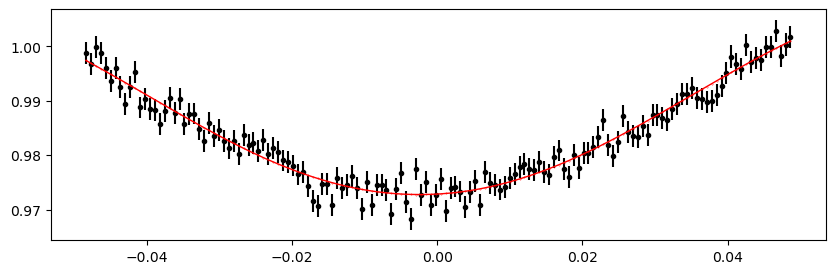

2842.092666 1.0091451011936945 -0.03773387812646225 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:29<00:00, 336.04it/s]


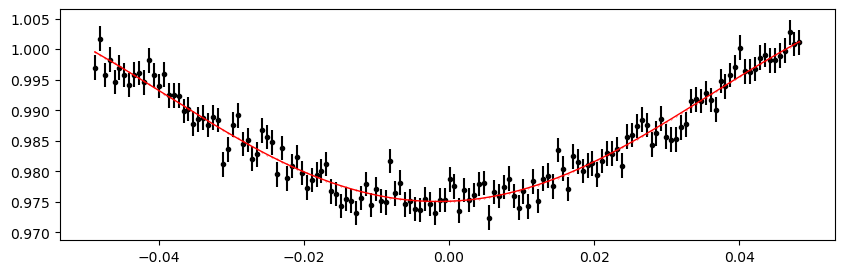

2844.1378670000004 1.0091451011936945 -0.03773387812646225 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:29<00:00, 344.39it/s]


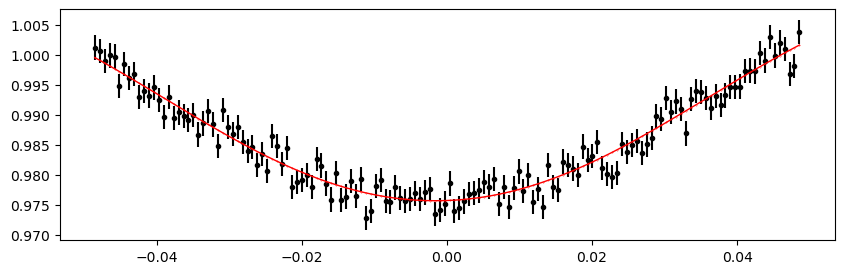

2846.1830680000003 1.0091451011936945 -0.03773387812646225 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:30<00:00, 325.11it/s]


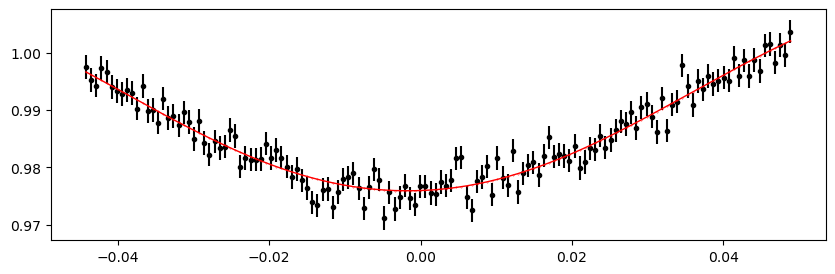

2848.228269 1.0091451011936945 -0.03773387812646225 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:29<00:00, 335.76it/s]


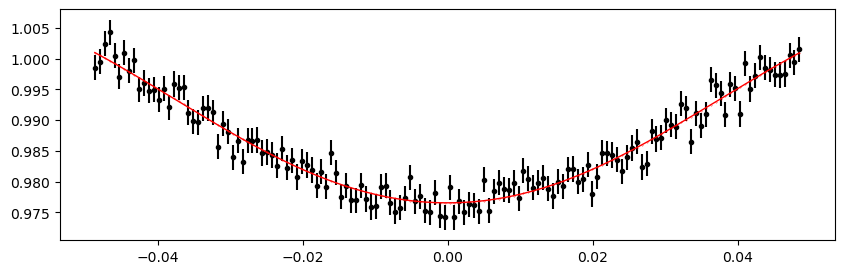

2850.27347 1.0091451011936945 -0.03773387812646225 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:30<00:00, 331.09it/s]


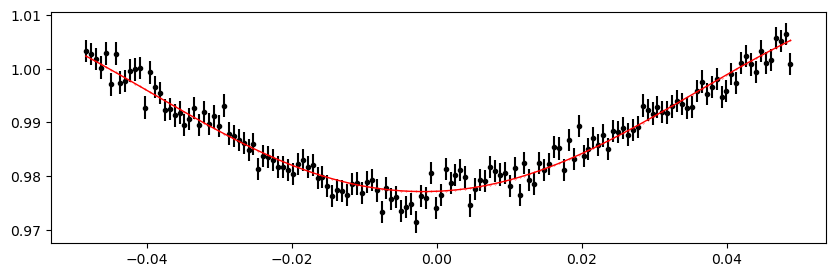

2852.318671 1.0091451011936945 -0.03773387812646225 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:30<00:00, 330.06it/s]


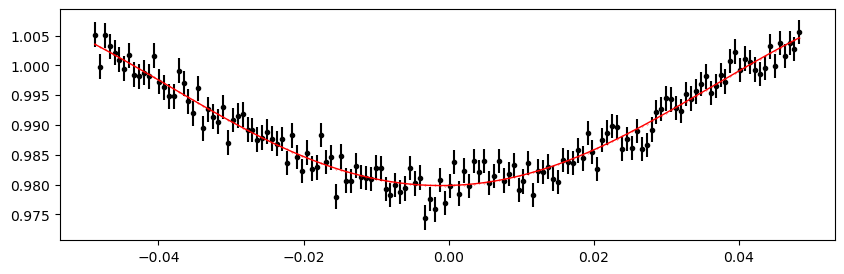

3367.709323 1.0091451011936945 -0.03773387812646225 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:27<00:00, 364.51it/s]


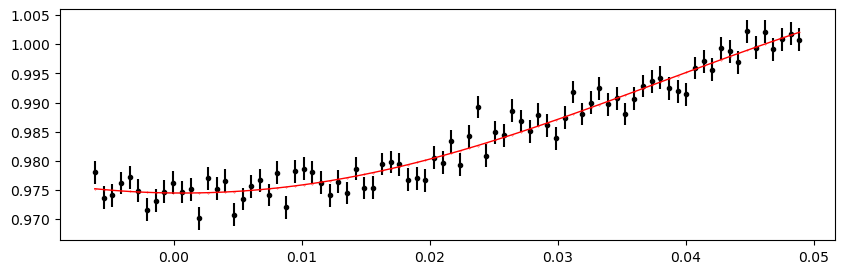

3369.754524 1.0091451011936945 -0.03773387812646225 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:30<00:00, 322.84it/s]


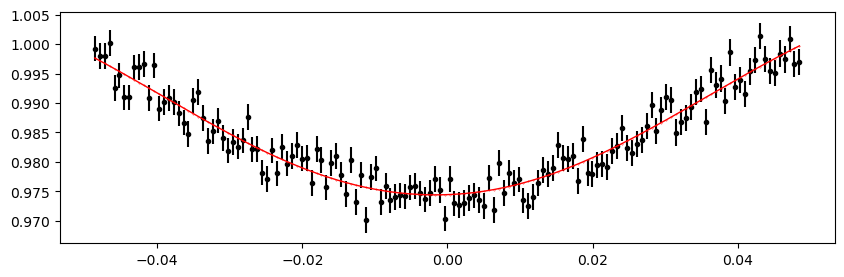

3371.799725 1.0091451011936945 -0.03773387812646225 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:29<00:00, 337.90it/s]


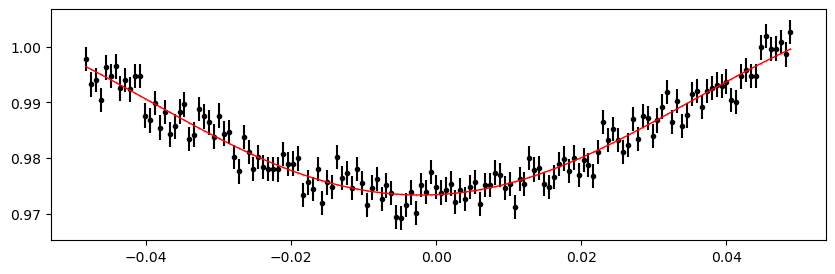

3373.8449259999998 1.0091451011936945 -0.03773387812646225 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:33<00:00, 299.09it/s]


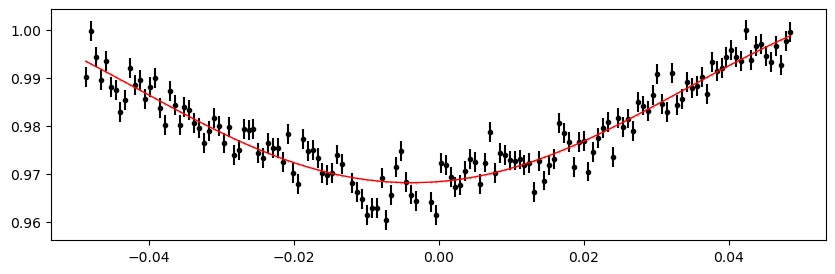

3375.890127 1.0091451011936945 -0.03773387812646225 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:40<00:00, 244.64it/s]


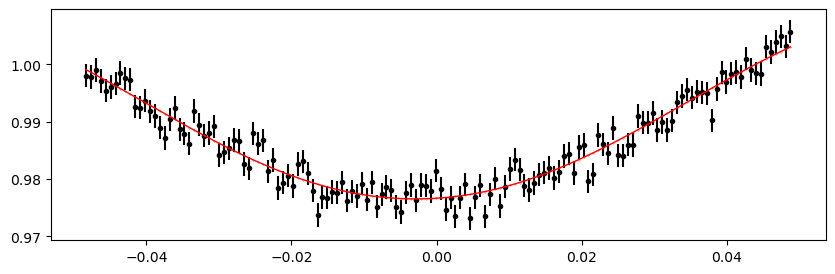

3377.935328 1.0091451011936945 -0.03773387812646225 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:30<00:00, 331.51it/s]


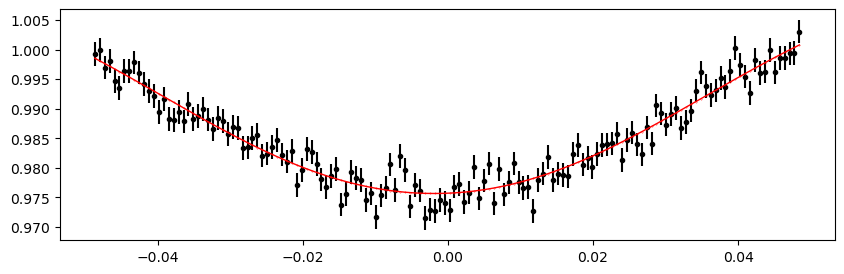

3379.9805290000004 1.0091451011936945 -0.03773387812646225 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:29<00:00, 334.99it/s]


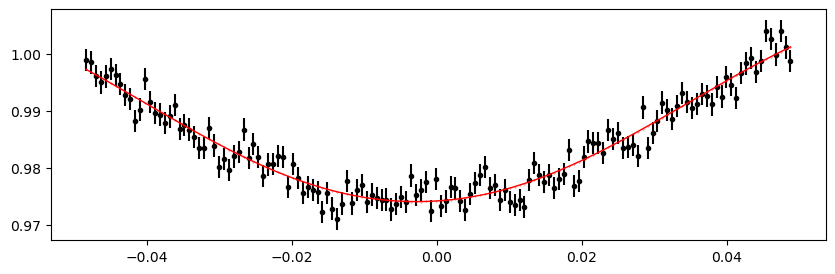

3382.0257300000003 1.0091451011936945 -0.03773387812646225 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:31<00:00, 319.56it/s]


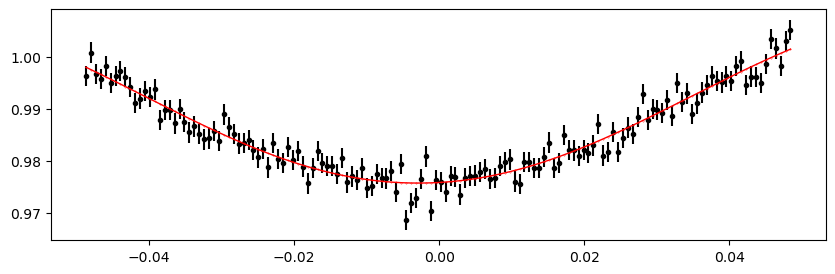

3384.070931 1.0091451011936945 -0.03773387812646225 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:30<00:00, 323.01it/s]


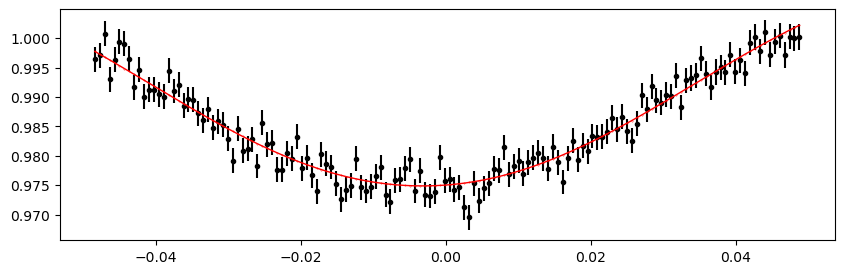

3386.116132 1.0091451011936945 -0.03773387812646225 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:30<00:00, 324.92it/s]


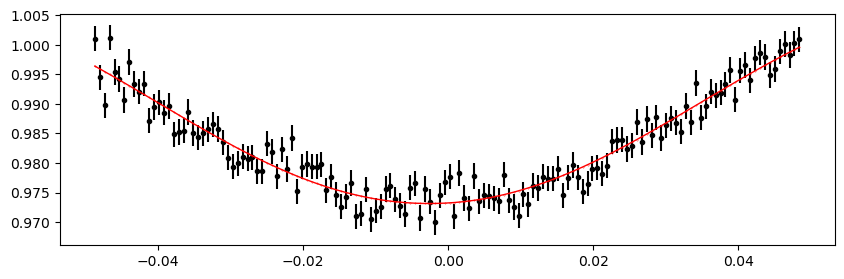

3388.161333 1.0091451011936945 -0.03773387812646225 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:30<00:00, 330.31it/s]


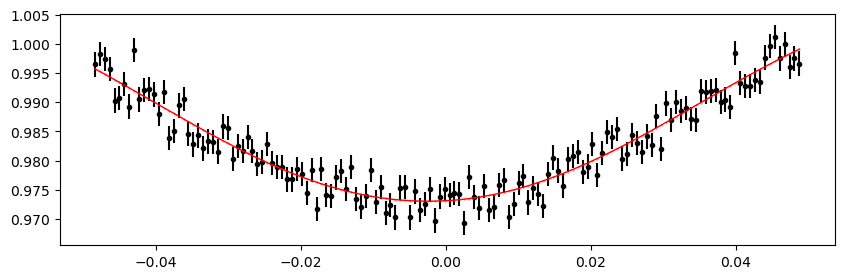

3390.206534 1.0091451011936945 -0.03773387812646225 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:30<00:00, 328.27it/s]


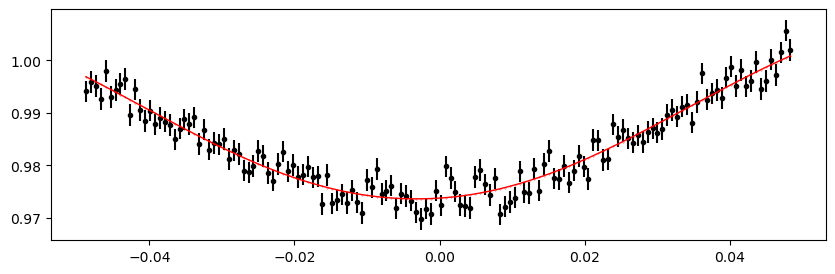

3392.251735 1.0091451011936945 -0.03773387812646225 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:29<00:00, 335.45it/s]


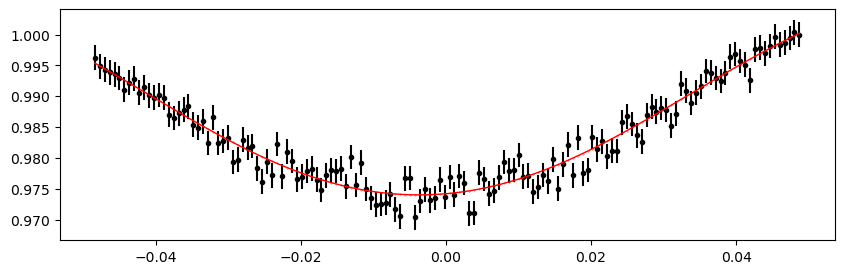

In [41]:
# ---

%matplotlib inline

if t0_secondary is not None:
    print("Fitting individual secondary eclipses...")
    etv_functions.fit_each_eclipse(data_secondary, n_transits, t0_secondary, period, mean_alpha0_s, mean_alpha1_s, mean_t0_s, mean_d_s, mean_Tau_s, outfile_path_s,
                                   min_number_data=20,
                                  )
    !$NOTIFY_CMD "Individual secondary eclipses fit done"
else:
    print("No secondary eclipses defined. No-Op.")

## ETV O-C plot

Note: 1 data points in in_df_secondary filtered out (outliers).


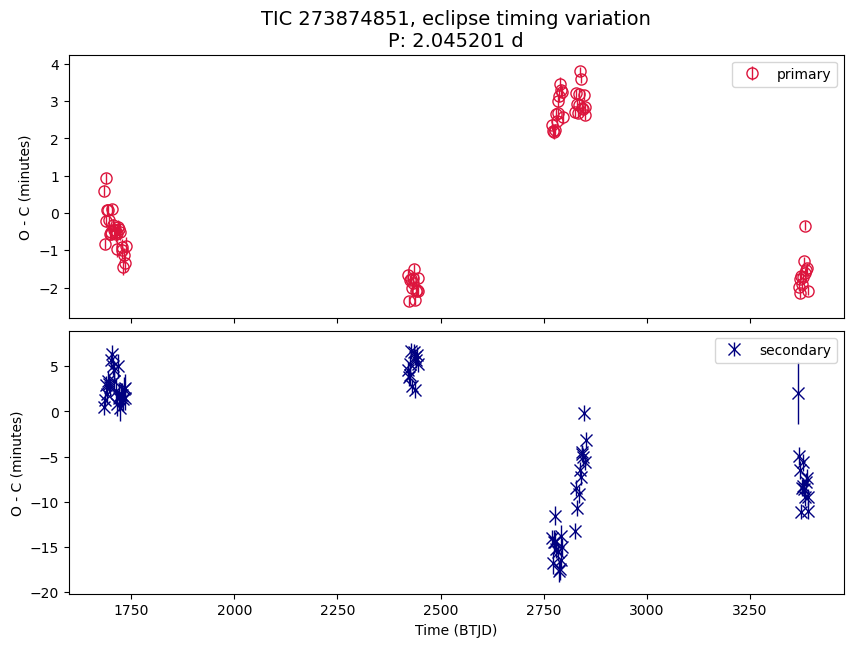

In [45]:
%matplotlib inline
# %matplotlib widget


title_suffix = "eclipse timing variation"

#plot the extracted transit times to check for ETVs

num_rows = 2 if t0_secondary is not None else 1
figsize_y = 3.3 if num_rows == 1 else num_rows * 3.5
# num_rows = 1  # force to plot primary only
# figsize_y = 3.3

fig, axs = plt.subplots(num_rows, 1, figsize=(10, figsize_y), sharex=True)
if isinstance(axs, plt.Axes):  # handle edge case that num_rows == 1, returned axs is not a list
    axs = [axs]

in_df_primary = pd.read_csv(outfile_path)
in_df_primary['midpoint'] = in_df_primary['epoch'] + (in_df_primary['t0']*period)
in_df_primary['shift_mins'] = in_df_primary['t0']*period*24*60
in_df_primary['std_mins'] = in_df_primary['stdv_t0']*period*24*60
in_df_primary_all = in_df_primary  # in case filtering is helpful

# in_df_primary = in_df_primary[in_df_primary.std_mins < 10]  # filter out outliers in error
# print(f"Note: {len(in_df_primary_all) - len(in_df_primary)} data points in df_primary filtered out due to huge O-C error.")

# axs[0].plot(in_df_primary['epoch'], in_df_primary['shift_mins'],
#              lw = 1, color = 'crimson', )
# axs[0].scatter(in_df_primary['epoch'], in_df_primary['shift_mins'],
#              marker = 'o', s=8**2, color = 'None', edgecolor = 'crimson', label="primary")
axs[0].errorbar(in_df_primary['epoch'], in_df_primary['shift_mins'], yerr = in_df_primary['std_mins'],
             lw = 0, marker = 'o', elinewidth = 1, markersize = 8, color = 'None', ecolor='crimson', markeredgecolor = 'crimson', label="primary")

# if False:
if t0_secondary is not None:
    in_df_secondary = pd.read_csv(outfile_path_s)
    in_df_secondary['midpoint'] = in_df_secondary['epoch'] + (in_df_secondary['t0']*period)
    in_df_secondary['shift_mins'] = in_df_secondary['t0']*period*24*60
    in_df_secondary['std_mins'] = in_df_secondary['stdv_t0']*period*24*60
    in_df_secondary_all = in_df_secondary  # in case filtering is helpful

    in_df_secondary = in_df_secondary[in_df_secondary.shift_mins > -100]  # filter out outliers
    print(f"Note: {len(in_df_secondary_all) - len(in_df_secondary)} data points in in_df_secondary filtered out (outliers).")

    # axs[1].plot(in_df_secondary['epoch'], in_df_secondary['shift_mins'],
    #              lw = 1, color = 'navy', )
    # axs[1].scatter(in_df_secondary['epoch'], in_df_secondary['shift_mins'],
    #              marker = 'x',  s=9**2, color = 'navy', zorder = -2, label="secondary" );
    axs[1].errorbar(in_df_secondary['epoch'], in_df_secondary['shift_mins'], yerr = in_df_secondary['std_mins'],
                 lw = 0, marker = 'x', elinewidth = 1, markersize = 9, color = 'navy', zorder = -2, label="secondary" );
else:
    in_df_secondary = None

for ax in axs:
    ax.set_ylabel("O - C (minutes)")
    ax.legend();

axs[-1].set_xlabel(f"Time ({search_result.time.format.upper()})")
axs[0].set_title(f"TIC {ticid}, {title_suffix}\nP: {period} d", fontsize=14)

plt.subplots_adjust(hspace=0.05)
# plt.ylim(-3, 8)
plt.show()

### O-C Plot, Zoom In

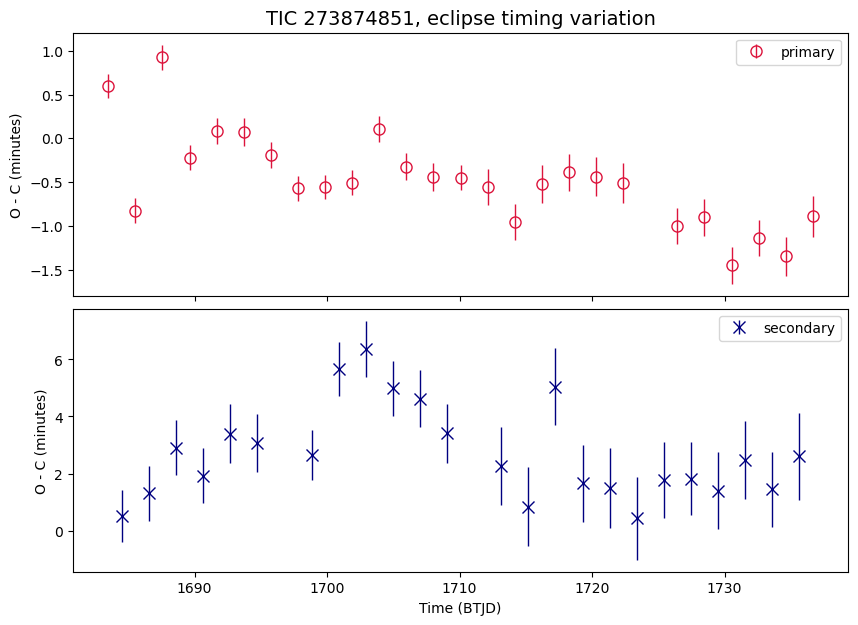

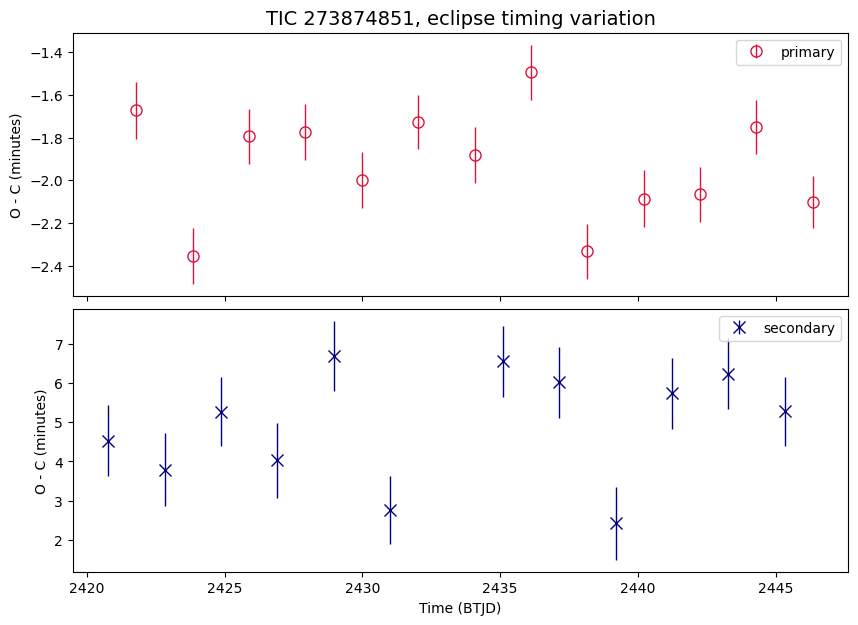

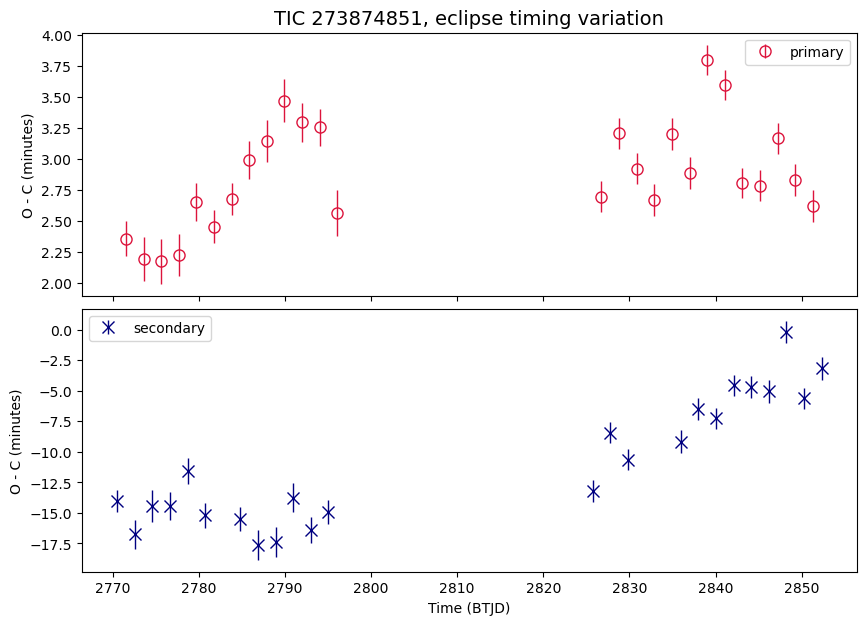

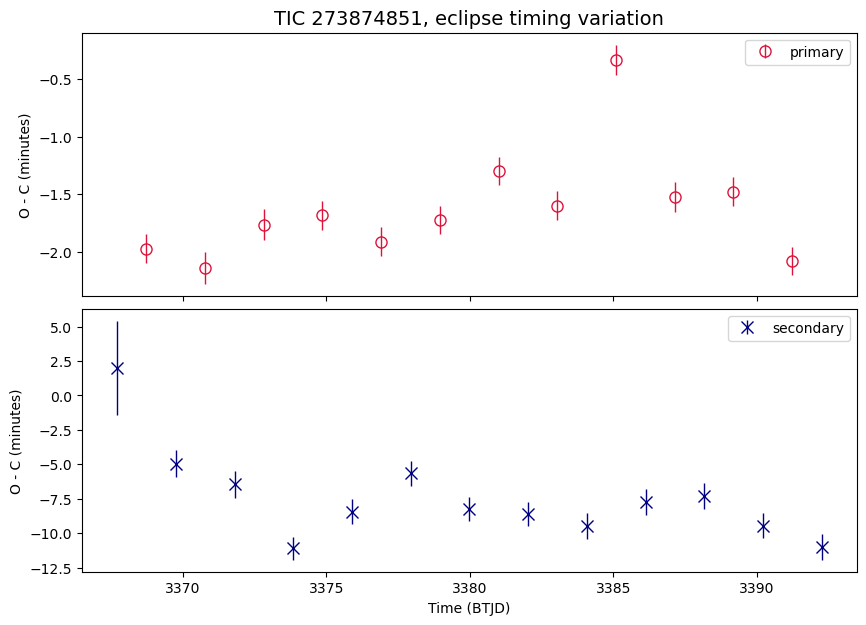

In [47]:
%matplotlib inline
# %matplotlib widget

zoom_ranges = [
    (1600, 1800),
    (2400, 2500),
    (2700, 2900),
    (3100, 3500),
]

def tweak_axs_list(axs_list):
    # axs_list[0][1].set_ylim(-20, 30);
    # axs_list[1][0].set_ylim(None, 0.5);
    # axs_list[2][1].set_ylim(-30, None);

    # ax = axs_list[0][0]
    # ax.set_title(f"{ax.get_title()} (2min cadence)")
    # ax = axs_list[1][0]
    # ax.set_title(f"{ax.get_title()} (2min cadence)")
    
    pass


def plot_oc_in_zoom_ranges(in_df_primary, in_df_secondary, zoom_ranges):
    axs_list = []
    for zoom_start, zoom_end in zoom_ranges:
        num_rows = 2 if t0_secondary is not None else 1
        figsize_y = 3.3 if num_rows == 1 else num_rows * 3.5

        fig, axs = plt.subplots(num_rows, 1, figsize=(10, figsize_y), sharex=True)
        if isinstance(axs, plt.Axes):  # handle edge case that num_rows == 1, returned axs is not a list
            axs = [axs]

        df_zoom = in_df_primary[(in_df_primary['epoch'] > zoom_start) & (in_df_primary['epoch'] < zoom_end)]

        # axs[0].scatter(df_zoom['epoch'], df_zoom['shift_mins'],
        #                marker = 'o', s=8**2, color = 'None', edgecolor = 'crimson', label="primary")
        axs[0].errorbar(df_zoom['epoch'], df_zoom['shift_mins'], yerr = df_zoom['std_mins'],
                        lw = 0, marker = 'o', elinewidth = 1, markersize = 8, color = 'None', ecolor='crimson', markeredgecolor = 'crimson', label="primary")

        if in_df_secondary is not None:
            df_zoom = in_df_secondary[(in_df_secondary['epoch'] > zoom_start) & (in_df_secondary['epoch'] < zoom_end)]

            # axs[1].scatter(df_zoom['epoch'], df_zoom['shift_mins'],
            #                marker = 'x',  s=9**2, color = 'navy', zorder = -2, label="secondary" );
            axs[1].errorbar(df_zoom['epoch'], df_zoom['shift_mins'], yerr = df_zoom['std_mins'],
                            lw = 0, marker = 'x', elinewidth = 1, markersize = 9, color = 'navy', zorder = -2, label="secondary" );

        for ax in axs:
            ax.set_ylabel("O - C (minutes)")
            ax.legend();

        axs[-1].set_xlabel("Time (BTJD)")
        axs[0].set_title(f"TIC {ticid}, {title_suffix}", fontsize=14)

        plt.subplots_adjust(hspace=0.05)
        axs_list.append(axs)
    return axs_list


axs_list = plot_oc_in_zoom_ranges(in_df_primary, in_df_secondary, zoom_ranges)
tweak_axs_list(axs_list);

## make a periodogram 

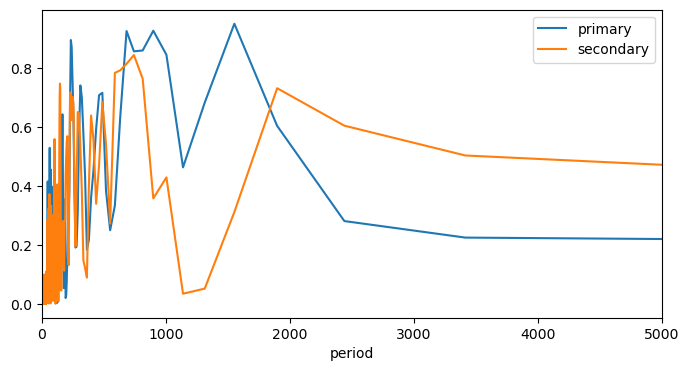

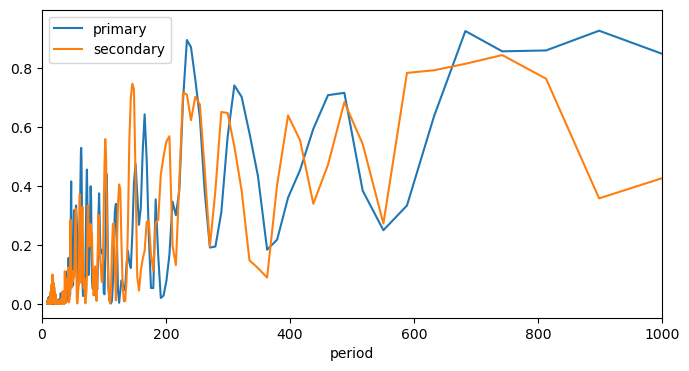

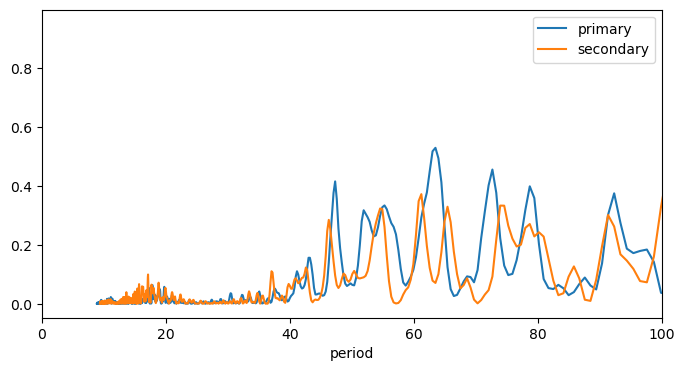

In [56]:
frequency, power = LombScargle(in_df_primary['epoch'], in_df_primary['shift_mins']).autopower()

fig, ax = plt.subplots(figsize=(8, 4))

plt.plot(1/frequency, power, label = 'primary')    

if t0_secondary is not None:
    frequency_s, power_s = LombScargle(in_df_secondary['epoch'], in_df_secondary['shift_mins']).autopower()
    plt.plot(1/frequency_s, power_s, label = 'secondary')    

plt.xlabel("period")

plt.legend()
plt.xlim(0, 5000)
plt.show()


if True:
    fig, ax = plt.subplots(figsize=(8, 4))
    
    plt.plot(1/frequency, power, label = 'primary')    
    
    if t0_secondary is not None:
        frequency_s, power_s = LombScargle(in_df_secondary['epoch'], in_df_secondary['shift_mins']).autopower()
        plt.plot(1/frequency_s, power_s, label = 'secondary')    
    
    plt.xlabel("period")
    
    plt.legend()
    plt.xlim(0, 1000)
    plt.show()

if True:
    fig, ax = plt.subplots(figsize=(8, 4))
    
    plt.plot(1/frequency, power, label = 'primary')    
    
    if t0_secondary is not None:
        frequency_s, power_s = LombScargle(in_df_secondary['epoch'], in_df_secondary['shift_mins']).autopower()
        plt.plot(1/frequency_s, power_s, label = 'secondary')    
    
    plt.xlabel("period")
    
    plt.legend()
    plt.xlim(0, 100)
    plt.show()


## O-C plot, folded

- for periodic trend in O-C

In [53]:
def truncate_freq_power_to_period_range(freq, power, period_min, period_max):
    f, p = freq, power
    if period_min is not None:
        f, p = f[f < 1 / period_min], p[f < 1 / period_min]
    if period_max is not None:
        f, p = f[f > 1 / period_max], p[f >  1 / period_max]
    return f, p


def plot_oc_folded(period_min=None, period_max=None, period_min_s=None, period_max_s=None, period=None, period_s=None):

    if period is None:
        _f, _p = truncate_freq_power_to_period_range(frequency, power, period_min, period_max)
        period = 1 / _f[np.argmax(_p)]
    phase_oc = etv_functions.phase_data(in_df_primary.epoch, 0, period)

    fig, axs = plt.subplots(num_rows, 1, figsize=(10, figsize_y * 1.1), sharex=False)
    if isinstance(axs, plt.Axes):  # handle edge case that num_rows == 1, returned axs is not a list
        axs = [axs]
    
    axs[0].scatter(phase_oc, in_df_primary.shift_mins, marker = 'o', s=12**2, c=in_df_primary.epoch);
    axs[0].errorbar(phase_oc, in_df_primary['shift_mins'], yerr = in_df_primary['std_mins'],
                    lw = 0, marker = 'o', elinewidth = 1, markersize = 8, color = 'None', ecolor='crimson', markeredgecolor = 'None', label="primary")
    axs[0].set_title(f"TIC {ticid}, {title_suffix}\nfolded with P={period:.4f} d", fontsize=14)

    if in_df_secondary is not None:
        if period_s is None:
            _f, _p = truncate_freq_power_to_period_range(frequency_s, power_s, period_min_s, period_max_s)
            period_s= 1 / _f[np.argmax(_p)]
        phase_oc_s = etv_functions.phase_data(in_df_secondary.epoch, 0, period_s)
        axs[1].scatter(phase_oc_s, in_df_secondary.shift_mins, marker = 'o',  s=12**2, c=in_df_secondary.epoch);
        axs[1].errorbar(phase_oc_s, in_df_secondary['shift_mins'], yerr = in_df_secondary['std_mins'],
                        lw = 0, marker = 'o', elinewidth = 1, markersize = 8, color='None', ecolor='navy', markeredgecolor = 'None', label="secondary" );
        axs[1].set_title(f"TIC {ticid}, {title_suffix}\nfolded with P={period_s:.4f} d", fontsize=14)

    for ax in axs:
        ax.set_ylabel("O - C (minutes)")
        ax.set_xlabel("Phase (Normalized)")
        ax.legend();
    plt.subplots_adjust(hspace=0.4)
    return axs

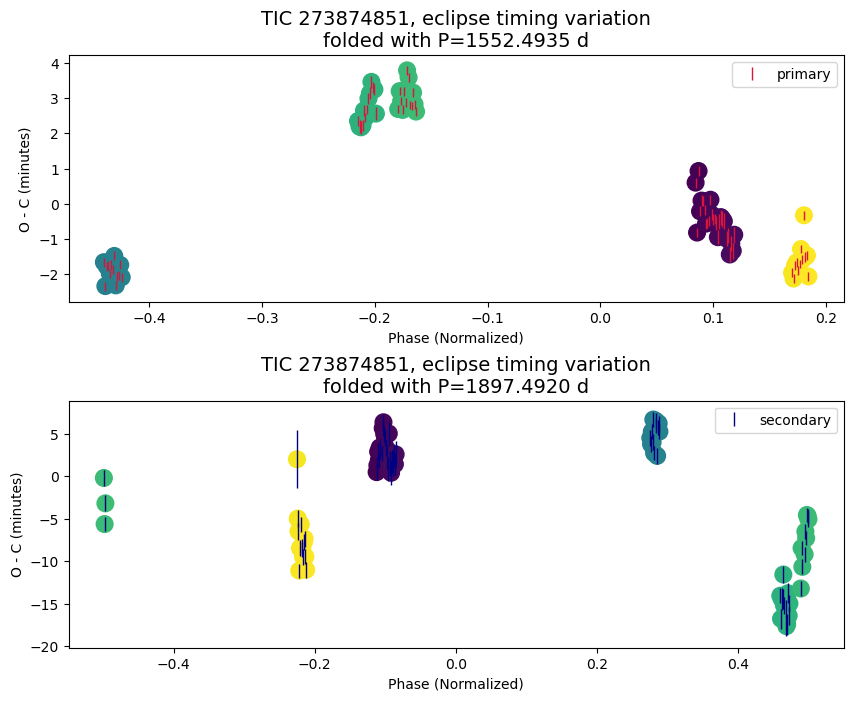

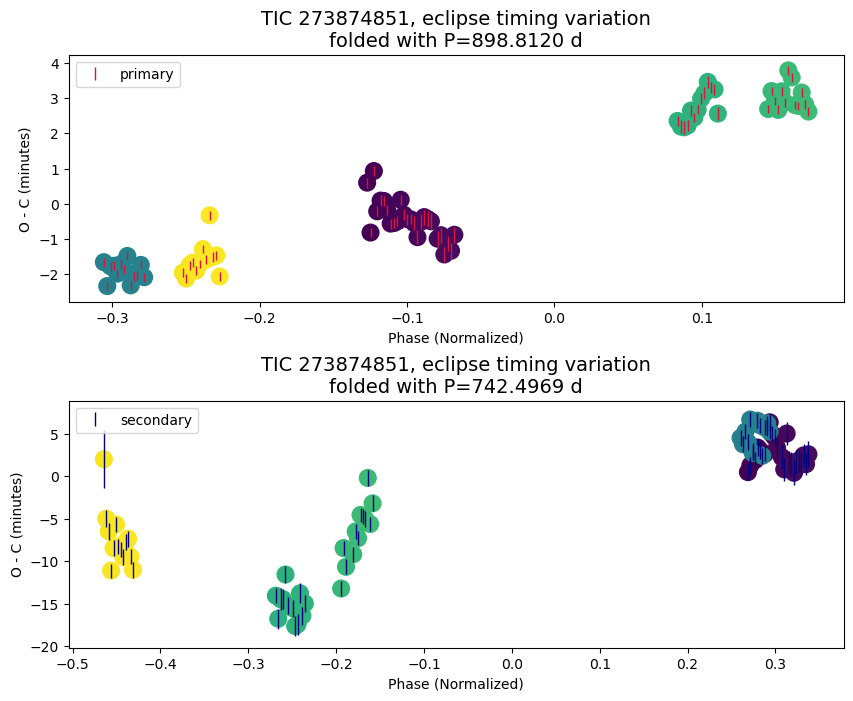

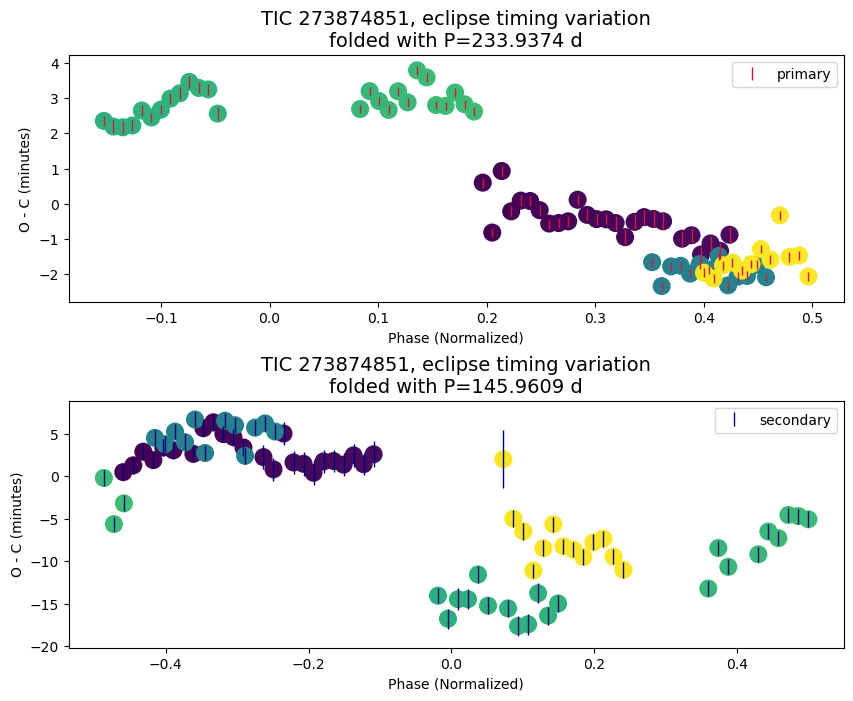

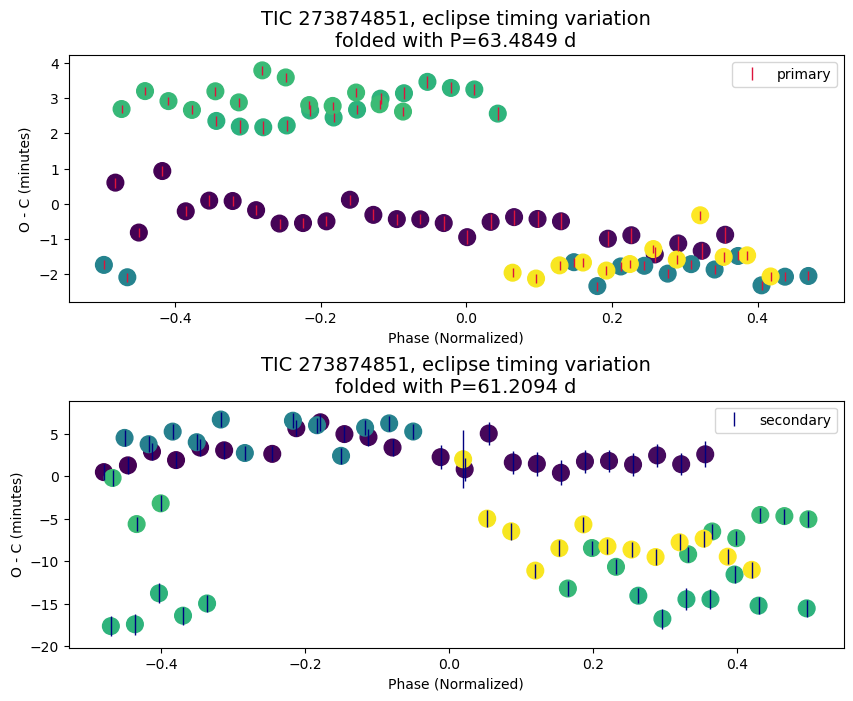

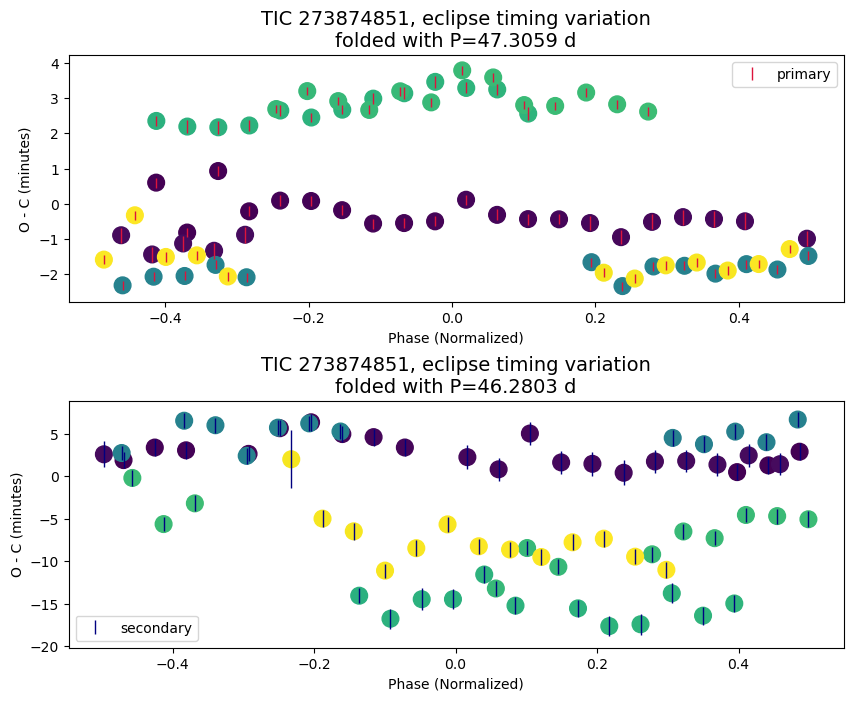

In [62]:
%matplotlib inline
# %matplotlib widget

if True:  # plot O-C periodic trend by folding with a period (from LS Periodogram by default)
    def tweak_axs(axs):
        pass

    axs = plot_oc_folded(
        period_min=1000, period_max=None,
        period_min_s=1000, period_max_s=None
    )
    axs = plot_oc_folded(
        period_min=None, period_max=1000,
        period_min_s=None, period_max_s=1000
    )
    axs = plot_oc_folded(
        period_min=None, period_max=400,
        period_min_s=None, period_max_s=400
    )
    axs = plot_oc_folded(  # The SB Period ~= 69.6 d in Gaia DR3 NSS
        period_min=50, period_max=100,
        period_min_s=50, period_max_s=100
    )
    axs = plot_oc_folded(
        period_min=None, period_max=50,
        period_min_s=None, period_max_s=50
    )
    # tweak_axs(axs)

## Results Summary

In [61]:
# FILL-IN the ETV results / comments
has_etv = "Y?"
comments = "Possible long-term (100+ d) non-linear change, ampklitude ~6 min for primary, < 30 min for secondary. SPOC's SAP_FLUX is used (instead of PDCSAP_FLUX) for more consistent eclipde depth, possibly due to contamination of nearby TIC 1881902473 (<1 arcsec away, delta mag +0.7). Thus the eclipse depth of this entry is underestimated. Sectors 74, 75 QLP data not used due to eclipse depth difference."

# Eclipse depth from the model
depth_pct_p = round(-mean_alpha1 * 100, 2)
if t0_secondary is not None:
    depth_pct_s = round(-mean_alpha1_s * 100, 2)
else:
    depth_pct_s = None

summary = {
    "tic": ticid,
    "has_etv": has_etv,
    "comments": comments,
    "period": period,  # the period used in ETV analysis
    "depth_pct_p": depth_pct_p,
    "depth_pct_s": depth_pct_s,
    "epoch_p": t0_primary,
    "epoch_s": t0_secondary,
    "num_sectors": len(sr),
    "time_span": round(time[-1] - time[0], 2),
    "time_start": round(time[0], 2),
    "time_end": round(time[-1], 2),
}

summary = pd.DataFrame.from_dict(summary, orient="index")
with pd.option_context('display.max_colwidth', None, 'display.max_rows', 999, 'display.max_columns', 99):
    display(summary);

# Single line to be added to a CSV
print("")
print(summary.transpose().to_csv(
    index=False,
    header=True, 
))

0
tic                                                                                                                                                                                                                                                                                                                                                                                                             273874851
has_etv                                                                                                                                                                                                                                                                                                                                                                                                                Y?
comments     Possible long-term (100+ d) non-linear change, ampklitude ~6 min for primary, < 30 min for secondary. SPOC's SAP_FLUX is used (instead of PDCSAP_FLUX) for more consistent eclipde depth, possibly due to contamination of nearby TIC 1881902473 (<1 arcsec away, delta mag +0.7). Thus the eclipse depth of this entry is underestimated. Sectors 74, 75 QLP data not used due to eclipse depth difference.
period                                                                                                                                                                                                                                                                                                                                                                                                           2.045201
depth_pct_p                                                                                                                                                                                                                                                                                                                                                                                                         25.68
depth_pct_s                                                                                                                                                                                                                                                                                                                                                                                                          3.77
epoch_p                                                                                                                                                                                                                                                                                                                                                                                                         1683.4809
epoch_s                                                                                                                                                                                                                                                                                                                                                                                                         1684.5089
num_sectors                                                                                                                                                                                                                                                                                                                                                                                                             6
time_span                                                                                                                                                                                                                                                                                                           


tic,has_etv,comments,period,depth_pct_p,depth_pct_s,epoch_p,epoch_s,num_sectors,time_span,time_start,time_end
273874851,Y?,"Possible long-term (100+ d) non-linear change, ampklitude ~6 min for primary, < 30 min for secondary. SPOC's SAP_FLUX is used (instead of PDCSAP_FLUX) for more consistent eclipde depth, possibly due to contamination of nearby TIC 1881902473 (<1 arcsec away, delta mag +0.7). Thus the eclipse depth of this entry is underestimated. Sectors 74, 75 QLP data not used due to eclipse depth difference.",2.045201,25.68,3.77,1683.4809,1684.5089,6,1711.42,1683.36,3394.78

